<a href="https://colab.research.google.com/github/cafigueroao/peru-web-training-2024/blob/main/DelimitacionDeCuencas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DELIMITACIÓN DE CUENCAS HIDROGRÁFICAS CON LA HERRAMIENTA WHITEBOX

WhiteboxTools es una biblioteca de herramientas geoespaciales de código abierto diseñada para el análisis y procesamiento de datos raster y vectoriales. En Python, WhiteboxTools se integra como `whitebox-python`, proporcionando acceso directo a estas herramientas a través de scripts y aplicaciones.

`whitebox-python` permite a los usuarios realizar diversas operaciones geoespaciales, incluida la delimitación de cuencas hidrográficas. Esta función es crucial para la gestión de recursos hídricos y la planificación del uso del suelo, ya que facilita la identificación y análisis de las áreas de drenaje natural de una cuenca a partir de datos topográficos.

Al utilizar `whitebox-python`, los usuarios pueden automatizar el proceso de delimitación de cuencas hidrográficas, lo cual implica la generación de límites precisos basados en la topografía local. Esto no solo mejora la eficiencia en comparación con métodos manuales, sino que también asegura resultados consistentes y reproducibles para estudios hidrológicos y ambientales.

* Lindsay, J. B. (2016). Whitebox GAT: A case study in geomorphometric analysis. Computers & Geosciences, 95, 75-84. http://dx.doi.org/10.1016/j.cageo.2016.07.003

## Instalación

El comando `!pip install whitebox` se utiliza en entornos de programación como Jupyter Notebook o IPython para instalar la biblioteca de Python llamada "WhiteboxTools". Esta biblioteca proporciona acceso a herramientas geoespaciales de código abierto para el análisis de datos espaciales y geoespaciales.

Al ejecutar este comando, se descargará e instalará la biblioteca WhiteboxTools, que luego puedes utilizar en tu entorno de Python para realizar diversas operaciones de análisis geoespacial como procesamiento de datos raster y vector, análisis de terreno, interpolación, etc.

Es importante mencionar que para ejecutar este comando, necesitas tener pip (el administrador de paquetes de Python) instalado y configurado correctamente en tu entorno.

In [ ]:
!pip install whitebox

## Cargar bibliotecas

Cargar bibliotecas en Python es crucial para extender las capacidades del lenguaje y aprovechar soluciones especializadas desarrolladas por expertos. Estas bibliotecas ofrecen métodos optimizados y funcionalidades avanzadas que permiten a los desarrolladores resolver problemas complejos de manera eficiente y reutilizar código probado y documentado. Además, importar bibliotecas sigue estándares de la comunidad, asegurando consistencia y facilitando la adopción de mejores prácticas en el desarrollo de software. En conjunto, la importación de bibliotecas en Python no solo mejora la productividad y reduce errores, sino que también amplía la flexibilidad y adaptabilidad del lenguaje para una variedad de aplicaciones y proyectos.

In [ ]:
!pip install rasterio

In [ ]:
from google.colab import drive
import whitebox
import gdown
import zipfile
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS
from matplotlib.ticker import MultipleLocator


## Montar Google Drive

Primero, es necesario conectar tu Google Drive para poder acceder a él desde Google Colab y guardar archivos de trabajo así como los resultados en tu almacenamiento en la nube.

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Ruta donde quieres crear la nueva carpeta dentro de tu Google Drive
folder_path = '/content/drive/My Drive/WEAP'

# Crear la carpeta usando el comando mkdir
!mkdir "{folder_path}"

## Importación de la biblioteca y creación de una instancia de WhiteboxTools

1. Importación de la biblioteca WhiteboxTools:
   
   El comando `import whitebox` importa la biblioteca WhiteboxTools en tu entorno de Python. Esto te permite acceder a todas las funciones y herramientas proporcionadas por WhiteboxTools para realizar análisis geoespacial y manipulación de datos raster y vectoriales.

2. Creación de una instancia de WhiteboxTools:
   
   En este comando `wbt = whitebox.WhiteboxTools()`, estás creando una instancia de la clase WhiteboxTools. Esta instancia, representada por la variable wbt, es esencial para interactuar con las herramientas y funciones de WhiteboxTools desde tu código Python.

   * ¿Por qué es importante?: Al crear esta instancia, puedes llamar a métodos específicos de WhiteboxTools a través de wbt. Por ejemplo, puedes ejecutar funciones como análisis de terreno, procesamiento de imágenes, interpolación, cálculo de índices, y muchas otras operaciones geoespaciales.

   * Uso típico: Una vez que tienes wbt configurado, puedes usar métodos como wbt.hillshade(), wbt.flow_accumulation(), wbt.slope(), entre otros, para realizar operaciones específicas de análisis geoespacial según tus necesidades.

In [ ]:
wbt = whitebox.WhiteboxTools()

## Descargar archivos necesarios
El siguiente bloque ejecutará las rutinas necesarias para descargar los archivos esenciales para el desarrollo del taller, que comprenden: i) un modelo digital de elevación en formato raster, y ii) las cuencas delimitadas utilizando las herramientas proporcionadas por el software WEAP en formato vectorial.


In [ ]:
# URL del enlace compartido de Google Drive
gdrive_url = 'https://drive.google.com/uc?id=1PRi1s1f3X5MNkEzOum7AKwRi6BVCW7V0'

# Ruta donde descargar el archivo TIF en Colab
input_file = '/content/drive/My Drive/WEAP/fabdem30_Tumbes.tif'

# Descargar el archivo TIF desde Google Drive
gdown.download(gdrive_url, input_file, quiet=False)

# URL del enlace compartido de Google Drive
gdrive_url = 'https://drive.google.com/uc?id=1lMymqCQj3DY4Fxqgv4uYt-nCJX1QCoU7'

# Ruta donde descargar el archivo zip en Colab
zip_input_file = '/content/drive/My Drive/WEAP/WEAPCatchment_24877.zip'

# Descargar el archivo TIF desde Google Drive
gdown.download(gdrive_url, zip_input_file, quiet=False)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_input_file, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/WEAP/')

## Corrección de depresiones

Las depresiones en un DEM pueden interferir con el análisis hidrológico al afectar el flujo del agua y la delimitación de cuencas hidrográficas. Este proceso mediante el algoritmo de Wang y Liu identifica llena las depresiones, asegurando que el flujo del agua sea continuo y realista, mejorando así la precisión de los resultados en estudios de hidrología y geomorfología.

![image072[1].png](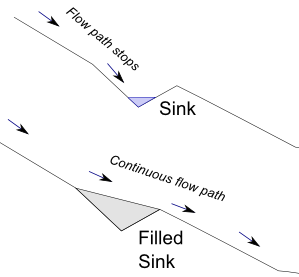)

In [ ]:
# Ruta de salida en Google Drive
fill_file = folder_path + '/Fill.tif'

# Ejecutar la herramienta FillDepressionsWangAndLiu
wbt.fill_depressions_wang_and_liu(input_file, fill_file)

# Plotear el archivo que se acaba de generar
with rasterio.open(fill_file) as src:
    show(src)

## Dirección de flujo

La herramienta `d8_pointer` de Whitebox Tools genera la dirección de flujo en un modelo digital de elevación (DEM) utilizando el método de puntos D8. Este método calcula la dirección en la cual el agua fluiría desde cada celda del DEM hacia una de sus celdas vecinas adyacentes, siguiendo el camino más pronunciado descendiente. Es decir, para cada celda del DEM, se determina hacia dónde fluye el agua basándose en la elevación más baja adyacente. Este proceso crea una rejilla de direcciones de flujo que es fundamental para análisis hidrológicos, como la delimitación precisa de cuencas hidrográficas y la identificación de redes de drenaje en estudios de geomorfología y gestión de recursos hídricos.
![The-analysis-of-flow-direction-and-accumulation-using-D8-model-a-Elevation-b-Flow[1].ppm](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAiAAAAJxCAMAAABMhfl8AAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAAMAUExURf///+Xl5efn55WVlfn5+fPz8/f39/39/fv7+/X19fHx8e/v75GRkaGhoZmZmZ+fn3p6erOzs9vb2+Hh4ampqaWlpcfHx5OTk8/Pz93d3Z2dnZubm+Pj48nJybm5ucvLy6urq6+vr5eXl42Njevr67e3t8XFxb29vcPDw9PT09HR0enp6a2trXx8fI+Pj9fX19XV1bu7u9nZ2b+/v4ODg+3t7bGxsaenp4eHh4uLi2xsbN/f3wAAAKOjo3R0dM3NzYmJibW1tcHBwWpqan5+foWFhXh4eIGBgXZ2dmJiYm5ubnBwcGhoaFxcXFpaWkNDQ2ZmZl5eXv//+1ZWVv///XJycv3//0hISAkJCVNTU//++QICAg8QDywsLEtLS2RkZAQEBGBgYPn///z//1hYWP/9/ycnJzs7Ozc3N//5/1BQUAYGBk5OTv/68/L//0ZGRvr//P//9BQUFCQjJT4+PjQ0NDEwLx0cHDIyMhgXGEBAQP//5h4eHfX//xoaGiAgICEiIhYWFvz/9v/+7+n///3v4f/66fz/7f3/++z5/vP//fP/8u7ey97/+v/43N3s+9e+pcfq9t33+urMpfjgr2OUs5eGmP3v+t3Qwv//2J+vyYOXsq/e/Zh0YG6FpMHQ3KaUhot1j5mCZf/6+oBlc9Gwh7ulj5m6z3pbVvnryLmWYLKDZcexoaK/5bmYg1pLaJKkxM7g+8jc1PTRv1xyiPf6/bXO9oCu0d2meG2hylhIPlc8S/P6/uvj9X29693r3YCShvn7/05kh5m7r+745crLub26oPj33re/0Ojw9+jN1r6XpV1jUT9IWd7B1+PZ5lx0Xe3s/f7v7O7d3dnh9EkuTvf59pWijxYBHjpadoiAk4+WjZOanbzB3sCzvHNwYrOupIh9d311Zyw8W5qQoYJ/kejd9qGmpIeDg3uGeOrq4KmsiIurrZubcnmEfcLA2dDO/3R0kcy/wnuKcOXn6bGvoaWlg4V8VJGblanNy3yvqdPV2+fnq8G/r3p6p5udrbCU9MAAACAASURBVHgB7P0JlFzZeR4Ixr4vGVvGvu9LxpaxZlRkRGRmZOSOTIJJAFUAsrIqCaAAFEFiqUJVkahisVSUSFGULKlNtuWR1LRksylZYttaR9M25/S01TPj6THddh/3uOdYto+nx3Omz/Sc6Z5u2yPP998XL7aMyIhKoKRyGReJeO/d99//bt/773+3/woEz93zEnheAs9L4HkJPC+B5yXwvASel8DzEnheAs9L4HkJPC+B5yXwvAT+vS0BuVwgUEgo+3IFbic6omPuTCqOBLSKLvWzvPApOIPnDCTd0KCUyAX4RbYVEjncGWw/0qtnyasf8TNMIM9UMUOeEe0MFQ4IwVHGQcxu+DgmXRmxXM6AN4mG/MER/DiAnkVH8Usk05OKeCVU22fxonegoYtcxjBCt5SWZ+R6vLgye2ZcUVbPiNfU8mEFQj+syKnoqZ6o/ie4XoDuzQQy3puouBrgfSZcecIJr/ves8Xby3g/4Pg7YkdgxwWZlii77P/9uXTremqGu9+RUqmUSpUymRQ3Y51KKlWp1filH5V6Ih0XWCZTSaQhlVStGstswLMoVaqI44DX2NsiKKQq1VQ6kEjhptIhdSr1QDPY/UDGo+kj+hIv9qUR+p6ZI57Pjt9UYPQJEK9CqRaJXDWTUOia5EQikVAoFCWLSZcQd6JJdLx/MiQiwiT/POkqDBWTIvCd9J73p6hDoOSfJ11ZGkPT6UQmdSgkVUkgP1hl9svj3487JSG4K+XPzjEKSGqPls3+UspXMvj9pfH/zD6zz+crW+q4mM2+8ngqMPHDpVKpssPi95V95gnsesFTFi2oytPpynWtpWyeSgde5Xrdguyc/S9lSdXLpZadWhhpMQmHL8DlwjfydM7kwnch6rF7an691IhCxZDIVOs9P+VNslgsol2dqiNSIywXetpHFzdXd/Z3VvdXd8a7pdWlra39k7sPT7a2V7e2VifR7e8j/P7m5t2HF5dXdw4nkfUjuXvhyg6Y9z3G320f3713d3d1a/zbvu/W6tHJpXsX+x4T7lb3lw52ttejJD9DeZvN7Z6Hi0To92kcx8HN3NPwORXW7fV63fORU/7n9PDOx2yhs0VH763SaGguVXTlsgUfX3mCq+OzrIvXtq4s1MvaOpGOd3V6U9c6Vi8umOt6fKVTnHVpb0MH3lPIypbg4f52xTmdThvo7G8uOKfyK/vE1oUlA1TVZERfmCsU2pVKs1qtPKWrVpuVSrtQ6HQYQzw8G1corC2sFZrBZ8MNWe10dG7ZDBKE2qGM1iqOFiXQUc9yEpnCuKLbKklk+CeZRElMJBK1K3CUU8qmcCQeNeuGwVVUTGLX85cYHRV9LDmVUKG0+3XtUrEXcMKNRCErZuo7foFAmm9tPnlw4+a9e9cvXbj3tO7ShQvXweXJm7duvX39woVLT8uPD//242v3H11/m3986uuFS9feLs2igxBA8nWxOKJEtxQPkxxTaEzz+mXPWVRgxnQfZVK/GiN+Z3DkYhI6F8JJ6XQ6uV0brLuLU/kJFMKWvhqWTsoH749entpYXiqhpxuKV+7dvjgn1ul0AZ3zKZ1OHNDrxAsPb64WrHqx+Kn58clpb92+cYAk8s9Pe3WIj3fDM9QP1Yw8UxcH5mV80Y2/8gDZmAYQQqVcmtQvxehuqhM612YCiKBWD1rc6qn8ZgUIEie1m5cMSKKi6Ftd13hlGGGTYETo6RwYCBRK9/aO3y4Fw6fmx6fGnmvfdSoFkM7PyIkcHff00mR1SBIk0JUgE6sUgkEhqEWckCAKiImJrIlOrlAJHasr/FDARFp64dLNtYSqGQbma1oCyOSI+VgkLoOj2VLxj5OvckiQVUhZgUBpOFxr2riymEw/6xskUd7YOU7VpCixZ+ZMi2v3HM9yAkPpq7iZtJ+SRMpOvh7QMYCcTSsXmOYd67kZ5IJcKtJvRc7m1n0rQhMjmmEcE01M1TL/LCWIQp23rEIHkQuU/qX1dByihGFkpmSfQUSlnlja9NdU09F8BpuRV6aVwl3LMwScIlRvz88MEEsXINNyBIBszAoQamJmcAwgUzUGMKImxjsTQMLaGXQQYEFFOggHkK2FtA1zPSiwp3UcD0gQX14FSfssWLIkGaOd63UpxvWekROoypWZmxgjABKT4gOixmOCQxXJWRMTZlSTCREeZS/SUxMzcWanH4nIiSYGAOn7jL8jgJTdVOZnO4HE1XI0w6qzqdggosoIHYTkodK/1bHapn0dM6C9R2JbOkrZp2h1PeKZbuyxwvXy9GGtmXgxoqK2E0EhTQ1AFHmLTjdPvZhpjiTIFCWVYwEldcZeTNKBJmYmCcJ0kGkpRDshnEmCdHsxAIhcIPWtLqQbkN+KZyHDiUdjad+XoU/umTljpHPBglHfZ8awaKl46aOf5jiABHQrMhDTA5RwKaYnWGmRhFQJJPQKjiRIFyAoVUgHECllIMVkPVRrGc1rECX+pEL0YlggYkSMMQcvkCgESgWYQeXoZRRNTIsBRIGJ9+5EvZLYKATwGBjI4ZRUJAMfJpAvk2AKFiFAI1PQpD04IlW4CsOQICSTEC+lmgQjC6ZQdpe9kC/+q/PlLerFCKT+rbmgjXmyIPB6CkcsbKubKSN13p8BPy4ptVz7kv4Z8pOr6ujF9Kphcn4pB3lqYjgUyBVJYb4RT8RdIZlCGrLbMnZWW0QGJbUHENS6RGSzxW0ZUwg1oMxk7CHQsBzg2gcI/MCgWMsahTKFTGXK1Ji46KWMBwimhJTJvK3RsBnVSgBOIJWEAJQenaALEAVhhlITytgSdpAqQ8Z43MiUEy4BwrC+2erJJKBWIpUCQ1KR0ehSM7RScPwfAMjSXPrZAmTpWQPElKs8a4AUPhJA0IuhypAoM+5cqVUKzydUcmHWXSotmtQYIcArlOmgBJEkvX5/uOVZsanl0prHk0sUISGoUcPfMEAk6vx8OJYICYqNWGvFqFKAkHc8QIAFkW0REbc8NjVNbIuEGUzHU11yrgsQElOIRKJslErhSF4kE2Uj4VLETlKHxd2VIJz4oMQo7XYX8KL0GjwRE0klxhM/gwBZeC5B+IIeuVJpkQThAKJQN8oBTTVYaWoc2dCK1tHU6PzeJNc2D0gQjDLFS7pqVROsrIkzyXmfWKPx2YSQQlwF9AECD0XSVgpoyjGXIqOzNsX+BIkG3vEAkaqMHqdVE2w22+l5ddLkwVBhvE+GXgyngwCqlBrhvNmqCfjcedeKPlBt68yJEEUNJ+ckCD1AKkHBiIjrHrtAVhNvLVjDWUIIvcJlECDPJQgrljE/VF6siWEtplJk0DSb1ebc8vZcLq+dqzSDzXa5hvVmVKiDEkS9qNPQzNb6yXID0yTWQtvqT2DAC/zw1wcIqlMVN+jW2tqYsRhdXp7riA3Zgd4qDxBZ0atFzJX19aV9s1Toti7tLC3yYoDS3QUI8Veg1jXpYLNqnrc19BuFZjtYqGe4JPZ1EEIB0JkR763rGlLhyvrJVttpcHFjbaMAeS5BqIzHuR5A2FyMTJTILXoTjZa2Ws2502v+uNe3oLFxQz4DEkQukGVX5jEB3SgtFGwJjXXRHStbU1k1KY3DAEEon7Plns+IjNnUgnXR4NNa4hQr53iACJS1yOJ8wxs1pzdSCmkm1V5ejQ52K7oAIfYKict8ZS216LabGmFrx5Bw56pt6oVQK9mVICwZ+LGX1u+uO7OyiDmgC0f1jmgGg6xcIp9LkAEVj6+PU1eqKtbEMCVVoSqa0PLLbCWLORKtVBsKpbdQ9RZZsCEJIhMJpSBMzqMlSFjCLoFgpaDJ2U8BRCFTeisVN/nno/WgRx5KYOSj2xyALQ8QmbIoCqH9COUsukWFVLQYKOzkBlPLAwSMJOqs+MKGIRuSK7O+dNUmU2fTHRvxBED6vRiElqjC1e2TgjOr1jYh4ERajX4lCYQxZXoQIM8lyGBZD97zAMFkHfsElRDB8pAnXYrVGlbrvNAUawcyUqLCd9frxUB6K6XobyYXzY5SSJ2wK6WCSCfoMZ5uYor2cGfBsojh9LzfWfWoQybtEga4eccDRA4kKQGjRkALjUEqtYcd2zTt03M8QOClFHrTBxuaes6kcsUczUWXKRGsZKna8XJQgiiKLkO1vSHWx5P6OX9GpS47NJ4kQHQKIM91kF5Bj9zwAGFzMXjAn0QQciwbiup4KuCPrfidBjtEBYINSBD2rYLQpG365pl8kahi7fSinT5j/PV1EFloMTC31LTETfJsy9GOhkxxx369X/M8QFjvFbrOyqG4pgJQQjb9YXQwrTxAwF0hdJeCVejRsaQwkwqWbJ6ypWRngzf0ko2DELQkStGi1hJw6OqZpLbtSyRNlmCzJaT+znMd5KOOg/AAoXIVCDFpW1QlE2Xx2oYzWlNxowqDEgQwoDI26pt+Gw0uyJNZf9ocF50CiMDlONzfqjosK6jMVlXv9Wi3b2v7Nd8DCH3VUG1y686aCrUrbOiXF8mHdz2AgE4psmcTXoNTu5hBZ1vTWdBEjWzCj5hwvRiM08ilWL8Siy+mHNpsyKvXpmK5tZ22Qch44mewiXkuQfhyHr1SaXW7uUzuok7QoQi059XqUCal2doORF0yrm84JEGgKWJWv+Gs5lA1WPecNWjL3qLyNECM1c3toNmvMcfsxSwUVOvC8Ul5jARhX7XSXupYRDICiNuxvDKY2C5A+ogR2LTpwLzEFq4erlfRhNEbamX4kVToNzl9O2qP1dO6uCQZSTnLuqOTahhNDNwIQJ7rIKxUxvyMAgQ1rITk0CaUamPYYbZYyvooxkpppGxIgpAIh6Jg1TSg1CrUGY+j7BahNwx++Os3MQKjdUMczSa0dWesmMx6rGuH64Uoeqpdx0sQxIt/NYNF0yrSvcjt3I7yRHQdAAihEBDLlwLNqLrltPgs+tQ8BmoZeX8cRBGpbGw3zdWt/eWcrOjyWnTto0MtJvxI+oHFcwnS/05Z0Y39obIelCD4BqUrGvRYZeqGM7hijOc0WruMVcmQBAFi5NBSgjo7PlqpsWVh6wExzjkKEHug4MsXTWaMf6sVUptlYaeZyvaTwgMEtQtGWYfVscJGZEJex/Iii7ZLOwAQGv/C4C4A3C4lLM3FmnvR4cjQ+Ahy3JUgCCqJtdc3Opqlk4tHfqVSnlysd7aaUSMbi6V0DgLkuQTpV8nw3ShAUMzqXNVpMClNuWYzIVXNF6oJKWqEKrDfi6FHibph0ejRcVEZI5aWt4iZvTFNjF1XSWVCJosuGA6h2+O1London4aeIAgAqgNCWfT12DzysWGdi4yiHBeB6HPnwueSek0qVy94pWF7MFOg5vG43UQIhGGyzqtdn1/c8uDhYAS00qgU0XfmGk24DEIkOc6SL9Khu+osAclCNZyuMztlFetzIcr7ZVMLTcHmFALA4D05mLoSSEPtQLoakrkdl/AWvJmV2wiNSEJf/0mRh4KO8phd0Sv9TdcIaEt6qiUXFy3mXj2xkGIo6QYS2tW7DRVJ7BH0zth5cCSCh4gBA+JWlirZTz6cnhx0Vnw2I3edscNfBFDXoJg5lZVy67EFq1r2wsxdVGYsXn0el8S4z3UFoHLIECeSxAqu3EOBTUEEIWkmBXPeZIqicitWdBrLfo1nZGGPKhMByUIAtbElZYJle1d2JkLajVLQa+Qqg9/fYBI5LXFuibgcPrjotq8OVjQaBM0qcenZUCCCJQm/7o2X0RfRiCYr29fd2Cxas/1AAIfdXalbnGInVFTtmGdwzJyR1OH0VmaxRuUIBKlJFlET7dizaoyOYe1XfXUSJelpgiXQYA8lyC9gh65oZoakiCSYqLsjGBQQZ1tOdPptEYfdXHT7kMSBHUss1scDQWW5nqb2520dW61Oo9mZgQg2Pdby+nS4nIiqRZ6NFaruQEh33cDAFGo7J6AR8S+cHnCurGkHwsQhA65/RpNWtcyqqX2kiYYrKQtEROLeagXw2KRZsLmcEbp9luDYn+mt/oV1IMAeS5B+lUyfEeVNQQQuczlXanBV67ORH16fcnLtwhDEoRacvX8IhMZtZJDq9MGNCU7jYUOSxA8Ko1Rfyojxfh5zJLKmDBf01Mj+k0MpUOhykazUFGJh9HvsIZDYyQI2GO4PufU6T15LCxUxT0pfcCHRDLJgJDD60EEkmTGmxDKbB6zgRF1s484BgHyXIJ0y+XUhSpmECBYJyZNYokXVZLU1FhZyULkU5XheVAHYQJdBAUE9aKuJdzR+di8HcoshRtsYuhJ6cra8Okq1Xl3ljFiOi/d9QFCvRjoxzTZyliE4gl3Xtb74HvdXAojV5nikWikhv4IxmJMiZWoDRMs3VQOjIMQrUIhU4eKUokrbquBG8g4h5tBgDyXIHzBjF6pxAYBgpXGZE0Go2CobIlaFMJyIZQrp9cN6CAACAbglbR6RyGRqZJFWFOg3jARDwMEHGECRAYyhSokZVijSLuOb2JILyBKRMxYyNRKNXYe8WQ9gLDwMFchDYWovqGZShGzig2TgRgt37AEoezIYJlIppKyPPEMEckgQJ5LEL5gRq9UV4MAwSPVAfugOVpWJXQ7JEHYM71ir4kLF4x8hgDShQwxIJxxwqPHc7AXQ5T4TxwoemJIPl3Hj4N0vXDpLlJhHuwelKd1EC6BjBPDXpcdQg0C5LkE4ct59ErFOwoQomHFzn5wz11HdBDeHy9R6zwJrvjr92IYIBgD7s1o/LwE4cJ3344zWcb3YrpJg2xhMGKijQsMoUcJH5Eg7B2HOD5bFAu8BwHyXIJQoYxzVH5DAKHK5P5QA2hr8B4NDgUdkiCYC+t+wgAH+q3omXKfPQs9ABAKiGaIlrR3wdLFG7Hs6yADeisiYzVNnFjEjLAHEJZADnJdbRd2B4iEYzGqg3CUlDbKVa/NwsMgQJ5LEFbIY36oBk4BhNULX2WshCnkkARhdcjxIwKqIbT0rEbx2AcIC0d0XJ1TdOT461ATw73AoCdedzmxmmcheIBwyeHQySGOvebEHIA4IkG4l1yEvZzAEwkYBMhzCcIX1KkrSiqjDzj56X76KMc5VqamiI7bejlEQZ9uz0HsgKNUqDuk9WCo5ikOO+sM2FkHbJ3tsLMOgx3qYX7DT4wBtoOHA+kWlOEpDnsx8mZ+X8zSKQlCCGZ9dlnRbjSJhIiZzSPIJEITGarituQQzkYdeZ29L4bmkhSKpN1UM2H5NlvHIpErTckkJ6lHGbLn0X0xiIUiQquqTkJfJ8lI+MdCGpEoHjKJ1BLsF8JXKVEVXfm8PW9SIaoB/jPviyG5j511PYCMTR3nSRKE291/BhElVCBQASCes6m6b4XOufDgeNjEQDVtujzD5m253OXRpafbB0E8tPXST6Us9Y/ZF8OpvRKBOu4peWIRLJqCQ5/IFCu1ovN5VAC5voRjj/RDHG0T98V0Tb0qBCobtorEsFYC9DTqWIsl4jSPPcGN7osBIdEqJKqMO5bgOodIjExujCymFqNZOxtCQrcwH4kaDGGDNyPsNa8UBQAy276YLkACMbZoeULqiCHJfH7r5cRssKhBqXI5l7HL+0w6Li6hbs4j4ta8To6c3tj12Js7sBx+ArWCABLsb5yaQEbegwA5JUFIAcOKtLg3qm1ubBxuOxeF6MUr1dmUeGHjcKfQyqoIQmNySF5nShCsrkzmG6X2YUdj9rL14NQBx+6+6vwYdt0MjEoQeINP0ZTPWee2dNxYNxCgEnrEwc760VwwmsTmQ1ko4ViA7arO2lqw5aIRyi47AshsO+tISmfrOl2EjY3R0wRHhYEVWuu0NxdFM4GK84Z9EAIIxjWmNh1JACRZnMIPXAVGBwCCT2yKI4AEgoapm7eB4sEm5pQOQg2lXJYviaurd6+9d//qydoKUqmu6Zc3H954cufakt6oGphK5Mud6g3/J0sQeisLxRcDS288uXWAJRCgh+YkVS08eXDJ3K/AAYbsdlSCkCeGkXOOpZtPrl6MhGiCE7tm7a3m3t1LN65++V6zgYV5yrz47hsXrl+/d/Ptt9cXXd1NQVzYWSUI4onXHQ73kABiaTr9g0U3C2ypeQ+Ip2mYj6ToWB9aDzaBTiAoOtYW1QMDphMJTXWrrzEw9D6RUJhzaMKzcFTZfVslygmamFMShCpfkjSfLFXEzoX9R29du1d3qULzZU1THzy8++TG48N5TAwTjEYdeU2WIHgrL8aqm0sH10+aqRXs8Kb+IDaCnbzw5EJ5XJPF8R+VIAxKxYi2enLt6ssXEzBHh+9WlS0FNRqndffae2/uarFSR1hfuvZ4WecQF648uBeEEOi5mSUIRZQvO3TzUho9RYd1kiNbFzVveSGMni+NeZ7haNWiYz2KAGeSMQ5CRyGK8dUzuHGv5LVyIOUtTiWEDpLTB8LYvXm2Q9oGAXJKgqAksZti7v7DworKvrh/4/6TQkYY168XtHlhI33rzct3DS4lW2jXK/PuDQPIRB0EeFB7mxfuP9yb87kUWMhP8kMg9VYvvHTjUp2Jn1GG7HlUgjCAJGP6jesPrt656EV+QWb3B3d1GWVSu/vg8qOtmEKQ3b51+WZZKBW51969sZoasOQ0uw6CmIxla8GSyCQy2Uw8i58J/7L5qK+648jG86CYSJQhZ5tvbmoz8QxRnv1vpb2knW8Ys2dT4W002LH63FO4IV2ZRX1lQdeYRgiO3kXdTnd3/2kJguJWyESWvWrMJUga2w/fvLqWF2bM1VJCLXWVjq699NBnh8mwMZXJADJ5d79SGNHs3btd9a3YSPXCd4/BoIhj9eYLD+7pJwNkVIJQUOx5jvjXLjy5uucl0zICQbzuTEdUEqVXd+/ytaMYPv3tx5fv5ZTy0Hzzwa2Oh9t/zdI8swQhZcJYL6yuw/wpFqDWLRMcXtTN6c7m9Q1z3WyBodRJjt7UHeKlt9fNephWnUTG+4s3766LnRT32a6u2d9d6ujOJmJvNRubJ9v6aYRlix52Ug9aVJ1jezFQDaQiWyoB0S2VpHbeuD+XFxqjvhqJ8njz7fuXSi6YIGCFPfwzRYKoGumHb94VZ7mhQ1QzWge38/D41gsP7prHIo6xH5UgJDDg5IKV/XcvX5nHXBS+9ExpJY6t9AKpe/fyrcOGQpFff3z1QiskS0Y6j/dbGaLvupklCKlIRl9799Aqtuo04sAkJw5YNbrC+u6lLV2a7EVOcrDUGAiI05WDC4fWtC4wmWGXQXvv0lIl7ZjErudvbW+e7C9Xp/IT69pbxyc76V7ASTcOJ7T9zYk6CBU+FijYsQZeLlxpvn3zQOsSqe3YfgypYWs+vHohRYaRuvXEFztdGUBOSxDWJmAtVLG0ffHC/oK4nKIdrRTePm9uB3x7L9y4Zx7kM3w/RoJwBJGDG5cvullvWZKsGbE7UaJIuk+uPlpaRNtg2blxa8Nfsznaa/r44OEFM0sQyo7R0jnYh5XhdLMaPONfU7O+dPfmkbUShP3gSXSwVox/7bWTWztB2AU+myNiK9x+uN8pBNtnRczeLVy5tLdaCE6l06wdXbl+PCl5PX/YVJ7b2D7gAXJKB4FgRckoyE6NzF7ef/dkYZGbdiC9I7H28K3rflqCMsYxgEzQQcDUpNnbPJ7rHBwdWbOcNQS3uJL225dfeu+eGeJkghuVID2yLkA4/GEiHhzkycjFF97YWpELivHAvTeud1rmdY2nhgn1c0gQ0sPt5fSac2V+3nu2JfBIw1DvbFq9Me8ZJsPBAnbKI9HOQcCLK7OAfpY58dbcvjO6MiVmMHCXOstNbXQqv3l3S9zZsMbOipO9i8yvGKyrBirocb0YkticU2UDV65dvXXUgvF7qj8Uc2L9+oXlSBFQ4Ym6tHRhADktQRiFXOLyrD66d3Eh2Nm/eVuXYB9+a3/L0pCsvfDuPd84fhzrWSQIo0SiJMmVgxtbZhP07CI2qd58eLS1twY0Dsq7mSUIGygra7VeGkjmPhsuRSO/eKUQuGy+tdy4qdYRYpgcqs9FUVZjym+E1ORoR1SzdEprZp0BpmVGgp96VMiFi3WdZ4YRNTQdqS0fpXCsDkKFQb0wpdF//O7VO+/dE2MLIcbK0EpIIxurHbOJ5p7GZJC8Jo2DKGSe9PWvXrvbTqXaD29c1GSpw2feXY+YVOsvPLhUHsOum8NpEoRLLkuPDN2z9bv1TAjcZIq87uH9G49vzBmxApzG3rtuZh2EajGu1+m90ysJ4tFbn2NTLJMzwqFCVtTSXAzre/FJGn8VOdeioVksitq1Gp8X682mOuGiQzPDSCqq3s5McY+XIP2qD8XNCyfXHrx3peBGfiBxkw3tRtOQxVhcr7gHE0VJHDsOghcKpWfh0dV7a4ZM3DN36dYVp02ajwUOtaKQau6lG9ct+PwnuGkShB+RQZJUQsOcRmyj0z6w08i3euPG7snji5ZGiIYnePazSxAEyephiptJu8kiDoxput/JrByO/XK6UaPYsA4QhnQx1E7Tu1NcCHMxolnGv2YcapfLYZwo2JoOdxi2yZS3J/Zi+IRjlX/SGNPtXrtz/5aekCyXuq2Hc1pm6GIyQMbpIGApl7a2r90/LuclWNDbeePBqtgYtjZR+GqSILBzyUd7qtSmSZBeUtCKRecuaZkVJ4kstLJ26dGeZuPx44viONb/9fjOLEEIUxgo44z594KPvYEEwWRd+EwQdQNKRY4lAGQsm2FPzOaGk9Ork5YcpjFzMRx43JPChLkYwywclfnyUorSOFYHgT+NyuEjlKhEWTQzX73hkIKtNOHYu14Jc3Nh47JIHE9LEPiCl1zl37n25qoB6oE6L75x/6DjF291SjaTMb7zwrtvO7j9JeOyNU2CsORiMBPbHMNLdy/4JEp88YpidOHhwyWtu7R28daqL9OdKST+s0sQsImXnVZM99P3fkad4i0m65itdoQZlwkWMUkXuUqo34qy0d9JdLx/d0XZRH48HQFklsk6TPfnnEHD+A5GjxlqSy5Qsl+EPwAAIABJREFUxS2HEyVIn5TGg+Wi5q0nT9IizJwIDQu3bornRQJU5tjyYgA5JUEIaVQtuaU33l2PueQCtat+7a2Dw8rcyUJ4ZTFX2nvhzcdNV6gf7/DdNAmCpGBJFpxC1XzwcLdECrRSYOrcu/pQa1TVolv3H2+nuFaCMZ5ZglB2aMFQdzaXHgf+UzQES47n4Kp2RoUPDMScpoEUkg6EZ/wNLBgiblzTh/f0lpVql+XAijK8oULkhgb4CLm1yCDGQQJdQ7qoLe4t+pscLxY/V1fEgXb3Yz1Il4jjSr9YwUEhWHpYSgYXDJ2ai0FwSg+R4yJRah69eT+NCVJFzby+Wo2FsE4bhy/ykQxeKYLxEgR5U/m2r73biWCngDpUvvbkZFu8fPtk63Bjdf+NFy4/2PHlBzkN3o9KEK4YkMTY8YOrVxKkvWMEBKWgqjXvLniMiApnjmU7b199aCgqRZF1AMQ3kN6ZJQhlpwsQFAcrFEgnHDAplWCFCbJEMbPyxMPAqnYEo7IDKVIlUaqUoKcUwhN/AwChXGJBOx0uRBJbgV8yuUve5E6vSWWCHQsZuuXPMewDhAuGmoPAAz+6CiRSCetfsI8UAKl2lVSWGolMye0tRtxY9IPw3UQOAuT0OAhlSyLD8Z4ESKVI8+i998QhNOox8UK1ZJRKTBFM+AsGirybMJa1070YygZVX3j92pvLHhGGKGqBG08OCubg8ZWLVy7evXLjhatvXanbeC6j11MShGUEVCvH712+i10laFzYJ1PLFZYNolBImI/nlcb1W5cf+kOS0Pzakxv7vgG5em4JghbXlc9m4/aaiq1IwjgRBotYcofXpDIsyYSZjEuJfS9Zry2bSbLvdBggLB/YSxtvJExkGEYgFeVtMJXKFwAPEFZrzFNCDTEWWJmyWMBAKyXgi7LlJQj3hNhhG5dNXwNw9kYeJjhRk4itK0GIFZ7xF8rDLrBdhc0PaqwMQxCGD1AOAuS0BEG0CqUwYbSjx6woxtdxJpW2KClGg0er4mgj0dCvVmwDBU7xcY5yPFaCUGKUi+1b725aatgdOL9w48a+Lm6LejzhnF97cufNR2vGIs9l9DoqQfCek4axI0iQODAMH2xHNumOV6v+RDzm01Scmezh46u3dBlp0dt598amry9XAdUZ14NQdoaaGFV+BWdfplKwEYfvXaIQNuIhTqoPSRDWQVHmF0str9A1b2gZWiVzJImuH9XLgAShZ2z3XYkaSg1snJEoXY1oeN4U4gtgCCAkDIAfqHByYTTX8mKoAUhAuaK2ugCh9FIktF0rYqJGTaEWRlqxeXBkJYY1qZwEISLMdCQTsM4bjScVMH2XizVEhD56MQyQUxKEAitUbrFTP59Mmmyp4xv3tnIhobt9cuv6usYatC7dPFrEuPZpR9wnShCZrX58E02ACGYOLj663s51EaESzb3w5JKFJe00S/ickiBEJVcWi6WTd6/eXiyqKP8yacO/eeM2TI1aKztXDgo2Y+Ht++/u1xPG2MIbt7ZaXIvN+J9bghSzfmsF1myX1+uYbZTLROGmLksG2alMh3b3Y+ulzSeuimHZydnECPjcjsZtIijhr9/E4EESisOQbrpqwNY2tR3b8SupPKY4ONcDCEWAaOxhpyYHadBa61T0LVhoJXSQFtQFCBLCQKiAXdU5zFPio0kYMD1EHQOqmp4EYSjCqLM7ZQ3qHLBMVrT5qml9g5koY7RnShBKt0zkwAl0Cz6/2dk5ul3x2GutwoUb99+99fbNW7du3lyIc1YPuIz0fikV4yUI5bCY1e9cuLetLVdu37pSwbIv+CGTatP6S08uOCADJrjTEgTxyEzuVufW1cs3g4ZYFgkuxq13H1398uOb9x7funZrSWt3OXffu3ztQGPWrt89qM5DaeDduSWIPVIPBq2a6tZRNWeSS0Ir1b0NN9c9GpIg9H1lDA6d1eEPpwLBoCa9fXtunJVDCLN4Kt1pWjU5oURuWvSJC1VDX5TyAGGVK5Cpcs3Vo7pUVnTijMu0LkpLK1FoowCRy5Rx/falMrpeUmM4oLEGosJu1ockiELW0GFCyKE11EJec6AZtPrnkxA6EEpTJAiKEutPqzfevHF3YwGr9grBSFGZsZ7cePP+W0/eeuvJ1UcHFtfAF8kXPAfTsRKESGC/Ka4/eXh99XDv5oXCiogkIH1Uklr73TeulLlS6PPq352WIMiD2mtuHzx+8uTm/lpgEQsMa+HtL795//5b+Pfme1ggJAotNq+/+97NzbVOu4C97jKaKuDcuSVIyN6Yb2QT8+KFQMwlSTYcG1fWbbQTgTI3JEFU8VI9FU3kjVlbItEw5n3L6VietAL89SUIHoWtysaaJ54QYYtmBH1Vo1GoDnXTOaikIlyyod8+OPIpXRFLpextlc2eGlqdEYBQ3alr/rX9SyksBm+0fOUVew3SiSvdAR0EAlCtPZpzGuL2osiUChjc7iisC9ByRCI+U4JQ+hQh88GVi0fLGwvWVK4RUsjyztXd3b2Tixcvnuy2cSgdW+fO54S/UjLGSBDyZv+L2cDGzuH21mp7heQHBYMpBXX5ZLMw3//CyXvQnZYgYBearxe2Di6eHG3DjB8SYyx1Di7uHh+fXNnc3QqCvby4Etzf213tNM0xLGwfEFDnliDFUAhdJlnIoIH5c4mx1d7aa2dhBRVuSIJgaCCctrbiMoXSJUKvRKWMNfU2ExP/IwCxa7eWKp4avjeVqHWoN+LwhX7WeQkC9uCS8TV39pejMrfTqUsI4gZrNYGu0SBAUKAoRZloPr20veeRSaUlja6cYHo06PC2J0EQh0KVDF4/LEeSaqUoEexEZNJMW+yBRYJTADmtg0DwK1QJrLXTwOBmSwgdUCJ1Gaw4x5KOntQFcrAdPNgn72WJqvy0BGFIoFdymSLRCqTb1jLsh3J6Jt7JpfOws4MVJpPcqAQhKMnVDb84LRaLrVVNHTP+Avti2RpwVK11pNJjC4G7rDjvc2iCOoubnV5DCeDcR5Yg/L4YHNmC7qooLm6vSKXJmNYa3E5nse8ZbIckCNY/attrwSiM7NL4ojxktKz5aSCJ6AYkCDJi184dHrbNDZFStFI/bNfBjk/mQDcXoSTKhLWdrmzkZDGNxhKXuOarhRjQwFh2dRA244T51HrA2dny4JwRy9pc0IClnZRE/PV0EHrCumTdzmEz6MuqXNlmO6GQ5JvNFRd1s0F6pgRh3WhZEWeIYFWcUcgZPlG5jLyribp9535WuneUiNMSZIAMy0xq+QzEKOuEdV9Iii4TlPgBsuHbUQlClBCQIT49CIySCpl6z8Ii46YqimpGo72GE1GIYS+CjyxBeICg5DCXYo9pKhFZMdvSesoda1bZVVIHxkFg4y69NVdx5kzUDZZL8hE9xp/HjYMoXB6HWBPUpxpqY72NHSh+zHP1ZEhPgiDeUDZnsfh1G36p21nXzasapco6AMJJhl43F622ShQJlD3W7ZbCFQ+uzgWdrbySRm1YqfG9GCoMlSsM/USjjeZriXYnQWvBKouuriY9CJDTEoSVJUsnG5PiSpYGXzjHfTK98h6oTfIbI0G6FFwamQUFAJiVK/cGR0Yj5DiG7P2oBGGE0G976WH133+mPMLRL0t/d5S9x//cEoRjmclpNF7YtvQbjItNMQDCRTagg0hNnqW7CzqxPoeFKMg1ZkA0NEGBFOBvQAfBMIUIBsXcpbTFuLiwdNzROcsNWkrBuT5AFDJjyx+J58MdgyA5Xw4abLr1paUI8MBqngcI4KusRcM+myi1HFaYolu31wIaR9SIHRGoNMCsN5KKdEjUSbs9kfPpyzZbtZBAj77SjrKuEV4OAuT0OAgr1m4iQQzH6rbrw104/yEvlv2zJcgAPfXfh9zoc+/lqASh5IxEP/rMwo7S8AzPLUFQxFjx4LY4Utmspepo2QxzhViS1eeQDiLN+Heu6GJ+iz4Mo1F4ZYGZHykrRKRpACDow8HJFe6Cxubf2l6vL1o0vkRvvUYfILDLWtXEIli/61CpRCtai3ltf6vjpeCUdR4gMphqjxZo/bL4QJtMhLcupnOlMjtOAKRIPSdBEIJCUWhJct7aXkmI6Yy2fLMCRHObEAcBMk6CMEHDRAYb9CGG6HF0HV6eqiHKKCXhLAlCBLTentgQ9YAj8TTwOHw7KkHwlnEgPuToqX+hW4qESw2RDnODz6w76yjk0OZtSnooRTOMi+sHC2Jt8+JRmTvgZUgHkcVbnY2VYn5eI85ii5ci0hHztojAcgAglFQoS4p5NFWtjaa/YYoGnH4bn+AeQBSuXPpoKRAIrl5qG0Owg2Wprm13tFmqYvrPAwSW5BO6K6tWp3b1QjA/n6suG5IiHB8T7xbGkARBs4yOpTIuXss1rG0v9ohVm4sYXmO1OAiQ0xKES2CvYLsim09293q64DnWk3WQcSF4ZuPj4N6eliD0MfQlEMd3hDvKfiDBww8fdSSV10FYT0hUP4wK1bHO/lqzunHvRM8W6CNBAzqIJGGA1odNV82OFz1RmWcjIKTkIkUjAOGKTO4lCbIgdpvktkBQF+MTPgSQw8NmZePkQjtfFCil8+LOfnpeSFlEI9MDiEIQiuuPD9PN5u7bzXjMEKhEsP08OOdGebHYB3UQFotEkrFu5CJN1sS024sm0tfAdhAgpyQIRcs59in2HlHmXUdvh8qcp8d1sg5yFghICnSZnLqMShCecjA1FOj0MxNXjPUg83NLEBq0lNjrC4shZc2gK1u0zSubZjqEh8p0QAeRZcPN9rxSGWlWE5izEkY72iRmzFgVDUoQAg1UMbnEXRE3wk1nLiOZ16S1+N451weIyp7DdopA5ehS1R6SKGUmaKElNetgkx7SlSDgp0y6HXWt3rkPgETCzsqKKmmztm2k8NEfp4MwCJB+xujFnVhDU/FKZPEmNrrQeBEKaxAgpyQIawP4WuCAQJKwV8ZYHty75/PCXcl7sgRhNEyo9nn1wg9IhJ5f92ZUgpyOnKDRD8Xal/4j5XfInV8HwT5Rl9fZcYdkSmNsfnFRf7RlsJ8eB5EJbY70YjySs9btWGePvcjYt4VkICH4G2hisLTPZczHM4ZK3ZXQWvyL+ZTGjOnorusBBGdiGrHY2WBZOxGLimqhLeaxNL04tIhx7AEEwTAE7o4txhbX7gZEdlu5kstHck5njdBBHR5eglA4icxltCciLb0+gaNAPNh+JQ5gYSuRDQPklASh5PVLnJSPboKHL2N8yWuyBKHgA4EGbydEwUU4KkGITT99HM3obx8wvbtefOeWIIhEFQlo6rBnq5BKlSrV4lrBy1k8HpIgOKRyUSvWNK2tBAxrZwNpdE0QO6UEfwMAgV3+lbLeWRWb55MYFk+nrRrxInXaOdcDCNUmVhnUbPUtC6aHW9bCApblYIil63gdBPzp7CGpKlQ/KAtC2J4q1lR1/jjsHLLc9yQIDagrXdG606FJ++NqYcNvbQbFWmjc3XSeKUH4aKdemf4OGAOeLOssFVMkyFSmpwl4CcJQNIgM8ujV/+lwk3zOL0FQu4mUL8pmPUnkZeplIz/UPqCDAD4woSy2+htJiBejz7eInYhwlNxhgAiENA4ixnEgOAo3W9KlHVETM3jC0t4HCAXGBKBrRbyicGXNONMyQsej8Y5vYrhnpEyy0lwRyCS1Ra0m4HfTUCcixk+/FwOsm1qBasDhTxRlUlekLA5oY3Y2Pk5FOgiQsRKEj/rMKxQwWoiBiGlwg674f7YEOZPfhJd9CcKkGUqK6wpxnyTL+YSQ473PL0EwnGDy2mq00Jz9FRsYtWAf/JAEAXTkppzPQAO6ZKPfZucqkwvWlyD4roW5ut6RmhdBQ5FAhuhzyQHE8wDhPwqZqrZiF7gyrTrBqCdoer2YgaD2qJ1qxbVYNiQIHxxA+r0YeKhMYYdVG8Z+RFSiK1Yy5EgmIY1Uk4MAOaWDjC/W075swAwcwbPr6O7jkyBIfT8qPsqB2HteU27OL0FQU1JRiCY3KCWwmSJKyritMEO9GCpiqTFr59ZXyJJFGkWlAOxvACDYRZ/FViqbCAGIt91rZ7pCNwMDAMFbMtqicqkEIaHRi7kO9mV2CftNDHmQ9qkSFmH/VKAw2fI4Jpz82JueBIGPMpSNrHiN0DrwTubK5jGqx+goqYMAObcEYXFKTWpM7NKnTclAKj4+CULcEQc+Y6qhgZFY5j/7z7klCNWynDtiqpsWzFxwbkiCUBrJegEKhnUfUAMU9BRAyEMpVUqZySZqGCR0wFlfMvAA4aNAnvFSgt0GVPSs+LlXgwABHwITSolpplIse2SOou/rIEgOVjeqpDgrhqURO56U6HsgLDji/yBAzi1BkGuBouZ29eeXiPvHJ0FY2tG6UAbIdS/cw0f4PbcEoUruVvVoEoYlCPfBgoYrcEobC8oufQlCBci9ohuCPPvKmCe9GAYIR0n+JDx4ZLLnQYDAAzAGDx5EPDvw7vViuPRQ2KHvjJDEwg8B5NwShCVypar352BhDEtIuFg/RgnCZ1WhLNqz9rPm9yjrE925JQg4svLjPkmUJZ7wyVFNDEsQLmo+ub2EwAN/AwAhScjqulsv4ITnnmjgAULyAP54CXpCxgSAMBq87gONC0ZBWeC+BGER0Swvr2NzNETG/p6NBAE7peX6ha01S57LFKXwY5QgLLsKLFIuJkqWRRPGASg7H9mdW4IgJq7jxMfKFSYlYFiC0Htq2SnBVKmMgkkT3A4AhL3gyBgtGpDB3b08QCg4c8SPBCjR9XHUU1J5IsRMgoGwxKWAQzSeBnUQ8AJAwA2k5LrNC/N6RhKEiiu6v3fz4YE11zCGKLKPUwdh/KHILS6WgkcHzRw13RTjR3UfRYLIh+ZiJsQECIyTIOOoQSoV6ZdihJqpaYeVwxZ3uMQ4VgN+NW21PoMZTOggLX11uhlMJE0NO6klSqDUv7WQts2Q2IHk9G5RQQJbbu+rly/fW06X7QRBhdy2s+nLQ9disrBHOnjDYiOEg57D+uDb/j2RgALT1u0LOG6YdGwsww0XOhu7N997sKvFan72RfdDzHb3USQIAAIrh7Rk7+zqJIBwe3PPTgP4YG/uUoT4nc0RfE5JkEm8CSAzmMEUKFwAyPTN20haDyBKAkhihsSOSxtJO1Fm+b37L7/36MJJ0+M2QV/NLh1hRSLV7GSH+NhwPTROBpJJlIAQHI2DaImfxL4S1q/evHnr2oMbby/kaGE9vM+MaRznZy5BEMlHAYhwVgkiciy0hGwkf1w2Bvxq9eBMAJG4WthZxyaPBkKfuh0EyNNIEHzhWJ8m1d1694WXX7hz/+F+MIp1843N4xQAgs7VqYi7HtxUDteITqYCcfelyVO4rqUOpWqlunX7wUsv33n56uP9cq2rg0yMZ1L8f54SBJn6KBJkrjWjpeXZJAgAom9ye6snFQ75DwLkaSQIagZCXpBbf/vOyy+88MKTx9f3Kz7b4uEOdt/BnxqgCQ6DNI1UyW06gwQh2eAOfkQrzYva2qKjLF59+9q7VxHVC5cfFiK0r5HAcR6AzGZpGZxn0kFYIgaG2ifkmryRZGzenl0HMQAgUzMot2urlnma7pni/owlCMsv1t26V+9fvnznhTsv33/y+Fis3dop5UOkH5/hinHn7l4VW6c4PWQyJcalFPlo9XbFv/b22ze/fOellwCPl19+ctGZoRj4/5MZjHnz8UgQ3hT3mAj7XpCJcmlyVh1kViUVAAlaYGm5H8+Eu3MoqU8jQVj/CD1p0cKTy2hkXkLFffXRxb1HJymTihbrTkgldcHUcc3bD5f9xWnfP2kocvtK4dG943tP3kQ0zL1MJlxDk9hP9X/mOgglUmBy65kBmTOiJ3hwAImxuzNI2Suhc80D+yATC7IXHqc9lL29lYo971M3ClH4z7QX0+1AJwNvv/nCS1ANUH8vXf3y5QvWiL1r8P9UEpkHVFv3wrvv7jmZKZqJ+UchIgapPe5f/erV+1fBHMLjpRfuvHD5xo4B9vlZwMk4HB83fJ+5BGEV73JrpwOEUqucWYKIHJ1csbt/aGJu6IXJQqbvzyRhLzEOog3CZOwUh4J/Nr0Y6mLQNzHfuXeZif4XXnr55at3npzMibFxbrKDnezI+ltPbmzlegd2jicGQCQJS2fz1p3LTM0BQCBCLt+/tUB25Qgg05qocXxnliDUic5rdY5ICBMVKiVWWkxwEpVMWpsvr7WwwQCTKxOdDKs6pKpkfT0sk0lVzIrDRFq8MIkLUZFadRYJeyfL6DVYUTKVTqk0evRiw1RCJKyY922nqImQ+g/X0jaczYh6lpzTKUL2rcuXIT7uvARBggq8fOOKBlY6JrHD9GHGvAqh87a1oZZgYHSCw4y2TCAz7Dy6f/UOY8w1MADIxYAXptPP7UKWiptahWmOKOyWynbHYi77LGafeZJLlX0+Z2Xp9kKqDpLUJDJfKuXz+cr6rUtroCmXJ9Hx/o7Nix2HhX864ypePV5u6s8g4F6VzYG1rc0NSuOZDhmt6wpHBigDEqH+eHXOYLTnmY1xZkv8o/80ohdZ3ZEUQVPz8uVH246VbHwio4RNv/kYdf542Wwzkgnx8S6fzyaMmdTCvfvgS6KDuZdeuvPeNnZTwtr5OZ3RVt2AIdXpjgHEt3b7ZG5hfWF9bmFukuusry1sHV96fNJZnltYmEi3sbG+vLG8vXP32vHC8traxiR2vP/WvYcnSxtr/OPE6/rS9QtXDg4nvudfrM8tndx9+/Y6/zzxurCwvXR00U9NTTx498pxENAGtlP+8/3z+/V3h77xlx6t632G1iRu2C+yde0O6vzaXjPV8sPgxvh/MKuRKhnq6dtvEe54gLzw8pOHBXMJ4SYEm+5v2TrKUds4g4Mp7srBml7rqOu1E53eoq/rg2tHlzbKzjoWAE0ihI10WGh3iI/uzelhWf0MjhyH9PHFjaDzrJg5Okdwf3d1ITAp2p5/XRtcPtrbdvY8Jtw4tHVrZX0ThnQxir38+PHbx8uHh4cbc8vndKtbOw/fvQzlEd0YqsarT27tbR1uL01it7Gzc/0+iYT7N+4dHK1uT6Jb2tre3lpa3b/34CrxZfIJ1zsPbu6unsV/Ej/ef2np3m1Db47qTJTI5RmLpqN1N7wJm81rm+C8ca/N29IXDsRxLzbzNyaQ2dywhex2r4TXdgO2iUQDgXNzO2LP/GR+PGmj1Tms1FdmYNmyLhxqIny4SVd3wxYriVdLGOeq5bauXbt2fXcPu/b3Lp6c79/ewcHe3RsvQAmhPsbVO2/eOz7Y29yEKYDx/44vXnl4lQDy0gtfvXl993gC2ckuNusf7+3t7l66dvllYAQIgSC5/OTCxYPdvd2D3UnhpvnvHty85+/2wM6EBylpeb1YbKglk6FkUpic4IQhYVGUaFmXfEVhUkSk412xWAypi8J8esccColwUN8Ul69sl7Mu0UR+veDudMfpMfYeJ92IRDZfumCxT3rf8xcl7W79qg/9AFXGemVvy5lbjEZznty5XatVP3pwn4mPtx5cvVnxtEqe6CRu0ZalffImAILavtmpewyTCD1hcp6cP3Dw7puPn5BwAj6u3Q6EFz1hA469O6drpQ53omcjo/uWAKIN6CI0YHyGY9Io6bYsLE5pt1jPC2fagBDi+wyO3Kuis8AmnKYS1ixiv22Gbq4Aq+0D07u5UOBldvN2mHIjLW0UNA02pjBTmzw+rRJlTXvxPaidd55cunLt2EzzrGewq4kvYvqGBMJdS0I2tVse8nYePbr+gGtl7p/o4sT6DPbj0zjgKy3TVtQZOKBCMxanc4XspGJaAI9jHZtWwME3MKSLWudmGMcREgeMg4Sc6zk20jyOZtDPJO7A+Magz/h7bJxKY6h9Yvr4UBgw4baRkwJ21j+YMDTWYcwfqcVk3ZwmzkqLZ/ORr2RRQuouPIR68ORCoXpyd42MYtG+9vFOvXj84DKEwUt3Xni8bhZxYyljEtz9xBTC+c6tWwwgkFFvrmOvCVtKwGZ6x8cwxbdoKURAMgCZ8bdEMbgehM08s+SymuZ+WNkh9QM76xjrHvt+RPDC3+CCob4UoXcUhBDGp4af7ucmpbq+REUePFui7i05HPQkepZinhaCDguGYCe1y4mLieNHCQFkWHj6eWYrylgqMC8nE0avXL381Yfr0ejO9dvBBhm76uWhmyBaLYI/RTF1C9KA6RQ3Hla7Jrl6pdJLfe9G5N14495FaKqQOfcf6/uF2qP4aDdylaXjnUHCs5oaBAgTDlgxzVUDkxR8bQ6vKCNfWmHaHcbDwA882AOugwAhb1YsuOkVF90zxwOEI0KJcvPgeOwS8NceQJg/q2iscOXRwdDEngbWpHKUxICtYWOfFB7Ycmf4DgLk/GtSWSQEethlSroP37j29kLL1Ti8d2lJF8M0C7XctKC7S4YbVrcKZevC5ZdJSaUOz1KkxpU3TzVwZUYt8G26C9fuLV+/huGQO7eW0EF9SvdRhtqHJEi3jpEAhpHBhAxJENCNSyLlE38DAAEVjzbcsopkJN3QfYAM8+uuPqdKJUrEzVla5p54T8awy6nLdVSCcN4sWK+a8IS/QYCcf1V7N3aqeIXarl3dO8Rph96d65uH6Bkm2aLMLooZJQEJTmp33GQj81BSX3rhZJHZ7oI/l05G2f1hJaoQ5FMbj3ctc7uPLr9webecHS6sQfoZ72ceaqcUDUsQLgbaVoBK4j55PMB3SIJwVcRVEKh6CebKfhQgfKqJjsqsvwaCB0gXCFRCPdZdppTEwb25jAKebLE6u+KnN7U+IkHAgxkxJyZgTt8jc7gMAuSpJQgBRK5UJTzlUg0LhnYOxBad1blCc/lchN1fJAHpUAjLS++R9GCd1hcuLiZ5UThEjAdKP3aCSP07dx8GhYuloxtX72+wTUajlB/t+fwSBPFQZbEEc8Dga2xYgnB0lH1WBFTw1MDQZVCC4IE5Vuv0kt0ja2MtAAAgAElEQVT0v6keQNgrzJvTInQuUJcdi34IIPSao+GiJ7bwIsDgAx3RQfACcZLr3XVTMQiQp5YgLAkw/qx2kXHM+OpSy5tz4pw42oWMmAdQgjKSSzIbGAUhHZWB5JKzgXkglgkkcsjBWwaDge7g3XvXywKRSHdw/YIOVgOf1p1fgnDppNLkHVe25D+8YIiKnOj4L5lVPufXlyBdRv0L7qizxDPnAYLnHoYYTypScO4CsNfEdMl4apYGMCN+pNbjM+ZWteOZua6KxN53I2X5wf0gQJ6BBOG4w24FJv0SO5uGTG0lWBGTDEEftgcQ+oTwDdj2HtwhHZVzN/Z0mNHuE/GJxxUBJQpVxLqwf3BXL5Bi37TW6h4wiDtA+pFuzy1BWOlJRNls3oUDWF1ZW8alxtfKCniwF0M1JJck84l4FuseVDWylmqHYT0Q4q8PEKLDf2XI5cLmXdwrYZGyZ2d5aNEytjoIs4l4pkb87JjnyibySdrxSyDhdRCOH+aT7Y1GPC/EkkyZC7bY43YcRkWJHJUgaCYlSTu6kTBiCXvxGRPMozG5MwyQp5YgiJslk5IgF2S3Dvx5ZTIc2MA0eW9rIr0jhzTH7t6nIRDgg0By9cEhbOZwXwhH0vtVyEKZWMlR7VSWruvgq0yaMirOqGCP5jw355YgqEI6eU/cES8KZSZ/pSP25KU8QEYkiASnf621A6WsMOsJNNcqFi9nWmEYICRgYAS/leMMk4mMi1ovV5eUsb4EIeN0LQ1OwLS4a/FooE1Tghpfd9d+v4lhDZoy5C2315pOT0YiM4XThUrV3FATEk9LEOws9+gXi0q1HZlqBw1kpQI7qUD7jCUICUb6lNA8K2w7R6WsSmZcSVesOTV2KwzVoUyhCl+6CnRQL5fh5PKOFwdAUNkPEdKD2h1YOi6kPLnObT0ikGHz8rgzJk6Fm+JxbgmCMlbmY4ZgMBAzqvOVjTmxNmoMsXQP6SBUGqqIU1doOg1eo7ecrlQKAW2Dae0jAIGMVKxYO44cnRqpyvqshy362jjXAwjVmLdsbeMw1XIkorVWmx3M8WqwZoGj5bu5TMQpjSuaNmBhjYhq8/Vmod0OGDLcgXZdHYQrabQ6sqK7vV1yFZOeAEziNgNYbY60jwLkqSUInx/GGTvrjnxYtKzMhDUL+nkXt7WvK4hBqZ7XP3yC1SNX71++isvlO/evO7H6p1coxAwPgJVS5C1X9vd12Xyued0xDkD9iD/S3bklCLbXJxe1Pv+iN5l0rVSbfkO9HM3T4nqU6aAEkcskOLHSnG1khSGXtxS2Zd3ldT/GhqjsldyiZconniSqvPn4oG3A2mSpKbWxeVt7WkklH+GiIeeOGzRBjcMcm8/Go9r2AgygceXGAwT8cRa2sdyK57PmNb3b79SZV+Y9YmeLzn5AEXZ1EBrtoPhVDe3ObWvNFNc1cUpGriKeh1BiKHumEqRfOxQrtl768pgXkAqjwYX0ImzuEiiZTkWpcjk2b7735N0333zvyYM3333z3SdP3t4sUxszsOcQcJLIFNJYYC3ty2WkRgBE/2wB0nH3v9N+8kfvKDvD3Vw1zlkuw6CCPDmvtdaN+ZweEprIhiQIzCLjdNAdhzsekqiE+fl4SJiB4VL6ivE3oIMQYpKGysWDAu1FMM1bdzb3/P1U8BKE2geR15YUqRfTgbLB5krKpPN1azNOeirF3gcIYABj7kZ1yGSe8xvrTV1U6Irqqg6cPI7Ier0YCgRwJv2wXx4QFhPNhZhA4V2ohGHWnSVyECDPXIJspozU5skzLc2a021CzwbpYXu7kcZkaW15Z3VrdX9nf2dna2d1dXO540HpcElm6WZ1JzPN1yvNll1YlBujlWcNkJm3PQwDBEslA+sWVwhnB5TSjpapGDdXy2xx5bAEEcjy2oNLx2mDCbbXJWpYuvf4cMon4WFQgqBlxtHVurn1hWAOCqdN31ybW/X0B0J4gJBckBTVsEjtsfqyJhHsSqgMGt9KjUqW/vEAAXeKQKqWibIpNDHmoCPnEkW1VoudveElCCtmWJGI1ztL64aaqFEtzAsUiXZ6EUt9GeUgQJ66F8PVKv1SLdPmbRh2w5C6JJmrzKVX0PSyXji9hMIcMuazGWPGNh/JzWeyWWPWCJNf9I30HEFdoY5YC8FSDR0jgT33zAFyPgkikczrOofBViMpS7aC2rAQJTwnxrwT5XxwLkagtIetax1rPcYMRanjrYJz3kUdMORzSIKo7bGARqzRhIvS4orVWU4DICDjXA8ghBAc7dTAxGEYJojo6/Otp2oQvMSxp6R2eyA4krC4KHbAvHfMb7YsekuWFHekEC9BWATousT9lnKhELaJjGanp9GIBixkeZ4JpUGAPHMJcuwzkmaKXNhLmo7Di+121LjAVjY88Z+5YmKxxM0i00t6P6DNQjC7te20P8/8ap72JSipz8w9hQ7iW9pZWu6k3FJpzOE0i/Kt6naArP0gs4M6CJqYUC2fX9Q7o+jnym3iw+tNo4pqHvkc0EHQOHjMvpzP4QwXTV6/1pM1b+PMZd7xAMFXjXAYgT5ZddDBBeCjtCyVac6cHiQ9CcJFgOONbRsX1hZNgqIdp07o0z5viDCBCuF0EDBDgUtdJash41wv5VU4jEkfDIpTi0WwOwWQZy5BjtjmbShdOE8plu6056GAIYFcGnEro/kuY7m9bkmi7wNtAwmmEuAdKNRe8VowbKS0KpTYesntzeUJnvJ6/l6MQr+3VdE4tZa4Kxsp66OWyvK2Psklf0CCIK8K2EBUm1pWB+3fMemXd9NoELj660sQ2JzK6Rwr3pROl7Kv6Bz+xaxl369iOhvlkQcIlRwEiNG8s22Niuio5WRG24nCtBRVNf4NNjEoMRyVVjku+OMhZTIXbFqDPmwyAyXecCOpFEouyfp0gVhNf1jOi3C8jXiho2l56bwIVhcfqwTZh5LKbc4WSPJ+3Vp9JY4z/ShqNq5IucVqcf36qgOF13U9yYJnhSLptXQqKRtek30tk6fzrAFyPh1EIXMeVFoNl7nq95qK0Xpn62j1sM76uUMSBF82jRDKhI16U28SyGCcLuCserpGjPsSRGDyizuB+UVHuyKOaA+D8yuR9JU6dXY4xwOEmyWBjcN6YM06D3VCkPA40l6MvAEiIwDBS7nAZTPoqx1/Ri0Ka9LiIE4PoXkWEHMSBAiUSZKp1bTPjaNlxItJJQwsFpo4cUpFq3OoLgYB8swlyEEZTQNDIvpMopW1uU5FC4WbtSOUcxqMkecdC6s6EQNAFzdIFuckkkZ6oYoz2VAABHzXswfIOXUQefmKMy6SGtoWj0hictebq1tObxcgAxKE5QTFrHab2zpokmrjfKO+bO4aR+xLEIGoVF1oap0bhzuVkg62/B2aw+tB1j6zkugBBHWGobKQ3WYJOks2FKQ74NBme5KGlyAkouCwcRH26RzrqP5YSu+JafUtTHuQEOn3YiQCdWpzTmdxLN9eCGfVLV2qlUvpLEYZztyk5A8C5JnrIEcpjIMwoYaYoMAH5rYrOLaGjRqib8VeyY3atSUHeog9WNAbfHr4IIrzdU0wRQZpOAc7qZ+QXoxKvx9WKdX+irZkl8ikxVYHR++xehqSIGyqF2lX2sodpwmDDhgNK+3rTvViFK5Sc3t7ff/u3btzvsDqzvbWzvUbcw2m9VLWeYB0dXiMjDfEFec8imyl6TTn+0XHNzEACHCJCPEJhg8dEbPD4rG7VvS6EhQlfGz9XoxCHvJvby8fbt29tSmOx4OVhkTWCKZx9hy44m8QIM9cgqCbywDCRaUItSo7SwvaDKqf6+tSxuR57cKWQz0EEIII9lFJM465pt9OVJyrRaGkjlDy785zPb8OIos2fd5sxi/2x1xSoX1e29bmObu3Q70YVIZMqi6Gsga9E3sni6qiMFNfT53uxcjysZIvFVhf2k+73b6UuR7Yelsj7M3G8ABBJtHnwHJn0aJVl7PLlKrUur53UiHe8gBBmQEccqlUZHf51j1ZR8eas+c9+rY4T4XLSxAmaJSJVCnl0+5c77TituraokrlLXQMTPEFm0GAfJwShOmf+WjJp2lbMN1A8CZ84meMBKEsoFnxWpo4+nHABM0nRoJIlBmfox6O6HS5vLro9XQ6QTQ1pyUIsqcMmWo1fLqGRKiYFBlXLLqyrUgf+GAvBvIVB8spayVnMyWSqLG906g98vdHDHmAkFIgCQldGbejYsmqFUK7/rCEXlHP8QAhJKFyhUK7e9FRiZpSVbGhYfM4g3Uj0IGX3V4MiPAMA5yKpGPZbEzizDqPyZ4rNKN0xB7jkS9vYWsI+k5+nINlY3xZKAp5fkcsekbsKB4oEfiDlXHzWkGfpckIUuDo3xgJwrR8ud2xUfXgkNB+Kj45EkSSTPi1uoAlnBXV3PWAzpzLsPxQnoZ0EIkr4tM7HdpWRuSy+Z16vdOXCJ2SIKRfImQy6nNEmRkQRbKEDeA91wMIqETzKS0Y+r0umSCJ8dyImnTerusChGQEFI28oWxxBizRjDprcKYDzoDVZ2P9XF6CUCimr6Cvawh6jEV7Cock1+vBcgab7k8B5GOTIEx8MOQKpA1LumBOYGSHFohTGsZJEHwnkqw2HTSgF8TnHddPjARBWpTucmU5JsQRg+V2IWpnJ6VTUod0EHx3iXJn6aiDaW2ZKLqws4MVdjCYxeAwMA5CASFVQ95oi21akMmSEV2jn3UeIKCSZcBwc92M9ZkKQTHvcUDr7xN2AQL+aGGUCc3G1tJCjlp0Y3lte/vQ4ZUSHlD3vXEQpqiAgXKxPi9Uq/OlwuZOwTevxrjkKYB8bBKEdG+uCJA4u/mwqY3je+u2M2MkCN5JXNrlgMdElt/7kvYTI0FIyzTZcq0shm5cDZxpDpMc8jGnPaDHIbTlSilPPinFrEg4XG55MeTTBUi/F8O6/lgFIrJnXHROJDttRNiXDDxAqHbVWRzg7p8P0TSbVGhyC/vw6OsgKEGyu75oSJWiJswYCpTZnL8URuSEJpQpNw4CduTYIiK7GyJJKoyvGHypvIjrSID2z0gHAUIII3SYRdGL3as+yBAmP8ZKEIlEGfdXC63GQOtKGfkESRA6qJY+XbLqQsVMlcmKe0SC0LfBck7fLVkpB9x5Y+UD4yDEi6yecrKW1SF9QrzjAcLaA67uuOjQ30OsoO86XgdhSaEoqcwxmgBqkjispSfSgV4MnhArtXqQOiwZdIf/LG9DAPm4JEhXfLCEIG0ol9WKJcHiB0jGSRBZLbCVDkOfImxTLjn3iZEgfILGXId0kDHvmRd9K0NzMZMIu/49gEyh6/ViptH1xkHOJkQiz5QghEyqXeCe3bJscepmt7bH82eyQW5bwkgqO8qYJyYm1PGb96Wb5QQ3c6sw6jtLTowx0T/MUuCDVCdjlnS6ZO9On3OxUjogQaibO9nROwI/eJ1FxjM491wMz2DMdVSCjCHhMvTnCpC+BBmbPt4ThTgIkFMShBN4VOYo77784YPz17F1IafTHsx5NmDLC1lGSOs9EuKNth8DpCT0anoMlHUBgjUMcqnMtBiYK/jsgCVeIwwXDCJyKkCoy8OoKRxxP9udfxxkMt9/vyQI+w5JZFBN0SfOOYwIYmsXq17y4r2HSg2DfUuYzZXCk6qtX9O4VxTjqWrTbGMNd02/wEsQBol41LpW0PiNaFm6jHuXWQCCZHIyhJMlQ2kafXguQUZLZOQZJX+mBEEZgwQljhNE+M+RSQPGB0s6SE3r1WOfOUGJAcTPFgyxoN1aZkTQv9C5DfrtUP4lRv3aFidBaNWqLIl+1pWOwSjh1rBy/IFRCjgVIKBCZEBvvwPQT9Xpu+cS5HSZDPmgPAcBMmYchIOFyuhKds24MnzQksx8w4ZZZFZxrPIGGTOACBJbRyUTb7uRQxonSIhUlTCn26U4OttGR2eLm4sBCGWJlHjNalmh9e0kQpjwYlcSQVMBAsZIjDIkstMBYafSNZhGun8uQUZLZOR5BCCndBCqFIm6iHXUrXlMHBFaqNDR/8aiFkfdkMewHDwmVERiawcSRKaS0tFMPYCAJzsoCkbh5oK+vFJec0CCsMk6DO24/GttsY1LJotOLlEqMQwNVQbRTAMIpUUmK+YXDeW4lGaBprjnEmRaAU2RINSeC+cNqbXbO5oICp8aDnzZWDgnXtvZ20rPkwntCdWAJmZ1V5Na9Mawohv1y8kiliAKAZM18XCTTuI09gEiMWJZhD6SpKExNF9EpnTZIpH5+QzGhRTyGQAirSU8ga29K/WZLFef+2h2lo+xP/9e9WJQk0qbfm7p0cs3DnwcFgCZot2ycPHCrUcn7Sg0SYLMqAOQYE9z/uj66nInGHSksmgwSIkZIAU3mSmALTr2rGNtmyQINNSiZ6MQoBFmqLX4RSOhFEYs6WYVcwhJlUo5DSCIQTTvK5y8d/nyRiY0iMnRFHLPs0sQCEAcB2KdJ517IBejbGnVn9wV0W5HsRBn9OXAM2OB82Icy9HpqUQ4oa7QcpEUnebsdat5BlPcChyy6UyHZ+GoytaX/JReTNad1kFQae7g6sG1Fx7vGkgnIJCocmtX3r6ys2AtJ5JSVpFcdlnJ4ZY1/hJTfLFyHVbPbt28dX2rTOOOjIrLINNcAKFsCdO1i9rCUhkAwZpkHOprSdCKlp5TJZy7OPXj4V5HW/KsrKzgOBCWCNaF6gqlAYiSYV7r4aU3L9+Zs9OqyiluZh2EEp/R6pwxGtplqR/PmXIhd63oDnOggvXW8VRcSeFASpFjI0ejy1MTmgzAnIZqOp3A6MCBQijMKQ5iLiyulkYGqk8Hgh11aca8PXk2F/Ov8+KNnbcZQJgIUKjdlb1Ht46rHlORfehUXHyRcc0CTuJMGnP16vGtq5dhK/WlJ29rkugSy3E455DDavuGvhpwBgs7OpMM679b7YI4Rt9oz8lDKwvXsC3zpSc391Y31nS+wnUdrYXjSpRHxmB5CL2WypVr9y+vAyCD/j2WgzczSxAGEL1YlwtBIzrD4LFErlRIatHAoQFL5WgD4AQHQ8s4FjtpCiy3ZDgmVz6BrOft0syVyOx9z2PCjSLjbNYjyel0ErtBXPUjN2c79AeLCS2M2KHUxkoQ+IfiK/69O2/s0kZAfCDJ2NqFa5vNxayQk6FsNIoAwvZo4SqRmMJarWb77q13r8LcIdyTewGCKtEMOTQ6yoTfurF75cJhxCVJtnQLepuKqbBdOqhI3gIA8tJLl59ce+PRzbtLe482EmxvGB1KSskmx1/pRpXMxNoX3r28YUSzNs3NLEGQHkG+nF7zxfPYqJHPGye4TB472RbLzf1APG7MZ+wTyIxGuzGfzyfmOzv6uNEYr02k675YQUcvlshkptFlolXs1HXnp9Jloth642xMozMa8+6wdWmiBGH7E7DKfuvytYMwfbY4bzpw6dGjtt/oMsGmQ7dm+t9zUWjKZ6KVvZO7t55cfols3sKw/4PbGhI2I/KDKk8iKWZLc9cfXzv22OLRdtPphlDmuLG6lWBROwDCGV0F1N699fjLtwMel8uEFWhwPYgwahYU/hL/7RtXN4wYY5nmZpYg4Co3+toHq9VgJR1MBye5pqaars5tXXx7X1NJV5vVSXTkn05X1i4+XK1WNWfTEW3hyr3NuXawQvdnuerCxbu7S+3JCewFnts/uXvc7D1OuGk2m4WFwwMeIKd1EFYN6vjynWubbBuPTGGau3myvzHXCYSxHpm9pnrptjGSRV2wM3d08733vnyfjKWiToGRJ/es3cpCT4Q5SBtarYngCmm+vvnw0VY0UnJgmYiQn1Tk6CAQvIUbjAmh7SWc9HD5xqX99EKw5ZJhOLcbfw8HkHHU7Puu3Li8UcOytd6LCTczSxCElxtTnYsnc3Mba2trtKV+vCusFWAE/e6t3cpcZ21hbTwRTHTjBSxwL919vNlZKJzBr8tg+d7Nk625wkR+fDydQ5jiPl4v8M+Trp3C1t7dCxen8+usLR+unqSoJCeuKJOHGocvXTsK0/cqdS3uvbG/sHx0d2+hzBbzcB8xWgu5upbJaE4uPXx046vUsJAjY3P47u/qhMJsJpHJQqx2XSZPghp/IqFn7uLtdYtzeWvZkrHb4Z+J81RZbHXevkEg67vLV9+9dfP6QsmLTXsMY0OVj5E1haB++8Hl9RkBMtuqdoojb6luaOdhabnR8DYmuPnGvHfe4OgcWxsRr9c9kY7ZTG5Ecmt7AYRouCew63kbNvY1rcgZ7LqUXkNnuaKPTiX0eg3WteV0rBfBpBtbI2pOr06UIFCzoBIkE1sACCNSGeZuvXsy12wu7d3e92WwPY/pICRBZPGUePvCk/tvXb1zh1Unhw7cPrjYjurnNg4XTpn4Ppyrmlf8le2N9a2Ta4/vHWwtr28cHq4vbMDSPf1b3tjevQmLdaTqdiHy8ssv33/zybsPD7aDMXV3nHUAIiSUBGYGkGepg9CoDB0HsoIV+XIlVLcJDg2pXGFa1C2HSSufQARvYiDHDlvnFlpu3E6m5N4IrTjUkCyiTHEYlq7WI6Gp/AQKKKlBg3oKOzpfNJQwH/onShB6IQnFt15+fAQiDG5VL9x492LBHBbv3HzYSbH9pigI0hskbs323j10bJ+gMqk6WZW+hGbmvSuVsGb/eO9g7wBms+kf5/b2jjeXKo5Au1NdvnTr3ZsX9452T3YPDvDTdScHF++9QSc8DLqX7t+/ce3tKycbUWqmBsABbFALIxP4GEBCQ6/GPnwUHYRt3kYfi1R1fBYkvOjSvcEjc/AbWpPapeq97N6w1NC5uasxGihAhXIvulfiAsf50S+/HoSRUbxctD0a4sH+dRcM9UOOv8OxqOzEqf5bxqqbir4vkoG5mKUSJWdcL4ZURqyUjG/deQMW/zH4FZp78N6DucVMKG44vPDwqOXCjD21+nASobtlsTjFnYeX71++wyME+Hj5vdsad6xUL9dxMErP4ZQUS11vDjQ7c81CZf32lZOCPuUHjblu8fWpnJ2TJ4AaaTNwZDLzzp1ru2tOn6Xs4fbrcrF3f5E1lKv5ygOmgwyou0NUvYeZdRAqIGb+gcbv6d+gY5HyHkjA4N5c3psqG58rHqn0OZVtACBdMkr8kOvG1gNIjx3dgJJ/5gPxC4Z4vJA/w1KPsMuRnZuLg5V5wtH3XX9EAKslk3sxCIYPJmlbuvMYh8rAqZfx+QaSON0nG7x77Z42y8YkWDph9SRrNNkzKwv3Lty7eeP+HZwMxdXrk+tiu8uI/h/UDs4ZcUEPKp9YrK5Vg5r24UKhsBWI2vLxONQQKCJdl83Mm5dv4HgiwtnLd65efvny1Ud3NxzzdlceRrr4XA1ekTNJGRJkzjT29SApilhVn00HoRwO2AfpVUyXXe8ZsQ9JkJHo+EeOfixAeBLuylc8L0EG3xITHiK9eh6RIAMkg0FRrcMSpM9pmAxxnClBiD+NhKy+fO04hT6DMjn33pu3ylL0IOy6i28+stKiUUCIpVOODWYY/1ElWp56ZffxW299lYZBXr585727VpECO/lo6wfnQKXCXgzYOZib84ednXVrzL+RNiRwhhdeqEI8nVQmihXegASBQLp89eqT+/cfPJ7ze2shiQwD72MGFlnJy33XMQ5iD7GH4QyPPH10CUKT0xxflmku532uDCBDEmSYoluh3GUAIF2Wg0KhzxR3AwDh4+3yYGT9nPJrUvuhu1H2PdgdL0FGvEcfwXiKBKHuici2fZmTIPLkxpP7tyBL5AK7c/cJD5AeWygjZD5MksS5j8fHt6+9dRXWpV5464Imif5sD+5ETl1UBdZ+7Mx5M/W1JZ2p4RRbPXaGtx47DJ6o3ejmvnTn6tWr1y6dHF+5fv16PUQrRVh3tk84dCenbu6caeo4MrJxTgkysSLHSBBWeahV5lgjzzU1iL2vg/C1yKmrrFnAe64DQHnjAQImQ1nlHgY8RwDC6McF6kqQYWYDfLovENsUCUIKqLCx9fI10kEkAtHhV68+hsqiAECOv3wzQJs4ui19Lxk0xBwyZRte/cU3rr374P4LX74khsJ4elpPoY7rVzsJo7azr1erjf6FdBjbLIdLQD3fufbS/SfQffecK+5WYOuenhtwA9kwJZ9XKEXmK+/d2QBAPgYdpCtBxkdNSUIhD0kQlqwhclBwNTEAED7x3PV0RfUAMkI4/IinEYCces97jJcgQ+kkUnicKUG4AGr7EgbKWiBXuNauPbmmFWI3ZN568b2bzgRmTgAXRodscTdgzBRX986F3U2coH7rijPJxdbrVRGaFMlsPd30uWqOznYZPVYbRiENeVESW3Z4OoGgON+8+e6t21vrc9qMSmrKFdjeXIg10o5P5acbf+k2AWRoUofiP+0+ugShwcFetKR2QiYM8GV1P7CzjnvF9U3YfVdB5QqsL0E4ukGFkjoqfcY8QLp0vC1/BOBvu7SnADLMB+XOHK+D8DFwOUFdjropEoRlXiLKHF69tV+i+lDprt94r4IDSdTzC9cf307Z2YRx/0vlQYKCkggaq5uOXEO7u7uTYofnDleoItQoFTS5GqwALuzoXBJB0Rieq+pbZAqTdzgPIl7fP1kou41GEWBjjzavWwariCfsXqlBxCRx+cqN+2szKqnnsA+CyFgSFTIlTiplmlCvXEckCCtAiNRQUY3zVBVylVqtwuARF35YgqCyJbJikRhiUEmpUtMtnz8eIHy8RTUbcgYdzl4dLNcRgKC9LyKNGK7iHCs7in5EgsBAgZTS1XtPNPgHnzMlCNInUde8ns0Xbty25l04NHaxcPfBJtTJsHXvwkklFqKowYkTmpivZTlALWFlF/bm7pdqMpvG4XMzIoqw6zBaEcqmmtUyTCIYnWtberQHEsGKuLJQ0MOaF08mlytFbli/oaXPtMy0Fq3c05NWzOIb/MT4kpQrk7V88+0nL63OwwQg7zvp+tElSK+JIf0gKcpnRQVRgmQAACAASURBVLRcDkWrghUl9qEM92IgSiF0aglbXqiWKNQi9OWEtD+KYWxwZx3yL5EmYTbZRZs4BcIsZvtCvfUaPEDwBnFJYc4txCIruow22CFi4z/MYwAgeFYIXImsza4g06sgwhwyYMiixsnbdF4MV11Y9eMy2WA8j72EFRNsJScyVrPT1qRi62x77ub9O2/sp8MZpVJtq166du1wbune4yuBhooAwUcyVAvkaVulJYdSnN02IogRRJbMmgsLizXsM+T25iIDCmXScry76owJqRSQWEoxjh0uFvmufHfB0NgYKXpURzJhqBw8uHrnYVtnhqWDs91T9GJQ2smI399KhGhNjLQWjiW5r2NYB0E5K5OJktnij+WTLlvMb9GG0b/iamkIIFgb5S6ZzT5vEXaVsiulcjmKrZBdxwMEGaQ1VOayedEuVUhdtnDJH7Fh/QeKhPEcAAg8Q8bFstnXatiB3aRtMZeAjWeOkjZOVdmBQiBThjLRaCpKu8Hh5DIcuGjHnmhQ4m8QIKfWpIJI1sAG4Hu3bl062LCAv0C90tx7uLmzefGgGWO71InJaUeeZCcV3z5VNhzRsEEb3CsEKpu52bRkYMUGhwWSARm8RD85rg9UmxoMxPU5UjvLhzflKmfaBwGihLH63O7DW4/vbq0Hsn0u4+/OLUHATiF019eWmy2yJyq1p5aDWYyyw39IgiDvApXbElhYCPq9mVh9bW17o1rOkKzBmz5A8HnDdCEMMbc7FnyGebMOk3310wZkUEiK0LyjsLUg9pjoUOyFrfVguUbMuJrvAwTPMmPZunHYWUvnXEqV27FxWM+zWXDE3pUgXDB1xt9ZX+7oEzi+GqFqgTXdCtmbZBgZBMjp2Vygaz49t7y0vbG8tK4lK4UCtc25un14uOacD3VrfVzhEx4YQNiqdhYTK7wurbThWFtLiTCWBXWXLAyFiASlVMuupLfpOHdSJ3ofEBdRb9sDMZ/gFK5F3cLS0iFs5izzi58nkML7/BJELldHyuZ6uUV2CtTGXPvuRoNKFzyHezFyWV63ntZrDe6E11+tlOs+8UIL0pxoBwCC5ZZuR2FNZ/HNJ6U1w0bbqS3HXODNOV6CkFDNaNMOOp83VrP59ZWAT6vPNaggWdxdgOABaFVmUv56PZVeKyVUqoh4c1efYF8eAaQnQfBgijrXAmatvhQR4k0tvLzbDoOQ+ywHAXJKgiA5EnvYnzKEwyVfaZ7JHQXsnOH0ZU8CopClnlJ2ypFn1xT3kDrOCOVJb72aLtvIHDhrYracaFIZiiSSULhS0KwIuQUfLJE8PJCTKRIEmVJnoimzIdwq+VNR7O09251fgiiKeX0lKoTqiRVhJpt16+5agmw2UUUN9WJkUu/akj5TQxcsYmnXa8ViaUfbNSDTBwg+DlOqgw9UVJQpil7HSdCWTJIN4q7jAUKLtNxBB9mkS5fdObGlZCyu1LVaZoSKirALEAIglnm65u3FojA153SHILK3DrQ2ghyx7UkQUk2yKYfDprb5dI44+o259NFuBUZYu5SDADklQShKRUgFpw4VYSkYzKEZStShUAgmrJhEZdHx+ehfiT0kiBl7c3lHIovKD0bJ45ZOu5woYs0m0AMdBBunKCq019DpTIuanUCke14hH5hCyvlV7UQ51lETRts01NQHwHaLsUQDnueWIFj067Ue+uiLQRtiCxcOD6pxai8pgwPjIAqFyhXe2g3654uKkLveqQslKsOSnrogCNkHCAaJjI6trULKJpQp7bnglcP6PHqI3BcIpjxASMuqtWKIyVsNllZi8wmRMh52VpgpEVr225cgqHm5Cusui4lU1ZxRK02RyioDCKuHrgRBIvBdCt3zi3YFbEd3bBB42oXV7WCYGguWyEGAnJIgQBqR9RzBo+eovjkp1PPq3xAdSZABgFBSiEAeylsqHT0z+UvwMupho6wPEKkqaQhWrNEQOyOrz5FCTpUgDINDYc58OLcEUcjjpeaSxlxDhQlcHr0juCxOUMNBZTokQdRx3/LeUiewWBNlSlWz3d7wY7EwKFEWfYDgMaM/PFraFkdFOLmjsn90GCxhczLvegDB+A++AEA/Lm5qIyGsPBCE5tOHbirIAYAwjZXKWyL36sstMpeoEJkL0IC5z5SXIFx5KVQyFdYE45hnr7I2rw9iF0HYhdCswgYBckqCUAuAuLD6E7ToxnOtBSc6ujFxZcJnpHflAMLt7u82RXhHvnJVIwUTxTWkGTIZPmzrJVPEKS6yrptfSS/DzB5oyfV4zqKDsFzh24ECw8mkgdCnb88tQQSKUntjKx3wGENJoa1kWfFVdHEsp6X8DUkQgRKjBOa6Vp+at5u8Zms45TAbElQioO0DBP1UkdtgsTgs5ohJGDekyuW61kM7UznHAwThSMHFtLonoA3H0YzIZAmD1YGjZajT1zekS9oxuaRIu9os5fFlK5L+StlN5rupjPo6CI2RITC2KcEUuDvpzfnMlro4TNoIIe7sXgxt84DjskN37J6e4bpJwA33zDz5H3rZlyCs5OCDsS6J1OjrpB1ujN4QM9Dl9fzWSwpEzYLSZdCkHSuYNO46Pvw0CUIM6H83bey2y2Ls5dwSRKAMXNndqGCIJ2H0GiwtYbaqyXNjVyMShIpHoqihfV9RJePOw9VVvYs3xd0HCCUYMxQq4eKCLi7EiJlCttLW5npKFA8QkDFwJfNmnDXBTtdRt4KWeRGX6T5AuCrDVjPD0cMlJoskonLH0kDHghVmTwfhihZtfSgWcETj+bIzL8qlHGFOWUF8UyTI2HKdwZPqBgDpmsHkEQRIKvLRzrFWhNEdGt9BwYy1USZ0F470WeragBG+k66bNg7C0816Pb8EkQWw5tLQcjpbLXE76PP4ljY8dgboIQnCJyS5WG/W7fmWXtNsWxr2rg4yYGGIsokGQeZdS7trrLgSYqcW5wRxjgcI69nJVSFbKRXGVjKFSmqMmssrGDUGbqg0uzoI+6ap9JIJc7ApbtUgoYupjrlB9c6kTbcXQ/VEUUtMMV/dkwjX28FWzlnpaGtM7uP1IEDG6CAs/Dl+KOKelUOWew66sJ2sXz5KqWn4EQmjf+jmjtpJJRMyuoomlqSOwYDeM02CfNSEnluCyCT6Hb2xKDVUC9t3by8HHO3rB5Y4M5Q6IkEo23J5ESqLM5NwlhfDKbPZSzIXORuWIMinROHtNFcIaDChEhAHcWw853iAML1MrhalOo4s6hwHAYUrAdjqx+gFaw96AOHLjfaxl9cc8yasHbTM1d345ggPvA7CHiDiBMVFqzVsDGlWN9eC7a0rx1VYX2PVMwSQMTpIN4Ef+ULp6EsQlib4SOQquS29vBWhJpIHCDeSSljpOSQ55K4eahOcUWZeAPGbtwcoe0HOdXNuCaJQaFfLLpXUU6lUFwpWnWbj3rHe1gXIQC8GdcESG2qUm4FItFK31zL+Bd9pCcJn0VZoLmITGQrDpgtUbHyueICADFtB4oacxYsJFoXC6PXXF3GuIrXWrOXnJQiVL0kQBTqb/i0rHSgTKhdKGHRlkqGvg7AEKkzzpbrHpQrhYDurGCveL7bj0HWYBvBnIkH6QkCU1W4EPHbKOPIwSYIgs1JRzhoU24q0qqMHiE+MBBFItMv+WtLlK1jNWhhWD3Su7Oi9rCkckiCsjqAFhhYdsKmaKuhFUlluVXd6oAxZRM0pFN5qOoJDKjFh59bp+yN9PEBQFjKpPaxpGWH1QKaWRMUpTN5IMREER9EPAASQIbGiUPo3HG50SkLmZtgGQkoTL0G4klWo3GUf9lkriw2cEqBr7xwcBzOos1MA+dgkCKWDukByWcKyth6FZQYGd6QB/8ZIEIKEJLRS2SjHMXuAnHbdJ0YHUQjcDovfAxPo0UQjkWjYysfLYRP7DoZ1ECxdtye87hWLI+pdAZxi3oRlR3tagsjlUqOt4fZY0pZMEtvZbDFtMLXYm23sAQRlYbc0g9bYoj5qbNjqq+moJxyO2gkcIwBBBRexqjMW1aZzNTVGPK1H1RZ3pA2gyOkgrGglLrdjuZrC1iR/I2l0Z6PBtTkH6SBUPUNNzMeogwAgiCwZ0Rd0ORcUEDaiQkJwrA7C9A6JyCBuOhvqgaWFnxgJApXPW4f9bU3ZTq2lQJDtBPPoeuBuSIJgqqIWMzucGqs5L4x7mu2AJlAt5KQIg79BHQSHp1r0gYq17FWLYmG9I60JuJlGSdx7A2VUiLGN4420vnMQXCzV1y6uOdKdw4UsF3NfSWWJkplKejEdYRmHRFLFK7e3tVkGiZ4EYcyV2db23Q2nrrm6Ok/zvqGc1hEWddE+BJCPTYIwdGDCPqsrzHlIHBJCWBnhZpwEod6uTJHMFdbrULxZbikvnxgJgo8T+0WcgVxCSsPBOF6t7BeRdV3K1IAOAuXRtFgPiHEoKqa1cd6X06or50ynJQiGM3P6gMbpx4HzwlwJCqoBk9oYWOZcT4KgavP1ZrPqDK47bI1YYCGtSVsxUsoVUf/EKab6KI2GgE7nCEOfxfCa3bkV9NWQQHrXGwchHAgj9e2mLp0OWujgJph/8eS8tOCdVdufiQ7C4CARxrUFC5IIAYKipC9vkgRRYtcuxmlkwpJYI46pe1/SJ0aCoNpkIlvYTDY7qLgxOmzsNoajEsS+Ug5oUnGqa7UxatE4FzGKzfI+KEEwF5PT6xwGdwjiIpLSpWE0uwsOuvAAQTiJ0FvSOp0YtHCF7FFLIODUA330ueElr4MwqNJRY/WAo5WhRCpUeU+5HMHGd0bXHwfBO5UwahGLA84UzgDBo1JkzLtIyOF+uIn5+CQImkeFNG7ubBhkWL3CdXExIapUwlCBsV7ZLkNDktLgJ0sTSxulTxrKzW3Xsy4l697h++DspHLZZ6gjqvO78/diAG1l0p7tzrphvX8oxAkQZG5AgmCMUirMZ+PstEZ8m6asNyHCrC9yiL9+E4McSU3YmlrDggqYcM9nbDQIxKQ8yx0PEHqQJY04ZT0RNymJny2ezdrZcMAgQDj+0H8yoOPM3cvV9my+uw4TrPnZXKKUgQ/ObU+wM9ypppJFygwY4u2flQSRq3HUkq6U5yoXEStUNXfOs5gLaw/3rm9YclFYPGfJYmXHVbpCWssFKmm9xyhlq3FMXUO6kJKsODiq8/+eexyEqzo258C3lXxtDkkQ5BPlzNLKtC7unrsdBAhXG111nMlVqrh+xniAcF6MIRcvxcpHQN79yTp6Q+KCgoAjLqzjynhCSeVWlLF48aUxMlphy16T8W7GdhQgH5sEgS15dUJbOWwlYX6IjaYj+SIDdtV1FtZXrz98dHd7vbC+3iKLRZQ0lkz6waIpT/NwI5BzqdDZlxFAtPzLPhXv85Gv55YgAzFRobJa6FXGgATp0iGpA6kFNefRlyBdFowVUVJF8YgjHjxAKI4ep0ECIqJIBgDCVTb5IgQ3i8ZoWNw9CdKNmd5Q+G4m2AP4w+PPQoKgA5Z041xZf4KM3wMgrBHOdy7cvPbo1uNr7755/93Hb9x8/EYFvTFKJX54J8GBF+KFuQJMqiLDXBPDL2fvFxVP/VGv55YgiIiqii9Q7pZr84YkCH2cLFHs2+wnmGVzoIlhdcOYMmomHXoVDK8eQNhrxE1suT+YMmJ3XDx9gHCpAxWXAnrN4ufEVFeCsEDwxpUBfSBXzBf+gwD52CSITObWd+ZSLowO83mXCxKH196iLd5sk/edF+5cfmuZpgwG4YEniVIU0xeWK60M9k27coV7DkIXCUWurJ7q96klCI+M7vdOaRrSQajAuRSyV3yayRN/fQky+IJ4dJ97GOEB0q1s+PernfHnQ/QBwtc1S1K3UBlblqSuBOE9+Pi5mFG+/IthgHxs4yAir77dNCe6ZxVS9MCJ0LF7jdu8C4i8/MJL790NiLgmhitSvqCUrvyKpYoTuKSyGvbFdJuYXsn3iM9xc24JwsfeK1gucnocliDk0SXu0/Lffx8gFJyRETErHsIGX+t9CdJdb8GRAyXdiudIibwLkIGgxIdm9FkY+mHvejpI14dPHF370dLdn4kEyToKG/oatGmIQySVCgj/svoLV7Etm0wHEUAeaqI0qTDkQInJckEyXi5US3aB0dO8q4fKLSLFvJ+PoSAf5eEpJEi3Jik2SgtdOKk2JEHIn96iuim57JHRsvthgHBvQccI8NPXG0abGG4eiwGkK0woDDUSPED40qHxa5YCSgA4M2wSba8XQ6/xkvh0/7MAXe9hgHxsEsTWXN+uYzQPCeQjxhy+KHz3PgcQZtvhridBzSlHwFJNRUbP6BB7y9am2W5c1MCURL3tp2nrQUKO/CP/zixBqAgzZqcmRueoUYqQJlzpp+foiejQzXWSdUtKTe/lyA29ofEHBxlU5ck46i7v4QBC8UIJnf0pDkFrdU15ns6M7CZuiBuLlPHA0mQccGjADknO9ci4NPChiYk0b9luUWakqa2FtA1elMend0KhyrO0UzbKIAFCpe01DY7o68sHgBXi0b13n1oXamfwf6/Blr2MjVqhzGgXrJFIrHp9K7D/xnoUa/3YqMlY6tk9VZZ2b83FtFBZnA8YoSHtac417zgMQ1jyvcaJ9FKRc8lD+cCne7ZL6tZaItbTP5tObtQHLbAwdDYV3mL1pjPYotG7s51CIc1YtkoMIDj1UpN4NuiQy4SeVNS5v+qjjRjJqP5QE2UH1vdSQ1JXbtt7ExYiGEZefuHyHi26H+8gGJVZs0ZT92/ceHz92lubliwWk/cXEo0PNd1XHtJi6+WMLluHIV2yMISUT3IQL1jVFetKkO5XPJYYoh+GdPWHi+xzHEsy4CkSL4RFZPBrihOYtGmzF+cuTHMKkyeAtbHTyCAvsfVyu0RCTlraWtBAgnANwbSQZ78XFCOFzcOd68clkVKhbgSCaYMQW9F66SYYYvlhpnPvCfVh6P/VN5ZxtPkER82xNOsLVpoXL1+++sLlCwtR6u9ML7AJ/HhvgarcZOt9p2IEsWW0AScms6Y7l7c+121iziaWqOsb0Zk+yZCusFicQYKgibH6Rk/6G5sI4aJe7JmeGyzLN/oO/WAhlxq2F6wAyLNw2CF3+8G1aw+u+JPKpLdccDZwjvOIHEU7l4x2Hr/MdNSXXn5j2y88K3JsLzaurF15cOflOy+89OYFax7jImfRz5YNVbniZq3qFHLS7fJascYjLIawA2SywynbqnhUd5gqJtXFIv7GO2KhLopq1qUSQpzFkAufCc6V7EIc3D3FqW3iin6xNp1hMQuz5z7XFHZIo1poq2/BDCbmCVJLG5XFEHaUzMB+AmN11xn9GzB/e/nOJa1R6HUWOqlkKFlMKnuMQyrkNaQSmvS3CCAQIS89TMdcE/OfpH05aldi7s0X7pDO8tL9pRW7aCL5hNSd9g7ZdWuRKdhgryFyBEZLes25Mu/2Rua97glu3j0/7/XrF46t3gisZdomkLkjbhDOr3gWdgNeN6xqTqLj/Q2HR5oW4p7mGjCD2dQuTiNzz7tLmrnDYHQaIexpxkqafTJgqDI5TzYPtbDu6cXe3ad0EevBu9R03LK6I4GDnUDK5vUyw6FdvhEyDgqbopH0GyBj7lEnFZsYL154E9lGdOvyC1BagJHLJ2Wy8fmUyXR7VwrbKzMBBER2c2WnYzGXYT/PZ57oyhafuL1/d6Osh5E+yySyMmz4mcta5/6lhboW2wwm0fH+uqOLc2ItwkxxZev+7lbHOTFePnjZJ17fOd7Q8s+TrvW6RRecO4aSqhB5Ow/vnXSwfsCpO79zIjT+afYfvkVNx5Oj9tzFa3fTYofOqQ/0OYsdYp0DUTWXrl2FPIAd1Ks3dwrwmOD0uoDDYa1W7l19ibRayKaHS22dWDyBfGbvgOZgF72rkcZvPGLkdl/n5LjQLlQ6hUp7gqtU2oXq8s71m8fVTnMiFQKDsF3orN++td8uBCuFCex63gvX395d7kyna85dubS3s9bsBZxwU2lu7N69tNeZ8LrnXWlWFpZXd9HNxREFWzfeeOPu8e7B8cG5HW/f9PqNr94huXDnxoN3b7z5eHdz8+Bkb4Dv7uYJ/vZ2D04evXuVuriXn9y8fhtxT3K7x0cXb9248Ra4ksXDF15469rbx8ebk8hn9d/dvXUPGvp0R/0Re72wveHQ6usOvV470emd9Wpn8/ph3VnXOxyTyPR6vNQ7Aks3FywgnETW8xcfX9+wBrS6nsekm+DR3tLadLJ6Pb2xv7c1lRDJFIvXdlFGMuH83KO3396H9e4OsyQ+ycr3mf4bhcJGZ2Pj4k1MslBdoiZhuPIWbAHAuvvcqGVwej7cu0pkX750sLC+vj6J+dzCxuElGlSDY0wx9Pp4Z2NubmF9bW6uMNl0+iSGXf/1tStXWtA/Z3GKvMUaDNdErqTwDCcSukSNnHPDLDSJXC7RGZQuIQ4+CCyVXDWR6Qwy7lXCOufP2JNTCV1uXVDryU6lM7kaqUDVkp8asUiY92qXaKAMm3iOlwqtrg11I+yon+dfJpOtxSOauzd4G6mYg3vvoD4PXvbsKMN8PpvIVW/AcvdLj5ctWbvJNClOuzFW33wTqICx1C5E7l8KtrJ5MDXiPI1RzrM+xxvVjflZ0IECkmcsTr23fwbJ2GCssTJ5LXMedLGg2J7tZGr9RgwDJ9PosCjQ0YkWZWdzY29r5YC/QXPiZzsstljUztDNRX6UdvNSirgpDcudp+7mUgEVbYWHb3LVSJ/7y1+9N1cyTuiUSlzaG9SNudVcQfb7I60j2cO+fsPyw2s3rrIhV5IhL11+dJjijqWbUQKMsOQeZeZKY4b6YSnLY6AsImX1ibGi8Q5pgYXQiGO5Bf4YLh5PxfliZCGpO1wEw4nsesGTgfVwCBNQPY8JNwK7Plh2s6H2CRRdb4HQE8BI6tlENOqnUBvNW2hiAJDS0nrVizRgUOq8jgYZVUbDFRpBp2okB+P711bLWVoEe5qxquaEsHnhhUdtWuk9MVqBwugvHG0ePIawocm9Owhy9dpmPUtZoEmy8zp1veBFsji0nPFLwDfWreIIN7R0dgDTvH49dwYzvOIY4Mw6NpLK5M6ZAYrOhVxoBsOvArujSgCZ6uQYSU0zE1RTSOVFjKS2aAGK0rC1rrEx8rPzfwZHBJRLXa17AAd/CBAOavjqo31LhqTDab5Sl/nSe3cu37+rm+fMr0xiLvQazKn6xqP7BCfqIAEhj7bRPFDhnuY7ic2Iv0Jd7wAgI75jHxVYTS7WASDUIkyGJE2LkvmHMM0DTIYtm3+Xq3DaQ5SblppMyt6IdHNhIQaPp5BhsMZZteDMuqlOUWsF0oapQ+2IUZ2xrKaoiGWGLczmsomjcxc4SkeiEKYuoKtBAoR+YCX55mHakx+whjJQAZLiyvq9q/dvLedqmNSb2MjSksViUSoqbd/CpA11e1566eU7Ty61VLT8fbYaHoi1fyslW+0zZVchz9cDzhhnZqrP4PQdZnPn9Rvs+KXTL/s+FCmm+w9pGGZ6ArBgCHMx/dAT72o0FzODBBG4ck7NbKde2n3dJia1CoDg65gY+QwvsP9CFe08AjjgcEjUS1ffuHdlzRDJY3/AmKkEhUSVL6/ef+92OnOm/OyWoCxuObj/4Po1dI0Z/wfVCDW3MxTwpKSrtGvzswSnQrFrrTo23Y/7s75QgSmmW8ZcDA3PT6LjQKEUOjHdT2v8J9Hx/iLnXCuJzSD886SroEazudhJNM0JhDj10sAZ9aQCnPRPQE3MlgF6B6b7l9aCmM3FmozzO2Q2U7j0hKs//F5+vOELu2EIB+gnyycjDuK66O68+cZqGcv9kfuR171HNoOK4MLIwuPN+vY9mgQG/t7cE2dJtT3NuBfy7Bs5pvtnUlIpZQOnPUBjI7kFX/wBB6SOkgclZGRFGYQqOfaaKDiBx4XsLxii1yCk/wxYLBA8eccvOWQLezheRMn4DpANLBjiQ3LxU6XiAyW2HDktGGriOJCuY5yIFJXUqwbmObSibC5oOx0lz2Omq0JaNO58GWPhBJHLL1+9t5HK5kUsu2PDw+6ArXDj2o4fAoRAPMUJV9oPK4lSYOf247fQ0ly+ue+WkyW887qZFwxRyoYAAjxj+pHPGK4s7fQztKKMJQxf8+Bn130CbR8gfAYgSyg7hCI6ko8xpXc9gDBC0OAVe4kexdCHN7KijPvaGe4Ytjh9nAILw3oY0mXs8APsIM5udLggyVxfZWhFGekgjKqXLj78rFcENIUv3n+ZhrRIkby2DlNGJGonOawmhLX+G1s+tk15Ml03vGulercuSWYSvq1HV+9cvnr/bpTenBsi519yyNSlYr7RgClgmSjeSHhNZKILiRmWIMgSakNlathMtLNKqoJpbEZEtTEAEIY1rPmXhooKiSuBfdzerLBXfz2AIA7UZTJuawhpORI0IgmmLAcabx4gPWzJ1aYQ4RdQURszCbY5gHiMShAJLBVKFbBbHDLaMmTBjjjQ/8E1qU8tQYDs8MZjaKd3Ll+7vnvx8T0H0y0mV6BCoK4Z1te1DVYWVL5nunwYxvwFCqU6k2qv3r12+a2bhRwq5swwZ708twRhfRRVwq8ru4tKkdevczhWQlw2hyUIlDJo2Jmc2bxI9vwU2I2Hnfis8IcAwr5e2OKuYRuhMGJIp8VpXThe5BPflyCoMkk8Fag3CBWQY8WskUz58o4HCONH8UhEsG5LFmdhRChntnjYSZR4GpYgaOrtGTqKGgcUGvQ+N5+XYYA8AwkiCxUeP0EDc/XarjVc3931m1Rn6TT0EciQRdoRiLTg72xXi7YvOehDlahFxtbOgyc3rhcS04NNZHp+CYKd6CKbQaPRxkzGiM+q0VQtbpzUipiGJAhVokSWLzl0WmyRldUiWmcdg23dzPYlCOggZ5U1i9PiBhFtlG0v4ORZPuV9gGDbeMJcrQbNXpx/gOWv2oJ5cIlhDyAUElaZEyVdJyYDnhUho0eHTeRZLq42EgAAIABJREFU6g2ckiCuhlnj9NSgqORTOHTW74URG9JzQftMJYhAnd2H4H9wa7OaaohWjjf9zE4kJXaSk8F0m5L0p1nkgAmnPdC2BwhWHDBjXl89uTIXR9lOYj7N//wSBHtusbu/qvN5M4v6YNsRqAYDOdrbhcIf2FlHQkViLDmDAd+KUeXKdU72lksYCUfJ468PEAREbQhXjo/n/I2SJqhz1ucODtO94TYeIJCWkoazXRVrqroVnH8RE+/eXPCb+iJkECDYEOBKrd67ZUFlw1SIJ9AU+1dqJKtP6SDz2p3bq9q4RJIMNxfmOmLfPO0wZ+kcAMjTSxCJ0bB3582bt6tYH6eUZ7eOytjuhENEz6ooCGE6KIPASv/PdMZwh2y1k4MOhcVq9bW2m7pg53TnliDYgi6CdUFPJJ6sGTRWfWwl7FizUNkjEwN2Uill6lIapmZw2gMOUCrPHc6laC05y+wQQDAktWLdOyoYMvGVRa8N53AFLVliSI4HCN0ndLqVyLxZ47Ml5UacW14pCcmbc4MAgeIpWrEeXvJTBahjeks0krWHOIVlRAeBaN7f0GYEMru2oPW0SmIzrVscBcjSU+sgMs/axWvHYm20BkPhksTSqt9Iq3xndAwkZ9IKYRO9DgpiiVNYZNj+vQIt+MwwZ708twSBLZyGZm6FtFK7tq2PhYqi8AZO5qN0DUoQyA+5K91pAMOkJsJKv7iQglgZBQj7Wo3a7f2NdNgloXN5BfMBbQkyn3M9gMAMmtEcLioEtmC1bJMrTeE5p8/eL4EuQLjWAd2Dos1y4iPLNibrXJR9VhztiA4iEy2KKw6bIuQNwjCazFSwwtQy1416thJEf+XipofLvVwQX931MQWqn34+w/yVGkcIQHqcDg+Mg+Q6l7RETdtzqRAYxmdGIB9r73puCaKQZMrVLU0ui909Edj0T2Ry2vpKt4kZkCDQLITh9rI4l3HRJyOrhXVtPxoErogGJYhCUlu0tNvNqodOO4a58vB2WXhKSaW8h2DEQSmYT2vqcblMmWs7U8ZehvobpzgviURVPvaTvIt1DgOGhJraPCrpEQkiU0aw/iorFzXSazal3NheWMRJC89egkjyBkuYHWdLOemZweyn/ynvIAmvo4kh5s/EnV+CKCLNuePVhYhLqbQvlgOxRUvdw4zEIHEDOggMuc/rO0dHa4aslHo+oqi+4h+jpKLGQu5UWax3WHOkoiikpvJqqj/10JMgyLYC5wfIBPPBtBnHB0gWm3r/ZIBgs4J5E02MIqZlqcjjBCh8T4hhuBejkLgdAQBE5a224zClN7eAs17QSUJJP1MJAnFAlUedKlwGzWA+k/rkDcg8S4Cc40gyRC+XWg4OF9JaS84ohaEncbNa8dnZ54mcD0gQdONLa9vLQYe5lcG+UmVypd4sjdFBYEypYUhF3Km6pkViQ6FKOA49fdHYBwiX92TWn7bQSSTylar+DAmCukgd+WUSSamwtdpGVyqOEwGJxYgEEci9Dl0grpAYfWL/4op2bzUMO9dsfHgAIE+vg/RhQInoSRAuU/2X57775EgQWeDeYSAcCehyNZznoDtcWDALua1+IxJEbV7dXfB4y5oSjX9AgjT9tAqDfUL9Jkagavid5rjJY9YYMBqBo8QM+rS7P0LAA4TCoccnNRm09YgKps4UK01Hih0GwhXqkJJKkSgBEBjM1G5tzuUadXHL2I19WIIIFG59QAyAqGk7RHXt0j428iE04hsAyDPoxaAzT5ln2RfYlja7prjPjYiRgJ8cI3YSx4k1lsn4NOWYzW3W+UtO/aKRNQlDEgQWK8qddj2eN+icYZigFEYdlXE6iEDkb2/N6Rxrh/sBmBFTKNxVR6vGSpIVwSBAcFxGNicuw5oZbdo8u4lBVy91VIIE0W9UcYBVzqqjVIDviASRK9yQIFngKZQt6asLm5V5KFQflwThWrlPtwRR1rdxKJOqla4b/D59Weha0QY8IarRIQkCIxdlTcpWVDdSzYARewcWtWhiWBWBti9B5HbL3NHOxs71C293oPjKFZ5DB2dXnftEeICgLwQFNp/T6WK0OgQVjSbGb+9/R2MkyL4Beoe5YHGHZPP1tBPjRviGR3QQAETv1GXAR6GK56prBTPQTmTPWIKAP4Y0KLn082mWINLUgi9eFKWqvnDd4WyJknFfRcsO4RmWIAJ1qqoL24tRbbUOlUG0iCZmjA4CC25h7Lixrm9timsSibQY3tIauQOKqDQHxkGgv9qj9ZS3pi4KMU/JAHKGkipQ+o5woG0xXNXlktKWRWzB6Cy1UiNzMUyCZKjapNlwp6JbxDjtKYA8vQ7SHRJDNAwgq8+8ifmk9GIUypim7jGaylVPDMaroyZ73L8W6M44DvRisEHbXXaksnaL3ofJGphIcrT9KjYsSHUh1C/FqKQgzJUhk92Ic2E3LDivT5Y3LMPEJvetDQKEhlBqOb01VzPi2FTsdkYT4/CdoYOgF4NurkSSsOjLEbshUI8xFWdUgqAX49RBB8FonSsRrYh9iRDuma70THUQ5IWmiemC/59mCSITen1icd3pyRgxqFnQYn+6NiaiuhyWIDApaSs5YMzUb6NjU+PWrV2xECKEldAAQGBSXSoV5VPioF8kkNijOg22pzPsEM+eBKHW21bdXqjq0+vWnB0Guiy7R+3eiPzp9SBJd/VSpYEDjzEf5HTq6/Po5xLDUxLEd3i8FIWSuuJwigOpbKhXiwMAmUWCsER3Uz6QAYpzyDGATJUgfAmcxWmQ7ay9GOhXrA9PA/IIz0czyIrdn38cRC5zRa1zyylvUmpa0XXW19esLTYAhMgGJQgiT0a01aZjhSY3FF7N0kkzE6L84q8PEKQGVS8LrfgtK1A+TeF62dafYOkDBKFk882l7a05nEfuz+PIA8fecYeGJrtuRAdR2MOdu+0VjMiq3dpCRxPBQV+MeEQHkam0SwerYZXAZVnHTEyDznICHZXeAECm92LY4CWfGv7Kp23oSi9nlSA8PPjrEKOhh2m9GMYBUbMBBJpoJ8cE5RCb3sP5R1LRiovc4VJWKMNwd6Tk85UiWBlC8Q5LEHgokg2Dfx7mDeBMUZ/TgyEopBF/fYBwzwIlDOOiCnEgvTee5DuEFI5XUimDwpi/ZDZYnJ58COd3zTv0LVIuu24EIIJQ1uDMZdH2KdTZVjjerXg8jugg8vmyFivLFclYKZbIJ5ERimoEINMlCMKwnPHJmXwlyhnHQXoVOANApuggLH0sUd3xQtyfxfUpJAhOrggJXcymi6woNObzQnzxHEAGJAiih59ShJd0I1AJhfYkTuVDQvHXBwjRwUOGc8bBBiPoUhwHwzLC/fAAoSdJqGa0YWsYmiBMlxRrduGANjsCEIkSJhRCWM1Ko/fCGrMBx/iOSBDMGNRMWEwEwYjxPvZhEdqp7D6SBGGpRYWS41I+6ZdezypB6BsHv6k80cJylpYnxo0XjBMadJWE2fw+m+u5JQjLvkzNratRyMgQBVmJJjckQUipBG6wVou9g5ETpZoOSaKEDgOEnoES2lCBBS/4mQQQvJHCmEYRC9SICnFLu30DimIEILDaU1TK0K8mhCiL3DYHintEgsCQkJolUqEqkm5MiaD04GcAIDNIEFYwyAMLz74JStUYR+ynSxCiIseurNfNPU/6naaDUJFB/1CqRKGkSoWxQE5K8tGcYntuCUIwJEf1TqXBHrjrqA6CzGHwggtAgbgiZHkekCBdhhwB+1jotou5gSamW1YUXzcJ3Qv5wI0ABD40qkKTH5zjChm/IyOplAueZiBe+A0AZBYdBLHJlEp8oHSixRmOYpsuQQbSRBkeehzHfJoEQRjwkArdLUPZHMYRtByTiUk9twRBPJiTZ+klUYzF4L1KHZIg/VwhdyBnIVCE3G0fIMA1YYi97mecsWaPA00MtSsyHItJ/jT/BzcgbEYBwpb8s3XNbPEjIydojUgQjhH9InF8cYEMCRoAyAwSBKUPPcoGmzg4RIBnxMU6/EtZnS5BKAx99Kx0KN1T3DQJwoIr89Hg8tLdt2+v+mq0vq5bLexu5OfcEoTDBqWYEs0VLO832Ishyc6kGL3koMQySYFGmhhKZxdlHFtOynMp5gHCApNXlwQBICE4mDDKUYDQxC+TCJQA+utyGJUgYEFcurKQBsmonRsByHQJAk3HtVLWa2HeIhUzcrOXLF2nfigd0yUISxIW/qhwiu5ZcOPZT5MgyJVMavKIlzePbz15cm05xh+PwjMYuc4sQSih2FlHG6fwJVJR0/c+4HgfelWLOJdpdz+Ku0dB9CwMFxDv8B6d1K0Y1TFP16Ma5S9yrIVpq/ppR4z6vqyJ4eyk9j0H77q06E95dAN2UgdJ2H03P0inOlNfNVB1SmEGc9q+GLnC6Nm4cPH4+OD2ybYzztbbU9jTjnxnkCD0UclDGVtDRFPX41kNMJ8qQSRY259aTutLK5ULT+7f246A60D40duZJQih12gJ0N7cMzmyyLD1kgPIaHSDzwwgQgCESmDwxdh74exbLzUzbt6GnVQDaa9nOiROaiwvdQEygwRR5tYevnt3Y3nr4vV7Oy3+gOAxcVCep0sQknsSzC2kdREchjXdTZMg6Lijj7nu8IZk4cNbl9+62GLSd2IFzCxBeICsSFGb3CD0qY+OPNBW0uZtJ2dIlzA/3tEbbJcROpcWuUmx8WQ9X2Fg3YBtMr3niTdkSHceA3FTnIKzkzrV/AMlMm/Z8VPVzCRBRM2bb12rZuKL4s1rMNlAasj4754BZOpIKpW7UhRtvn0xABO10900CYL8ZMJ6axQd/9DiweUH1xn0+52B0RhmliDIjjxTFwfQxEx3tHmb7KROxCXPQpnUHkamUhF1yLEQRqam05rqGjKkO90Jo7C03OvcTKaXk32QMEUs9U+XIALX6v3LN31IcG7u8eNKbApAZloPIjPqLt5/1MFKu/FQG0z7NAmCfJjcKzgNEJ+yaeeFB9fDpCFOLtaZJQjwocgwS8uQEPh3xgfKSRDs7idxMskxvVxBEmSFRuAnkfX8hbq5Fnb3TyUkAzIw/zBV1MAUN3ZBGGhe+UxHI3H5XhMzXQcRmLa+fPVmWSI3pZYvXHdkafxnfPlTpcygg2C1ZDK3cfPqG4UojSAOgmHc/XQJIlAlsXkRYaX2rRe+ihX/4/aM91h/JAmSLzu07u5URo/DuBuX1zLNgAwXTFbUb0NJncG5nJ1caIbvXWCyWH0zSRBXVK9pzSIPJS7fqo8SOYsEkSebN5+8ERCpjPX11TV2AO6EWmUAmS5BcAR7RHPy+Orj9uJMAJkykkpwRcw0RiEzbV1+4yhKPQ7Cy3g3swSh7BjLOocby4TxwZMAGOughUgELpu5E5VjrIN0kvGO+2wl6vJyjIz+k7g5859LX4CN48n8erHYLbBRVuw9TryRmFYsgTAtoD/TIdtKl/+w28TMIEFkhu3H7+3rF3PpQj0iInBQ0dH/EUdeM0gQGFfUL+zdJICQuBthcupxmgTpgoEKXJbZeW9Ty1ZKDIwjjXD8KBIEprg1Gostm8hmM9n4hH/ZLM6OXPRV9vV5G91PIIsjPP5s7uBJPY4DJzPxKS7S2dHOeydx6/tnPJU5TWoGwjiW18+JvZPy0fNP2NyLgf0S1cwsEgSrnktLN6/sFzQbnUURMxpFQcdULHlN78VIhO5yunJ4+z6M2M0i7qbpIAQQbFSmj9Eenbuo8xbJatGY5HWB8pEkSM3XPl5Kp9PWYBp7ccc7HHKswUnYuxdWxVUQTaTTiMUaTbpa2HsbHMXByXTdaNoXr692mlPJEPfelePtSnp86vq+QWtnde/KfrXvM+GuqgkuHG7CVjsBZAYJIlcn/Qtvv3vt+sV2gpbFMw1kXAUwgEzsxWBVA9nVkYXcwULZ79v56q1mDF2ubrVNvkyTIBjI44YNBcooDM8acao7MZ3IeGYJQjzs5s7utlVsDVit4knOqkPVt5f3Liw504HAZDpxIAAWwcruwy2rNZCexK7n37x4abWdFp/BsEta2Lt9fFjthZt0Yw20CSBTI9ZprNWFw/3Zx0EwMZlaffzk5qULOwZatcgKf1z5k99kCUI9AQSWFqOrS1Fba+vJLaaDTEZG981UCUJ0FLXLM3e97sU4aneAm/zHuJklCOk2xnKb2WpPnWExvZwq+3yBwv71uZTFZy5PpCRb7eWyVnd0aaFs9tUn0vE21J3Ht9cDdfN0G+zW/b2lguMMW/Icx7JZvHG0uzzVVnvKYtYHF45mHgeBBRSj5vbNm8e7D6+3cyJS/ziMnCp8BpCJEoQED1SzkNF3sm+z+1ffvFWIPotxEDqGik1OtFZvPbHSMBCdePcsxkGQYKNZ07F4E7a4LTHR2bJQUqKW9pEu3ognbBMpuRfulc6mI5GIT6bjI1pcWw0sNhIT+fF0iXB7HUbK4r3niTeeQGfdOj/xdfeFzRZ3tzT73SZmhnEQxbz45NFBtRw4vnexs0irpM4CyOReDCQ/DCyJWo6OTmQybHMShEB1tpsuQZimK5c47165aCb4Urs1OJk1zH9mCUJJy1h0gYhaJpUoaT57goOlAlktpp1rKVUwDDKZEG9kMrXQue6Rgd1kum40pkChZVJNJVMqoUmb55M48P5sJ1Maww6NIXQ2FWbtlbJiprzdVVJn0EGS1usPblTiyaz44q1LGje++rMAMlmCoGMhx1K8SjOVVRsJIM0ZDExitcOUFWWUHMCiKHNeX8Ap8BKUKDwmA+8j6CACQVyvc3injoMgMpHbskAjqVMdxkHWF6dSEYHI2c7ROsCpDuMgKbLcMNW5olrrLGYw5Sq7eatFmZmlFyMQLlz76rWyTFEs7d+4trbSM4VyKj3EcbIOwoR+shRcq7pDyUb5+K3HHQ94TXXTJAj69ASReL2wq7G5RLVEuEUd3YmcZ5YgxCKrDzgjbDSTBNMEh5wpXDEHJuvOHPVkok2OQw23QXgmJRePULzWEmJYckKsPW+B0UEjqb3nSTcChSl35mxuNyAtpM5bVg1UMzP1YpLr7371sV+mTIaXrl1bWAyxCYdx5U9+Z46DKAT5zklBs+ie91ev3H+wo7efbWqZgWe6BAEalKbyybImV6s1PMEt+kLPbGJgSHeWLxPIs1t0NJs7LrcscdwPKtEV687FTOuXYbp/G1sWZpi1SQYw3d9dtzgQ2enbmgO2sNSn/Ud95DCkGzTMMLSgUNfMOzP3YuSh5a9evVYOSUK57Ws3Ngwh+mDHFhkDyEQdBFUiExjXrxxtBDvVtd1bV5/crtiKkwe0+OxNkyBotxQim/n4wa2LR4fr27snVxZsNDAyyc0sQSg7g2Yw8Yw8kC8+f7RheOg+w3Nw0TKHESLvLnghatCAWiKX1Xobp4gVXBdS9K3AFgDnR7/8giFQkLyBD4uOQQsM8Y9xHbPkkBpzekdhEAih2QT3yIoycMBSZY4x48xSC+KPuKJMkVy6fxWzuUV1ePXatTlDkUayWWIp+kFH6TlDguC1PJO+cunCzXtv37r21csv3dhsYff7NDddgkhUNd2lG3dgqBunH15+cqlqY5UxgfHMOghlZxAg+DDwJ+luNGX1BAqiws+A+QdW5JRZetMVZdS14sZrJC4eIOyljC1iZOsD8Yx66gbDDQ8QQhc5MkFEDgM/1Kz23eiKsq4GRsHQlPF0SPvwmlSOBwMv0TCOXcupA0sOp/di5KrqzSf3r8+Vc/XDt+9p3GRSB7EOprCbBkrLGToIg6a7rHUE9LrK1r37717RZJPdfSxdDuMu0yQIyktkq16/+eAG3INrj+9W3dQej2PF/M4tQSjL3U4+sk8DQrCIxVUAADLvgK12Fiv9ULFzTTrumQc8iRanCw8ApJtIBjy6l2E2h/Ggh2GAcP5U4UzI9D8BxK0NDjcx4Efp63LqgWRUgiCVTGh0BRRWHDO0INgAQGboxcCg0XsvXH5w2GwuHyxh8xeyzmGEcjHoKEFnSBAWTEFdDBwSbtj48s3OynT5MUsvRmJszd2+fuXKxYu3b+/tV93I6GCyRu7PLUEgAST5WCQWa9hgeBSZwCbIIqdmD0kQxAdsyKS1+HwkK8LukwwOvIx3+yOY7h8EiFwpNM5HaOUUqhNjzUVsRODTywMEz2w/hFymShYZIPPzETofhofeCEBQ6TjPFIsVyVQE7NcUcRA6K5ARCUItjEqkosaYzALbkthTQff4GQDIdAkikMXNq7duvr25XLBaohkhtTBnAGSiDoK4Gaap+uQ18/HVR2uLU5bJIwgAMmU2F/yK+ZyvhFFKuFSYVkawgBN+zi9BsGE+6sSsjNNpoNUnsEjqiudZoQ5JEC6farunrNH48yqlKeqwBnwJKVOLsKKsBxAkU570GgJkwINKBWsnMzW7iU83DxCQUSRyhTDjttPLoschrufp4+eExAhAwEklzCewH5yqKpmxEZZI/I1IEBIzLq+djEGrEqW6NgGbr0QF4gGAzCBBsI/QUNjY2t/QLWKnMksrgzufkd4VnM+QICT2aSqcvhS5sLT05s1OlO366oUffzNNB6FYWUlxpUUtPby6D2NYnl+CyIQRfdoaCKQ3Cm7oDgJRWJ/2sd7DkAShpkUgM0brDgAk68p79Jjp05VsmKZA+UuTPEBQGJJiImW1pmHbkGydSSTuirjU21PJAwSBkB+Vy10OpHN4yIfrurSu1aD145TTU01MKGPWWOvYU4nOXawetGapzlD3IxJEIGv4Kws4NloqcpetVp0zZ2IIAfEAQGaQIJA6maghZQjbYLwVoSeWPr07QwehZLLwkM3CleDJliXB8k4cz3DTJAiHWWq3IBzZ3lzUz5ASN8z8/BJE6q1rNDqtRXNwXELtFGOd/eM0ev2skoZ0ELmy1tJ0dGVzNJ9Z0aXFdV277cRMJ0R9HyBIeDHb0lUcYqe1glNwYKFcfOHYmuCTywOEFblClEjv7+3p0QDlOk1NUyzWx2GBE+9OAUSSCW9c3J1bwavkSvrgwv4KNTGgHJUgSd/GhZtio0yVrWOPtzPoyNkBU4puACCzSJDe54gqAGonOmJ9hg7S+6iRWnVt0Vl2m9BWncWQxTRNgnSXj/Wwxj5gagQnuHNLEByiF/NiDqURXltfUUrVcfPW0ZJTTS3HsARBVSTdgaUlHNmdUYUSCRwQ7RFj4TkAAmnea2KQRIkw63VnY4v1jh/CNJ9bu3Coi/Dp5gEC9ihZaW0xvb6EhX2KlYIfp3vXxZ4sjI4Q8WgTEzJq15cLMUgomTCa3jpys+4s2Iz0YuQJ89JtR76II9sdqZV5T90RFXKRDQBkugShfCDLmBMjcFF9slTx2Ri4kv8ZEoQo6cumylNKTbY4s8o5EH787VQJgmhRUGyoAGUCJlSek0XI+SWIXKnGF6ZQJpwOmNyoparbWxsW1sADIPNOvhdD2TDVt0/2xTaRUqGSYVGYKlHWlRv44DGtaOKbGJSjXIlpHInQVtKkihKpt716NOfMUnhqpXiAsA8LHabMinMpBRnu1ttgytrX0YWhrlBhjgJEqYpYqp0ISgG6amxtzUtjG1QmI7v7JUWjdceSl6oSi4tekcweXtAkuQ92ACAzSRBK8gwOaThLgszAYRzJVAkyLtAZfueWIChv2DyWKyNlK6yNhxJ6a7BaMHftfmDbAw8QqrOkR9PZqFpw6JoMgbDxTJfK0NcJePUkCAEEs5fSfMmq95gwzd2qwmC/1U1pHwII8yCFUrvlx1cq9BZhMqDUCXhMKHH8jQJEorClrO154FGuVCWqa17iRqTDEgSfqdCxbc4XJSGXMAmchtfSME9DeBwAyHQJckZZj7wC52kSZCTELI9TJcgsTAZozi1BkD1IKomqZdXnatJENFD3aSt1EYn5IQlCgwlqW8undYrF2IyhkEi81rW2AeCCKiCRinoSBOFIHYumD50ZGewR+/R1XUDspmIcBAiXdrm8GDcvl0iMo1GDjgNj4KzrfEoHgTqWh3HnCAl7hSQf6AFkRIIgFrV5AwChZMDyf8YfrMPqzAhAnkuQAewM31JFDY6k0jMU9mSpYl5M5EupqC3bauqT7NukjVO8BOGojJm8LWx1zJskMrVh+Wi9DHMhAIiiv3kbdKgZZQYGiKruWj7mXMyu4AD4ONUQMeWbGOJHTpUxHwIgcBKJK1aq4tBI1mKfkiAKAU4BKawQG4UsY+0CBEJkWILgvdS3UcYBNQQQldFfL2OIYBQgzyUIlfhYRwV8GiAqk6UT9kaiGp3Nnk0tBFxUn0MShGMGX0neWU0lpFKhf+FwTbdiRzXQtOKwBFHm08tH1VY0XG56TG6nWOPmBt9PA6QYLx+iiYEAURXddV85jx42WrPxEiRQiCEd2LacxbEC1MAgPSMSBH4q80Y5GyJMSO2L4vq8iHQsUA40Mc8lyFhwkCcKagggzAvdzUAnks85VleD1uD27TkbbJdSJfUlCHsmBgKjrmJuFCUqY6ykDwS4A5r7k3UcsuTJhNtTChQqC0sLuuDO5maKAQShRyVIKGHZ9qMGYZDKVtZ4mMVMLu6RoXauiYkRKHAAgaaDIxxxj79hCQJGAIgvA6kBOeZBR4YdeUbJGgDIcwlCJT7WoaBGAAIfiX0xWHC7ooGto+2t/SsPtyIirpL6vRg8YzgQS+slWXGzlGXdHHsrUFikNT3ygck6FhDdBnkyurCztjG3PXd06e7tend+5xRAmAQBQCRqt0+fyrITd1jCR5VU1sRU0F0GJhRGKwBCd6ckCHxV5vVUXoVFx/lwWZvA8jVOoRoEyHMJMhYc5IkiPQ0QWdYgTmcUpnm/uVROL5+sJVSsngckCBP7CI6vN1Bt4dQ6VGrc5wyuEEBwqlmviUFAGi/HALu/HVgx+P2G6tHWqp+3VDYsQeSwyeBbNmAyr2YzaD15YVKq7s5UjAIEx8vknBxABIq8tWNjADklQRC91AeAqNHdXTG35k2hIjbykXqpykE3AAAgAElEQVQ8CJDnEgQ1NN6hoIYAwooOFgZ1hrxMUnSZ8t6oeFuTpyrGepD+SCrVuhw9R5c9Kg6suEIhl8sU0ztadgAEc7EDACE5k6yZErkyDh5Um/J2f7VQ6a1HHAYIpmC8zq0yjgXJWNGNcsVjNiHrkp7WQSSCuD89t0gDy3KJN7gcod45jWUNj4OgYQlpt81uodwUC1Rytnw2grNG2GjXQBPzXIKMRwer9WGAEKHclVor2WDVRYKh1FrD0tGjYzgKECCr6DbrNQFdPSZ0NXIWsVUTCLPDSWnsoSdBMPcv8qbE6A3XV+xqWKZTx5xpTYwYkhsFSNa3cb2dT8r9W0vrbfHCtj6GqWJyoxJELlgsHFzUYmwWfRPL/kUterJMnR3WQdBxzi5c6lhMKq92e6+gSVfW6sLn4yAotPr5zoshPQ8jYFVvkitugdS1YsmFqIqGJQiRRQPttUrA45JgIiw9t2YtMYu7kDbK3oIhkGEITbfWqTijdNoDuBhzKX+WGJIbBUjcvL6XziQFpfXltU5ndd8R68Y9ChABALKz70tCYqni9eXVegKEiHpEgtD5mJW9dt1VbJTnNhc6cxvLepqlRtTPJQiV1zSHChxqYljZKUwRmrIkZQ6DXq4ETW+NAIRwJI3n/KVWxCiVqE2xltkfYeZKadKsv2AIZBidivrM4QZMtBMbQdGYjaPzyrlRgIi8JUskpBIYW/5SqmT2eV3EAf9HAIL4856SL1GUUmww6Ot2ASqIYLQXIykKgfBISCbKeiz+lC9lwFHGTJ0dAMhzHYSvj1NXFP0wQEiBkytDElQzOcxwyNSoBLgRCYIB06TdiNMmJWiKVEJ7NotRMqLH38BIKtRYnKqcybtgxhY8UbHYlNLDxykJIhWZaiGlVCITmbKJPIzqYkyEAXUUINid5hIaYbsXAFEnXSZREbEjnSMSBIPC0qTdZMIOeqUob8zmayKYcx0FyHMdhCp4rDsNEBQzBs45KUxvMTdI4mIUIPQVKlWwUosawqinFMoFLU7nKFV9JZUYyKRqqZRWfpFopxHNLvrAdFSCwFIwtlvRRkIZTPhKYcaBi3xUgiAiHEuM5WHQULCPC4FYXwnsh3UQUmGVMG2KSGFlVs3SQYDD33MJcp4mhqtgggOrmG6Fdn0HezH0mtHQ94jSByV50C80oEGAMJ/uK+JHYoSjw5tRgBB+iBdjRyE5d7oXAw5cxOBI5Phh1xEJwpGxX05uUPQsEYMAeS5B+II+dUVhjWliWAWxxXysOLnqGm5iqJap3BGeeLAf8mCaS7+J4aiIgKsVfPDdAHQzBiCs+miqjlBC/Bj3UzoIN2MPBnjN4wm8AZRhCcK9hkRkiCN+XbbPJcg5ezGs2sb+0FB7b1X7WAquvlAFQ5N1k0iZ/ykJMol6RAeZRHZKB5lAiESyJgav5SrYB0knGNDg/bSOWJyxouyc7E3R9iX9OcOOC/YU60HGsWN+kCD/DgBkRIJMys0AQGhv7sIzBshZq9onJelMfxOtamfy70yymV+efxxkchSfVgnycQBk8u7+yeV75pvugiHWUJ5JOOPL5xJkSkENShBlaXshbXumTczHIUGua59LkDNq9WPSQUhjUJa2eFvtZyRg1lcfmw7yrAEy2+5+ys7ggqEziuFTqYMwgPiX1kmC0P3TOwaQZy5BXJwO8vTJ63J4roNMKUpUY3+gLLW60T3tYUqoWV4zgDx7HcTTued4NghmmXiug0ypyyGA+HaWgzZuxGdKsBleM4A8cwlSC69d0D0zFZX69rPO5mJ0KVO36thpDzTONMHRgBX2sDlXYRcGQbCkZ4JjRSh16Y9ybABrAlXPW22dC9McTs9jwo0gow1qYYJqwuu+t8AVDjRLGKA/2yHGUM2xQyaoFFLPQtPBjYM8iyrAWHBj+8hvwoTTs2DHYVLoru6ZnyE/QdHSxqaimWSSzGbRpOexTYnq/axPBJsXHOtRTNOcQYQiwWul0LmV6w12nkEucFk7YRebLD6LCu+y9bQWx4FMocLgay3sTPv7s4GTA6js9UMzmz9s6MrhGm1Lm46/s2FHXxF9So3t7TCOKDjjg5vGZ/R9MePrhFGio/7nfcY6uypWaaLOpziaPqsZ0htWQ86Qy7U8k1w47PGEy9Xli21/2NBqlSbSeTytsKdkWb5SDbdyFOpsV946aFtK4ckRd4Pn9HOrGxrf2czYW217ebWTmkZoKIXLdWcAG7gU0lBMrPXH4thwCrvhiaf/l83Wr9wNemCKswFr5M/mn3exZPXBTukzYpeIrHSWsLF5uiPM11qFk9tH+8f7q0f7mxPcwfHm0dHBlUtvX9zZWt3ZP5pABiK8Ojo+uX7z4urO0v5Efnz4nUtvX9nd3JnIj6db3b176e7eJhbEn+2WVg9uX793dyrdFjK7JF5M4iMK2XO6ckDn0NMR746ndGAAJusP3ziuWB16nfMp2fWDB/RYk+d8Zvz0+qMTD8TPdIRg7j2Uyemc9bq2bqnX8X/sP3ql1Tud1gAK0qHXjiWioERYrmsDGh0Vt34iXTcaJ0wy6HRn8OPpdIFAQKcLdB8nstU5YQrcKnZOo9M663p9RIhlIgpXxDHX6cytLyysry/MPa1bWFufW1i9e+n4cGOhs7D+tOz48Gvr7fZa5+mTx/NbnruyF50BHV09Sl4UioRCoWiyC9F7oTCpLiaTOLhGPYEyCX9iI8RKkRDIJtH1gsPakLoYgvWOKU7N3MR4e6EpToq75zHhJiRSF3EUGqlMpnBl9+Rgb293d+9k76nd7u7J3vHuxYOD3ZMTun9GbvNk7+Dk5ADJfEZuc2+ZbZCeChIIGXxFKlhZpj/ZJAfTvbBsB7sMuJFiTdgkOthg5l7Rgme1tDiZjnsDW8wqKS07muLIcrIUbgoZHTNKiZsarwxR4rB4ZAjjITFzGWsRUymfD39P58wpn9nvL0Gj8/vKPr/56bj1Q/vJVr6ZkvhsHFgtCmk5xVSHb4jRkQpPy24m/gMzOqKny3ACWS/GgZsJpN2YujYspmrjXLxTySgPLEtTKMnUB0sBo6fV1PShTC2tGQioILFVg+sfPBOOFClVzbNKIcsEmcF6Nhlm7J7Zz2uvff3rX/jCN77xta+99to773zjC6/9xa99+MEH77zz2mtf+cr3vvfFLz6ziD4hjD4P98UvItdf+sZXvvvd3/mjL3zhC195553v/cW/+Nr773/rW3/xtc9/QtL5iUlGFyBf/PqHr732M+98AQD58MNvffB33vk8APL6937yi5+YhD6jhDCAKF577Utf+i++8TPf/3s/BXx8gz6H1/7iN7/xrb/w2mvPKJpPD5tXX/3Sl+Qvfulrv/M7v/Oj999//Xs//n//7Hd++MH7X5J//hvfeP31V1759OSUy8lnPysQkAR5/Uvf/Oav/eU//e3f/akP3/ngWx9+/2d/9v/17Q8++PqHn/u0Zfhp8/Pqqy9+6TOf+dKXXn3llVd+8idfVPzEP/mVX//dv/D+1z8v/+I3Xvy0AuRHkJvvf+Fv/eCNf/Zbf/Xb77zzwQcf/v2//tf/w9/99he+/s7TluenLvyrr37+81/7+pe+9LnPvfLK5z//4osffud//JM//W//P38kf/Wb33zxxU+jBPnc5774FUiQ97/xX/zaD37rH6W+/YUPvvCFr/9nP/9rv/qrv/vtv/N3nkuQEYgTQN752otf+tGP6O7F17/+4Xf+6W/9pYbqR/JPMUB+57XX3v/aN97//s//6W8Z/h7U1C988/3v/9r/8Fd++3f/zXdHiuf54+svvvrqF77wxS9+7fXXX//eZ77ylW9+8Sd+45//83/7r3/qj775/uc//+mTID/5k6+++hWmg3zxi78AgPyPf+dbH7z22gcffPcXfuMHf/qb/9UHzyXIyDfxvdd/kgDy6o9/4u//tNH+7W9/85sffu3/9Kvb8z/1U9/8IgDylRHyf+cfCSBfJAny9Ve/RxLkf/o3P/dz/+LvfeuD7373Z372T//0l7/173wGn3UGvvfa19/5wlfe//rP/Ppf+Wt/7Q//5h//8Ntff+dv/MrC/+13f+qVr3xO/rWvP+v4/rz5feYzr776jW+gm/v+q+//ws//B7+19V9vbP7pb//ct15//We+85d/8J/+EnacYwTskzhi9edUcjQO8hUoaT/9l9+4ce3Lj/7m7/7cOx/+9F//7//xb377j77y+Vff/zQC5HNfgZKKftvnf+Hnf/Xv3v0/37r2z/7m//LBj1//7k//4Ad/8JtdkwR/TrXxCYz2R698F8NEP/P97/zTf/Cr/9P/9+RPfu+XvvS1X/j9v/23f/OHf/T5V3/0aZQg6K8BIO+///4Xv//zf+Uf/G//8T/+n//pX/tXv/z3Xnvnp//jH/zifyp9lU0YfgJr6s8pSV/5HYwjfu9nvv+/+5U//W+///9Y+NU/+KWvfe0Xfu1vL/zeD3/0+VdffedTKEE+97mvvAK5+c33v/cLP/8/XPub/8vf+ls/+D/+zb/6L15759/8PgAC85H89NafU418wqL9o6987Wvf+97P/My//OnI/+bD/7z6J3/wS6/+5C/8vvP//ns//OKLr/7oey9+wpL71Ml58UXqm5EE+eJPoon5B7/9w7/wt37/B//qX/3wg+/+m9/4wS/+Ho42A0Cghjx3XAlwAHnnnQ9//F/+6//fr/zJ3B/80he/9wu//3/p/N7PvY+xkRc/lQAhCfL++z8p+IWf/29+6z/8qW998/f/41/8xR/+1He//2v/z1/8vRCbpn2upPa+j9dee/VHX/nKi6//xM/+4K/94aM3Lv7BL33wyt/4/X/8t3/v59757o8wJN0j/JTc9CXIN9CL+dXf+qvf+u73f/YHf+n3fu6D/+zf/BqamCQthnjei+nX9muf/9GrX3nl/R9//9f/8h/eunHtH/3BL70i+Bu/HwRAvvvOq69+6gDy2e+hieEkyBeZBPmr3/r+9/8PP/hf/d4Pv/Xd/4R0EE6C9JbZ9Avq39e7V77y4Yd/9MqH3/mNX+lof+1X/vuNP/iln/rG9//6n/zKb2Ju8xuvfO3HmPz8VDma7v/c5z73ebnixRd/4jv/0V/77Q8+/N//yf/6t38z9Ed/5xd+5T/6g9/8h2yl0qcqy0+XGQDknT969We+89f/6c7//Bu/svWPfvE3/4v/7N/8x3/y67/LAeTDp+P+yQvdBcjnMO/045/4zq/84d/+49/4lb+y+Vd/+MqPvv83/jI6+WS57bmSOlBvAMjXvvLKhz/9G3/tyY03bjx595/9YuxvfedP5v6v/+Kn/ugL72POYoD0U3H7mc+QBHn1VYHgxe+9/vd/5Q9v3Xr8d1f/0r/+I8nrP/7O8n/3y9/+HaaBPO/F9Cr7la987cNXAJDv/Ed/98If/uG9v/uP/pIn8p//yX/wX/7RjzBD8/6nFyBy+YvQzH/jn25e+rub//aX/94rP/7xd37jv3P+8AOCxidybWivxv6Mb1555Uuvv/Lql378LzONxne+Y/tl779M/Neaf/vH3/7RK1/HKpFPH0BefPEznyEJ8urvfFb+4ut//6e/87O//Ls/960fv/jh3/i37d/+Y+U/pOJ/3skdAOErr7z++quvfu1LX/saGpvXv/LFD/+lp/rP//hf/M6rr7zzzqccIJ95/f3XX//wax/Affjjv/Eb/03zl7/9Dz9tOvlATZ/z9tVXP/uTn/vci595Hd+V/LOvvPL939D9kz/+4U99Qf6TX3/nxS+9grb60+VIgnz2s69iheWrr/7kZ//h6x9++AUA5Md//9d/3fDH3/7g9U/dwOBT194rr372s59TvP6Zz7yokKPgFD/zG//E9kMoqJ/9zNcgQUiZ+3S5HkBefVWi+OxnXvwJBhCME/76f/JfffAcIKcrm9pjapU/9zlaKfG5z/3ET/z4xx9glebnP//aaxhS+tQtGPoMHEkQznG5fuXVF7/34x8rf+dHn7rP4f/P3p8HOZak+YEY7vsIHIEbgRuBK3AGgIhAInDEgciIyKujojOzKo/K7uys7KyszumsrLO7jj7YnGFzhqMhl+QMh5fVcJfDm6LtihLHSCPFNaNImURSu5RkkkyHrfaPlUy2u2YymWlpWv0+fwfee8ADoqKbs5yeckQA77l//vn1vZ9/7s/989n2/tI+CgF57Se/9vo7kA8IyBcQkF+8FWVzBeQbX7O8884/Nv/i4eWXFofZCK+99skn1JXQ/phPPnnttXfeIdzAq87XCEF++sPZGH+wfV6D02gIMTn3jW988QWV/xu/9MXrX3zxi7cG92durdde+8YnXzAB+eK73xAF5Kc/fY0JyA9/+jMn8O8Zg1kBgVyQgHzjnddf/0pAZlvr9dc/+eRHGOhiqPsO3urC0WT0d3/03e9+CwuGfvH25nI1QGXk3De+gQkzlJ/K/sUXX/9qUbtSREhA3vkRCcg7P6JK+iEE5Otf/xEnIOY/DALyxevfhYCQoLz+xde/mmNXCsg7wI0f/eSbmBX40U8gKu/89Ke0CuS73/0eXvZjN+YvKen/oN/jRS5z1NWQw+zP197B3AiN4CjgD3r5fu75fwcI8hOGIHhp98nrP/xjP/0mBOQdXkB+8fT6GQHRfPEt2p38S0xAvvgKQeZKGPfccN9f9cJzq+grz69q4Ksa+KoGvqqBr2rgqxr4qga+qoGvauCrGviqBr6qga9q4Ksa+DnXADdNQ0chL52woWMzLnR6BFvDb0JG2UrLxXzpvG5QLGLMccE57NjkfKFdzkj6Ivuh6ex5Sh1bYw1Uq0vs7vLrivnVowuIGSdWJCJS5yu0JDNiDMIFLIUgZvlWuFH7JUYXKQ5tCIajGuBiCBmS/VLGEI6aUrfBLdi+NjBj3RbhVu3XCDvdFo3JYrLyJrlVCMm0Nkx/m0EH097greIYG4TCZjYZ+V5qittsRFkMSH+JYyevWMgoMwxNWyB+v0huQZNLiskkid1PryTBdAmD0QZdTxuLaWPMVP+CL1jpp1DOpP8COl3MF4P9fEbL/86lBgmS1ZXxgw8XYS4hd8oAO2dAC+plLhsDTTlWXkaHVH06XZseYHpKmJVxPCiqjj1GoGYEqFA1QgPjiHB6PunRU3EsGF8w2w273YsoOQYCvQo70Rvpk7wvSJnnhweDaDmJYA+KQjjYrcFW6meC+mBaH1zmqlvb2xl9dRkZncUxnGxXHY4gLtWdHkk6gpnhEBxxtYgUnIKOzHALGV1ExqWldzgOtvVVh3rKPF0wWNVHUjUCd5KRZW45xTIOP3O40JoLGV2IaMqByebcCuA8reXK8dnx0e7u+e4y9/D53buPDpdRgdHR4dmrayfHuFhEfHxyfn6+g1OCrp7vHu6eLCA9P9k9Ot+5fvfureMLZPPo/OqLZzs7y8uze7Szs7ORox5GY7DbjOjoFn1Yl2g02tiREzabjU6eUHNghiMx4NA/qtGI/laDybiYHUcKXtQbL8ojhVHC7AQNMYH5FyxJqxXwxc5ymJV/TkBsMc/5SbfVGq+Plznn7u6KPt9aRtYqFMabZ5vJBl2Mx/Sv5lqNVObkNLLeyhfW1ekK49Y4v+6Z7B4GO0tTR1Kt9NXz/mgpZWt9XInuH3kgIBZD1ustLXFFhBdr3nCxWK8X6+oHg9WJrl6ve701UNHN4k+91mziHLSldMV60+ttciyJrZqrI4O1Zq22OFVkEcebleremBFaGCmsU1DhrzgBsYc9K1UfnV4BxW7xJ1HNpNehJC6mMlCw86q7ZidKUkNVPhaokbZwZ3sjTkRGiwoZRbeaLMZYJOMY9SDwC+hYmNW6fjQclI3LCKFH+/L63QrgwxgrVCqezuJPBWfAeDopuI5nhCs1B5oOjvTDmTEeogffJa7iT6ZAtIzO08FRMUh72acCApx9QywXuhGFpjxrPeM86YCQ8ALSTB3qyxoTqSuLnSbkcEQKC45DFaJD2FYfdbNGOjh1AVs8twaLbi1zPsAjTBKq4rghhjXWDQYbZdyokE29Nfnd7ZpRnSFPCQHRhqJMQLSF9OFRZpmDVjXcOH44ORhuZzJQx1RcdXu4Xd2eHO2drGySJqZCBg6cmxyd7E7AUI1O9N88Oj4+2hRv1S6G1erW4fHJrlq44D9ENjOb+/sJLZtpmAEQXmyMQJCIdlaGZlUdcz2YjiZoVCg4qmnuWvjl7zSVm12dEdqflC8j5ekFOpN2XJ3gbE5GKrClX5GzGKZNVt1rbXlC0hiS6/xKtWaTZJRForxIuLJEygPniQeE9eTR3SPHEgeNuurYenBjBz8Z/Ks5UuOrwc1rZ2c7W6BSJawGwQG699bO08cZhwO6NecyfKRMmnESvB2Z9PFbt443RH5V7qoKPvQnxof3/u7Zq6XlgRYPWb5+K+ezsj5GUoH8JWusOQKiqEYhIgREH41P611oK1mbM2KzpnI6KyBckJTarDHFxtX9eQIiJIpfEh7EIgFpXFRAHDIBkTBjIxbxnhMQs6WUymykoDYsdLVavV4qbJxUaui+8a/masVas14f6w+GqwFoA2pkdRZUq5cC/dNhQsKu6W1Cg4BegrAamIkMav3T7dV18OYcR4Vg6CVNGV1tvbJ10hXo1H8RKz85YocWT5tVrByqebg5AkINIm1HPoq5rtdH4tMAgYaXp2kA4s9DEGIjIWJ3hCD7IU4I+GRmfiQCckkEkbIUck1+ZiYgENNBRa8vSanUri269KTETf6qkfBPY6wTdeYvcrizoT3e6INQrBqaweDqlPIqeiO98b5zHJumy/e28JASUXgs4Rzmp4QLrsr6jS+PIEhQaHRZdSoQhEtWLIREBuUIIvIQuIr5/XkiiJgKuCu7GBQII1kpBZ8FJiBo0UHSUQWOLXFgYNY5DuMmOnlc2SaSuKwmev5gdNymqpSEyC4RQBxN2dx5lAhlgeyW4kqq1bJ+GF3vyclAx94WSKIjki+f3iwoCGdvKXUSEDr2XJLMlJBlaR6CiCSyepjVQSR0sgLKEYQrORWW/iUlweXPA0EYVynbWQHh5V3ML3/BIQgquFQJVkMkv4sczRaQgOSNnICo0eKlEbLk8+tdrTaKrO7QLEALU3l0HiEEERwTG2NZVzZRlSF3goOAuNZ7wh2rS1NbV7YS0ZQKaZt9Bf1mXiRUuaB0CBG/NIJQylTf4MtfcfWp1EE4X0Yq0PJeCgRhXLiSgloiqwsQhE+cRUVmkBNVHYQj5TLLZUCJINIwPovcD48g5lDS4QjJQlRuLLrgYR5vmrhSqxBR3Wm0Fb1rHcCwzJkN5dyR0yYlQw9jDAfWE7CPKXetQ1fLJ3pBuKy9eKtlV5IBQSAgAZFwwYVZG/zyCELiaLLZ7RihEmsxeSWCUIDZZMTps3QhkrEoUh2E42KxYOaOngm5gMzXQVD2qSCReCCe6ihGmc/ZLgaxzVYc4UvJT8uDS6GLCSWD1YTKgyZ601NgiFUPC1YDCiF5skUK/gJBBo0v6dCvZTGAp2hzHas1IIjOc+62Swbv8NcYSx2330s9I8rOO41mfVff8Am3VBZjvdPva7l30VM6s6U3duwXREK1C7SvRes4WvuyoxikbLBre2Gag4VjX+xijg5iavu8NJ5lk7VExJwcQTgvi6Hn00nHnvBWRRCoaQZWbIorEZC5oxheQFgy3JcSQeBrKnu9vjaJstQxAUFjlzrp4HIdBDEteOICMEvIRFbKSXpN1UFdTLplR6tJQ+Zcmw3QQdxyBNFo7AFnJupllS9hMCYEEe/xpBkHfUfQxwuIyBwCUgheAEEob1nX5MvrIGZje5AarZXKBlQoptl4p0QQkqNwfM1TKEGG+VOEOVK5DkKYYTH4QqO1xkBH/TcVEf9UyYZYITMdxcCHVnwAOrWtYplX3OgZIvIZBKGnWNMuD9ZjCOWWdPA5VQiIwWzVhfMeT67QbJs4WOTzyQQEz1EoFXSQgICLqRdmAi/IkqSFKRmtYyVvAw9apkAPkMhOTgcdJBkkHYSY4lRzCABXbAkZgsDADB1k160Y7pjtgQgTEEZCTJgbH6bXpwICzsaE/yAItZUkVuKggywQEIPGbkQ2WByzTr/BEIRVsYQFu2RMZ5VUC2agIysr+/1GGWTTlJU6iNlg1LUch7tDf4isSYtPPMWRzoOYTRqL1bfW3drfdyXsJsyvcmwpTwbpPAgfgJxrPbuuepZPnOgQZUYHITYmXyu9MkYCrEDCl0JAzGZjyJ9ZOTzQe5o2STY1GlFAKpyAoLl66+tNu5UrNfctcKVMkIAUbMiogeuy2OiII5gS40pUUhFGr+JQaFnCPE+iNGVHu06FgGjscXeVEISvAp6cBKQ3TYcTEP18AZkE+EjTH/YQ4QWH1Y4XFlylXkpAzObQajCjj7oigywyLmZoFkFQjGEmHYykEjqZDCsQBFk0hdLDql6v9wd0VrmASBCEqR0Itehaw9uHcR2ljY9EQOTzIHiOs4Wtm3dHbJ2bREYUAqKxxVL71ajedTBs+KRgLsyD8AhCHCzhXL8zKKM1Jfz4OkZNMAGh58/Q9hZKOqxhYsJLBGI90ZUUQQy2+riY5WWOZzXlOIsgFN0WdztUBETCwWIcVLZc8wVkThdD9Yv/XmHga5O4UkKXQhDrKNMvNMOpaKUQFssPZgodxKDRrm53Q71iJd0dyPR1BYLgKbHlM1sDX2+UiSbo+eMyhxwqEISpU+hZXecPJvEY7kDCmgBRZhAEw8l2KXL10bXWMgHR1Vwno7KuqF9JNsuSClYgCKWnaZcqrmQ9i7GjlJBdw4d1MVaggUGXcCUTWWjTs2oG6KQIYrK1gl2ALAojdkg8b6KcQRDQQUCcagIiyZfZOqgMVQRkFkEoMQuaohX0D7RUVPq7jICYLYV+QWs1FpwZd1hST0oEMWnsjeSgbcyu64Mdn4QQl9JRDKrVaq1VRm2ztYVn2Et5Y5nDl1QHoUeWwmzl1sHNs2rex6vW2mgAACAASURBVDwWIIhGU/MPT493WhYNHgjiyjs5ghg07Zpjbw3yHN2AgEjoFAgCHgaoPyF/pBPn5YjlVWCLmCQgARIQS7aYdPoTbWpNCUdGinspghitoVVnJUAKugRwRMoZHYSi2xL94HIEIQHZjl4UQaBVgXWslXLkwpigubwOYtbYAUEWYyi5Wa1R1fNOiSBIz66D1qfNO7cjXikkyxEE0bFENWa3WkyFg2GuJBeQ6bsYkgdysUSlun/ixoAON9QA9DUHQeDbwjq0/aMWUyiF6IgkFxCLxhp273t82WJ0OOpJuxg5glC+8G/NllKubtHKxnCy1kc4hyCkSZvKTU/aX+LGp5TtqSM+wkQZfM2WbKnj6NcI1sFPkk8q1jwEwUOiLiCIIzizNfTlEMRgNuaD3VSYBtWUycshiJVQ3WDIxvv6blNSHiWCsBWNeGOvbbijqRglJzg5gphNtOiS1DT7eOjIYyAPOpY/OYJwDNA+fv+af3OVG9ChOiUCItNBDLZaJ5orOI4KLOZUkhUCgmYtF7DkYlRxJgdlYXRCeZUjiFBUgz1UgR6iY0b2WWb5ciEZJiA0ikGz4wnqV9ZLWpqrkDkKlYxigEvtxGqkMoixLEqJiXIegkBAVLsYSVKkg6h1MXN0EI0tPFhPukY1jExJTCn1y3QxUI6xesgYW61WSkBasUZnEYQkyWLzRjO5pnEBgiAzbHCrK1WGzppdLiBTBEF2ITG6YkO/Vh4fRQb0WooaTSIgsnkQQ6jSGZVi3Z0xy6Sk4uUIgpxZYgH9yc6+c9DGLKWkhuWjGIQANiDI5aLH4awZqeRSalxzAsIRGnShTnXTta4iINxUO8fC0m6mJpXBzJwnGM0iCOUPAqLWxUhyZDYOksP0/C5mVgfRmMKjzCSdq2HNMuqVxjGXFBDEs7Xra+5UXIs6EjOkRBDa2mA22fOdyiiEsQmVi3dyBGHNZ9VYfUVPv5OIccNcUFLDS3UQNKTZZGk6NvWdon9nSKuJmaRLBIRDEA4fdXX/RrAzHlevd9qYXZE6hYAYNFbvumsyrDoLWjaZKtDKEUTwxRC2nEj5k5hSx7NvRX6pNql/4AUEM6mUJ40xG0qlh/4EhqPIOoMVIqEgGYIAak3ZRLKymsDoiPgwzZuSI0o5gqBsCLUY89F0pMbSpGedd2yYi2v2iFHscslzQKoKNYVAROFsHoQ9CsTOpDEDM8y2WsCdiXaaGHNzLOjnMghigDplCScPOoEYXjtN01UiCIOWbMi53R9Q+pIcynUQmpiGs9VTVWeRJI7nyQnIFEGIg0lXuX686Upu3N6rhqjVqRDsIxnFsPgGbWr/7m50NfrwgatJ81DTjCq7GCgB+VXn6mo/WoHOIKGT6yBiAFih6fXJsN1g1RpZ6vMEBPlt1xt6fXRMyMD4MtGlrEh1EC6kXetupppQvEkEKLP8vxJBWGkt1lLf4QY0gFKSYXEehOLSrF4ZeiIEhHQiqSMBmQS4VBgHE/oEc9gf3E43ahax66R8XkZA0Gcaa6OkJxDGa2CJUyKIRmM1thOeZC6Uxa4mCSHKLh3FoMgWPJSDXNJTN+HxZBkHOScg03kQNo9jLWysbDtcOy9OhwVuqAly+khmUln1mLR5x8N9l37r7OOtOAbZ0gzIEcSssfX8B51aOOGurvXskoyqIAj4W2yhVX+jUOhP+l4SESbk5E8zqTyC4NZg0xYqzlyi3vOGkIdp00sRhGs9izHQ96/FddqEzsqmi6kU+J9FEHqGbKXVqsuLFw6s6EKWRQRhHgiz1Tvbbqh/yJ5USOQzqdDVKp5azzdwu9dKMWjVFJsagf4uIyB4WmI5l8dr495aMn6Mp2IehOabyx73es/GXpyIdJSydCYVeGTRGJstfadnsYCnXECmCEK5Nlhr/qC+qt+78XAzz02QSgWE00FY2SzZ3hoW6g03z25UQxhtSh8iuYBYNNlm+jhnNPUiG/6iTpJPFQShjXlmeymV3j549u7VgQ+8+X5DJiAoFiYk7eGU3z2Kr7kHrJOh0rH88a/7qS3oYUev3/Z1N5OBUaXlg4SRL/tSIAgnEJZ23J/uexkZA2oixoIhfiZViKsp1zsZV5gVnflxZKyLIR2E87OWk49O+7mG09XKIh/ck0RB+L+cgBhC/upmf5xoNRJQUsWUZxHEPkhONkfYZzBuAhr43LGUpQhCvY+l5hxu++OF1LqP5iGZo7qQ6SDkiyFhPN8qZM6O3CWuq5YKCK+DsEyZ7DFslmh4Nh6s4pmcZhNMZgSkFrzpD9fy27vdWpalzX2pIwhEtd0a3nz+2ZuvIgnWe3INL0UQUtHhjOHK8cnhw7Mu/9KQl6XpuxiUkxXZZkn0/Y6b1xzrWfKiuPiaRRBrIpl0HhzfPHYV7EiDry0iFxCERbUYw2vpzOGth+m8UvkVEITims3lxNZb79061PvHMVFFZ1wp9DIIorGkDvdO0pWtjYmzLnkwlToIUN+1d3PF6ayu7Pt7knKg3FIEoYqwre3czbi7Bw8njbpQZE5ApgjC1TeI8byur0TjWPnAVzZRSnUQDi8wZYEo7dWHDVKVBK5UeXIBoTbsr+iTq+6tg5ysi1FBEGKBTqawcePllSvv3q0ISIpMyAQEgoM/oyX14v7LN+/tx9AXCQ+zVAehEsGhn7WF07c/u3PVUaOSMT94y2dSURCd4/mNG+89+fzJ3WGRQyVGiy8BQVhUiy938urp/SfvPx82MVowSFuK6SBcuhaT13X2+Z2XT4/GZfbE0RwIV1nI1qUExKQZp7cOq+nhUJ+DUiUigxJBMDhoVIcHmeBwy1VADzx1ch0ErWi2FLcPtxzRrWNHqS00JTW7HEGAxOwtv0UT0ndKeNaJhH3hZ/o2FzckTCY2Ajd6HHVKWeBK10oBsbQTSRd2jUY79bZ0uKWCIGBm0dgHwdufXrly5/vvHcR4HZjSleggpPegL2r6z598eueNN65X2HCCskJ/UwShHJF4aIyh/tlHL+99eG2NBkbUoEQ5M4qxpl/c/+yjH7x89261iXigEZwUQSyWbOPhk4/uvfz89gEtIpKQ8aMYrkoMxsHx/XtXrnz0YCMPjZuJJk9LqV8GQcyakKc7HG4dBFMhqHRiyjMIYrUWK9Gt7YNh2kNzL1MnRxAwMBpi3Uj1YDg8SPm4dzEg5gREiiB8naHhy4VajPCVCsl9JAgCMmg1+IaAmSz1dR0JB8UVnFxA6M1Jtlk52HYhm2JpGK18HoSPzjErBu/eu/L2G1euvHw4oOUMCKQAiYBQviyWdvLs/SsQpCtvrbQYsgldjDgPwpoYca3W5K0P71y5cu89N6mppFvAdw6C6J9/jnSv/OA5JrJlToogFkN5/eG7d668+fLu0Afpk5afG8Xw7G3J20j07Tff/thZB8ZRQZij7F9OQDSmdriYCOQDIW+ZtuUJTokgWKVV7hXj+XyiGC5LH0ykLNNBwMDQDocSgUIgFJ4u2qEcyhGESwlJWmzZtjgnLhEQ2UwqFRVarY2WIcketBkEQfrZZkJZHsQWBYRfD8IygPSBmt7U0e3P77155e07LxwBGlKyhpcKCKsaSyxRvfvuyzev3Pn8Rherf1mmqGkUCALOlnZg+y4e5rc/22joOGCmJpIjCOhs4+Fbb7755pXPJ/Ey0iCOvJMiCASuObkBjHuy22J6FcsOR8jrIIiJ1wzrkw8hH3c+v324yrTeKT9K/TIIQomgwtnaHT5n7GcGQYgOVNB8polylHIdhLWexQSU5RepcVw5AZkiCOfL1Qg6G+EWNUQfCYLwIVyqWF1EtSjLghxBuECLVcJS4C0KiLAehAKQFjhq8+7dB/fv4VF+7+GqTZgbkwoI1a/G3G529p+9//KNt++9mynamFLJAqajGCExsxFTe2fvfXrn5Vm1KBGQmfUgMc/ZvTfefPO9aIwqAdwEJ0UQBED9evLGladuLzo6UREg2imCWCw9/bN3375z74Mbu9gyQVRTfpTPywiIpNdjzS9kT4kgBlEnRkIY8gl0lAcZglCPK7rpNScg03kQgWRaAs5HIiByBJEQLhQQ6pB4RwUSrpFPUUCkCEKlQa+oLba6W49efXbn3pNN9DHwQnpSAQEfVJXF3synHHsP3v/0yvXVJhvJUMXPQRBAiDeQGu48f/rWtQoHkEQ5gyAWU3PzQ2gN77uhVbJUhRzLEcRiBDi8+cZ7/TCmRiWlQhQ2kwpPrGVrnd7/9KMPr0/88WbMhqmTn4uAEBuqSEHd5TJ4aQQBH/CDPBHYCIWlnFIXM4sg3BM/hQSJgMjexYic5NmEtwJBWKVQo88QigIiRRDKLv6h5dialY3bn967t5Mv0xMPb4WAMEqMIHo5x9X3PrpxtM6mFim65G2ukE8mxNbmeOvqx7ejeOEOR5TyUQw8rWZd5OzdN958P6LFpnWiEZwcQQzGRPrGy3tvRTkFUCIiUwQxeftnT+5/vLfaJFtOLAcCMy71yyDIlIP8Sokg8lDpnRxBuKZm35LCUv7m6yA8J5FWIiAyBAEdFZl6OaIV6ZUCAgpiKQmnW3IqCMKanZEbvePo+eMPbw3HlAT+pAJCFIwKakOvNMrsXb+aoilt8pyHIBytUZeoHGCh8FRAZteklp2Pnty7f30NGwuQJMsq+5IjCFberT1+9/7ZGr135jPC0fI6CDztY8fDs0N3oy5odFxd8GTI52UEhOkVVE5WUVNIViIIwoXkJJeUtnwUQx6Uf+5Lwg90cxFEXlrcsTqfXVFGSYlu2nUpBYRSpvQ5MZqmD69FCIIVD4iFhUHuk/PDdT4TSgGhQtEsKWYDYrntlRy9xqLsz0MQlg8sCdVYS+Nalo2niHIGQbCqLXf05N7tzRJ7a6IUECqK4ErXn3x8GKLXnxIq8OTnQTCH3HBX3fkyW9zCKoF98dEp9csIiJC6NCfkd1kEoaj0kM/wg8+8UQyTNgmxRECUCCJklWVvejPbxcxLH9kSBUSmg3A1yT+VVl1pfc2P92bsXiogLD3hGcHuBW1grSksEZiHIEL+zAadT8s90dREMzoIFuH3kjdenqWbbIJYUhNyBEFA/fGTZ9v0ApR/BvgkRB1EY60NEjVmIobyT8lJ2NHtZQREwkOGDEoEodxwjSmJwbIoR5BplkhOJHdMQOboIIwxY8RzW4QglAN5uZUIInm4ZOUBc1FAZDoIV5OYPQEcgDe0D8xRgwuu5QJCCVMh8IVLtLUG+MDo5iIIl1EB6gTKOQhiMDRPn5x2ac0l8RWdXAeB7l289fQRtx5EUkhE4t7mEqwABplj8Ckj4vK5TECwPNY72ndrWfk4VopvUQYwfxZ1uBN8gjwVqyCqH5nTaJI3ncIciiSEqKeOcmjQjbfJ/AN1ABInI6SHF7TapCOKEb+MhRhFyteiCRxlvLSOY8ZJyVBki27g3MGaeEupog+WxHZQXkCuST4IhQwxrEllXb6s5ZQxkEtfElsvs5SDmUDeAwH0Z9Ipt15C4rT9g9UQ3ityNAIHbL1shIUb+g37M+4xzVVJ6aAiYGfdnAVD0pi4po4Rm7dXFu6LwRtjb2clSluPljsSkDh1zIsdqsScPO3L587mRKGOE/ZBtsmADCviHBrOiyWp80NAykxYVAlZAATksOpVrCGaHyUbcu+l0PShiiMTn0/CfMVWtpCAKJFfGZG1VkzcOKUMlt+zLob25or1SmJhKbZqPtnsNMUab0h39yOCrTQOsXoWI3PM2TBXno7KHXb3LxEQozc3ccPCEAnUYqcpOdP9ATK/xFFWUsfJLBmBYvNtKvRUJ1jxHJwkSMvDFhM1R+apLJZYJe0cZ8F7PhmS4j8aTWJfH7aq8+MZoFLtxe75CB1JMZUOhmbwhvdAPgUcMJt82DgFRYM6HzXH9UY+vyO9TtlVI+P80SnpRicRrMMUoRm88ZqrbGMTxJL4FuzuTze8koQxENfZSZemepY4S7hVXb43l1rcgK2kywQEJqj0TbvRboepuIUfWz6dwW5C22IqkxWbtG39U2eY9m9hJZFJjd5otVnbzUZmM05Wka0WtcRNBtiJNJhizkw6FzZiC/ZcQmakkrdUuX60HdLZ5pJJIrfttl4hctKBmGL9WDBEgr3MQanbX7q7nzHRJvWRsXR1khpr7M3ddSrAAmoPiZnStVai69Pd/SxUOuUskJvNMM43b9GyQCD5zaYnSwTE2kudHGCblNerbqqIC6l1tibD5CKbSjwdbCgFrwUDA1hPklhWmmHf9NbC9XF3f6+CoCKsLc1QcB4w90SMsGF92M97a/PzWUO++E/Tm9zbXxs01fgJyYSb3kDScdxBYwz81Uxc8gjOveR0kOrRMgShzgL717qEIHMZTT2h1WAjTgcIIgEaNmqGKkvAAGQQkUVjJgTpTSkpQ7hDcxNUi/6IBvMPk8I0GbUrRFyqpGowpLp57IQ9xNRoietU927uDDvL6WDR8ejFkTPlycFapDrTTqfiSUa3rl4PjkDVyalRenL4eHL93Zs7m84RmZhc7Dye4bOH6dWldKNKp789OfagOUOV4AURREsWhljjSR7D2UuzJpbUR7nN27OhUh9OB1Eu+ZFSTK+BIBL7IFN/5ZU5loeAKH3n3uuWdjFW3+rjs8lwa2vrYMknc/z8wbO97eHBErcN49rX71/bn2xhyQDxVXHb21uZraPT22/tbNFCAPBVycA2GG1tH11/cPfhfnW4rcJO9B5m9p4+P5ospdve3J7sHN+soM/H8kLHQO054zRU7tug1U8SNPzFR42eAi2aWMrlHme5x1uFkj39FlO2sdK3E1bwjiEQkAPPN2tTwd9iGU/cLamFIRaCjNAwZoogwB1fIL3cwhApLgZtenNZF+NL3bq+CdOLohlF0e6i8mL38dn1E8c2zEEu/FQz28Grbz3c3AYVmXRUo65Wtx3b++dnDw6rGdhsB918V4VRSdh6nDw8u7azqc9k1PgJ/hnH+Y2zjU2Yhlz8SW87Dk52j0dohpJ/OMl5VRwMDjIH44PNWmDjNFlrhmte6pRVHJk5Dhcyk81+guKoUJF30xtuFgfuR1shWHAW6BCjVu/5YKkZkUEh+oe7N7dWx9N7jjeoa+EwWAku3GwWKpOdlHCv9gtGYW9icrxYQDAPkjrfToTRtwsOqYmZEPzot5fDc5xrKsJQBHJcZtklTFD39Gf6UimMXh5/ggNfuQs3w814ZX/HQ1ltysMkd6Sr4LYQ3XSshlTyJiH3hn2V00lgmk8+hxyJJJ9Nr6+0nt7roAOvdQ4f7AiGbdV+h0CvrY3nt0E4xBEEamQwo0uh+4/unp3uH2wND1QJyZRuZvtgY+/V44PJpsgQV1vgMRNt62DvxtlNGOcV3ZDLRQZJMtO+XADA+PD07MXS8mxnkLmNx7c6OkAiB1aKXgiemAcJ5/YjmCibQhRDO7qXf8zmYiTiDGEdqOAYyIKId4I3ppM0npNOm7Odpw7FUNA0hnLCNcTqZPYRGSguQIektDAisJ6dpq4gmt5azIH9dHhqaVnIn/ArUtL2l+7uGnSQon/3+e5kids/mBxsHt146xbo0KCbauSbFLR5/uz2g6sbMMq8tYCQuOzv33x6d2trWBXoDtAzbx4cCLdiMpmt07eePdwYCh4sHUSnvpW75kIgvoc3n7/aE+jUfje3Nodb+2ePO+VFAgIE6axEdEJ/J1Ti3N+iKx0d0Azxcpc6TdIuWCaC6tQQJcyDHGBuZXH6TAYxUdZvsE5dnSEfkl9xNGVL3FRimLMJNxvFFCubp+n8MhcvBAqp80cuHFIQzwcCC8gL+UBq6/zI4aHzDNToCsQhUGhVMmeHuXWcV8C7AuIU8nnxXvBvrVWvnW/7G8J9AanAgQd94453jUZrtXr+KCjcq/22Cq382LNy4lmGIBAQmIvAO0neUW3iUrwX/M2ldDCdwD4+3s0S8AGI77+6qsX7SqZACfTcL+PNLknRs/rWt/fj4LRg4okQCRG03ao7BysbS51GUzjK1LHDWnQ0MybeiBcYTpYTMMUN9CqmHAfrsWUO79h68cmpx+vz0WlFauQI8Gl18ehWNVWnc5LU6HCCE53j1Ksnj4PhcrYs0NFBSDhmSUfHLEk+sXIstVutDHQCHSLjqCXQMTdNBpETnczKaEo3/wqHLul8iYMTj1a5XEB4nuj5BoJwttoFzwW/JZc+OoByfQFXOfVnL4I1Fm2huhlaxpAhSBkIgre5y2gpPABb7YrlyfOjZclWOw1zk45MgNbUL/pgws5s8KVXAjZMXhqwg1GNGhuvLGZvsqpfi2GyzqhGBn/YRjAYtZ4TV5lmCnlCNlVMh1rIHSjXDvUjL8VhH6zBoklIE+3fghOiW3DMRa3l2GiJHtMg2RWtU7TEXBsjLXt3MKeGSECgg3QOXWRbUYYMRC0+avyFJaQPuiQIInjznEVyet45BGHjL5EPoxOpAFFAENgYy7B3MTQxpOYEBMlERstmnoiFxZw/zNTt4gQTgQeVRplPUOoSkR16FzPwBx1LzWDSpjSzT38Yxyw+2M3BJFYA6lehNPWSLmeevdRnvvO+qMR4WWdf22XvYgQSmv8Cd2oc+UczZjOpAh1rotlCUTl7Af1k6cQfrHJAQPRHuYUCAgTBuxjpBjo+yTk/TAdRIAiXWxkxlQoIosP0sdAosvDpDb0dLbDTHhaTor41Gl3S4Vy7yNy1WRPfcMwgCGvQadK4Qj6zof5uDt3boJLWL8UxandDuHoegAEVFl3GbXrDmhZvcx1pnF4CNw2RXxEd8mCApWUygymvK/kdH7F1FJW8zSUZgqPpVvbL7sgDW+8DwY1FLx8FUtSq6zAXA9qKz880iMuS2ehNHUbpZZ3EAbxw9JXEg7vkdRCpPx4kvEMBvikKxASEJEVSbjo2iHSBaXxCkHFmP0H5k3hPCdgVqTIggIC4c0AQ1QoXolk0hCA2kSG7YGdwzuSznHCzdzGJpN5xgQpFTnzpjbyRloioO8otjB1X0ktmUilfJCAwpCuztIyqsNi12qwyBbMGArKO3Vm8o/gWY1vXZmuRpxWNx84bCK4sLQ9gEC9Loxs5Lb9gQGAs/rKamzWDiT1rZmu23eNNaYiVMbNgiB5KLNXWYXkUBETScPI1qVx1wkixroyNOxw7kgeSHyw5ZF0MywqJAV1gdwn4WaEOs6omOlxNd9YJBUCKNKkJMSOmkvQVK8oo1IBs4s2nnG66oqxCZjCRCJWDUqWvGUfhso1TEgqphBMDLFoW7KQyvoxUSsR5gNJUzsntpKJIxva6X/HQEr18wRDLoj0/HsSYticpv7DkkKUhfolFohUbfKUufRdD+1aVBwrhXbMuXumsJXyipQaWiHLJISVjisVHnlQBC+qpGgQnX1GGpsOJu97BuscTx+pIjhefR7bkEOtB+PxyDLCWq7cWQhfFiISwmTWphCWg0MVDIXSRUqcQEJx8FquPU521Ql1mgUqyoowtOQQzVssmudkLkTOFSwQEd0wPEcOFC5btmLizjjoBCBxXcJZlgZAVkJYcyuykoi5svlVHUaQSL0hApIZ0ET/WWV2jEZuMLwREr7pgCG//yAYHikqRlr2smycgMFwTiJzsHNLyHCqckD8lgiAdky0R2d7dDRY4IRYpZftiwMBgKeNl285uNK7jJGkWQRhKEANc4KHaSdfxhpMVmxeeGQShUCzLHW8HnTUinTqFgACTSt3N05tHmRTWEYnlQXTZkkPKE+WVMAlFExp0ypbCJQJCDyJ4yFJmxPCRIgifoEAn/LLIoJxBEBKQYmYlwHjJvuQIgiCz2eveXg2w2SEJ3/kIwuinIMYB9GUExGIJOCPBtDNSCfSmPTlyoziSDAJiDHcP0pG029/qTbdUUvVId/cj5wZLMT2MulyRZCDGsYQnNbwUQagukH+slokFqjf242zLLYgkAqLcF4OhX8J16yQTIm5TR8NcLLcRnMXYS24FV/3uYbUhX6YlCggQJEQsYJS5h20mZtqtN+MQLhUQTTvsJYu7M46VbYogWJVT7IFOpn5xkYhyBkFAaatv7aoIyBRBWMWEIwercaXqro4gSBBJ2rK+GnowSv0yAmI2pracgZ6263YShohVpUQQBJhCmeE4G245gnnpqkWFDgLFw9baGvZ0vdQwEtIJ/TsnIIIOwmWdMg0BjZ7c2CrEOOCUCohsVTs9DBbv6saznWoIxRbzqVy0DNMt9eBxymaqpyfdYpZrGvYtRxAmY5DYtTBWt0moxEvKmwRBNOG1RhhzfWK4cEEVL9FBrNl8MmE009Tu9PnlaMlrBkFQXcZa5jAhsJv+yhEEzJCMc9hNKMeLqgjCWBksdm+rgyW4lPplBERjTvjXfVb72L3dhc4sVoASQbBazhAbeWIA8OHmGkzIiE6OINR01lKqETMY1je2WlgzxxHOQxAKMWg9k9PH+vEF7KTSRueTq0dsLYekTeVdjAVzPfrTlMngdU2SNdoPLTopgrCVsaT9VDwD9G5sT4pIyC6Qb6mAGHrrqUadGbVGMBpLcFTxmimC2G0DP6xqsnQlVERNlHMQxGBsVjdUBGSKIIht1vT6290EFixOUye2c3UQgcRorXc6BYg2pX4ZAYFZpTJsvVl7lc1qXhQPMFOYoNKYjDBSAV3S5K0eePLSw9RkOggJCNZNkWWOwXArV+L6bvDDZzqKwR0rAWav8pXg5nl0zDCJeRPlnFEMoDicwrvLoXKxj1xAoFPVnPvrZVu4PxyFpXCsQBBkCfZ44qt6N+yFC60t+YWfVEDMbZiqj4b4sbOkiUAnRRCLpd516Fu0O4ICpI4oZxAEuGirV+fNY8gRhHEL4ymOQ0CkXMWNUzJPLmn04Have78PDY88LiUgZjOdFW7ItpzBSo+UNt4pEYRyZcUY3JQdDIeNoiSPcgQBXlswt2TV4HCIrWHLJxcQbN7mRzEMWXCKQqnb8Tg3oy0mcXIBkekgQAasGYwkk7SeVNYpyAUEZl5seVfS3oYv0QAAIABJREFUn/RE3EWbbHpHiSDgYujlU/1RERakhXKLvyihVECwJL+Q9DdCtIEWblp+XEkRBNOVpVbEHcpKbWlwTIlyBkFQ4fZSRk1AJAhCPCAgzCC4rALUEQTnF1kLrb4zrv0ZBISOToYqr+0Hu6UsAyK+NAoEQRBTKWESMRjE6dkcFX0rdRCMXMiGWbbo33LWMNfFSEAlRxAICBRUY90T8bQDk0iczf/Dk/vMIojZbF/fTmkHrQibBZ02kGLzNtIzxQZkLatfNAr9G8vsDIIwX3vR7+iGgXuUUdmgRy4gEItyM3XgxwESommDadmm8yBI0lT04+wMGh0BmRkNSsXXghxBqLNAIzYd+8JEl0RQOQTh4rPoWPrq3OoObPR4SOgUOsi0ZhDVWE9u9Jttqgf6u0wXQxFhENvTTcaz0tc4SgRBnkBpsflSEc8gJt2HIkcQLicwbh7o+JNxGBhCLJY5fElHMZRfgy2/feBI1fynW6kaCSeSkAiIDEHMxaRj0g2lXPuTsfx5lyMIJiFMvZZzsuno53FGEqUuOCWCMH+7buB3VWqkVMJBtAUHDxmCUDUVov0OwJPGXvS8ULnoX4YgCLXV/VtJMgmIx2jawIxSjiCssBZbcXgIq4lSAxuUCRIQIAifMZZez721SkqqzCkRhDJE4IiomOHqOuN2FIrxuZSA4HWgxgCTTd2WlomAkLZSByGRNRjstVxVPzDKWkiOICwnsJjk8x84mzi6Ti4g01EMK7c99Whv25nafL6XwYtjrhDcz8w8iMZzdHKYTlWPru6MmPVgIaNKBNEY7QH3qtNfiXTrdgnQKeZBxOgWXyOSqZBNEHo+uOagQFzJBQSh4XX3pgc4C9gFjlBL8H9TBEEsdLLjLT3MCOOFH5MkPi0inkUQGEb2VjdKlLR8SpdHEC4y4sL5+tVVaEyYihNVAfDkN29zhLindGiyDta4kxuwJkwB9PhdEkE0Vns916ngwBYhBfarRBDKv8kWbnQ9gywZ/5gSyxEEOcG4sd1LJT0lI8rBqpwyh48UQRAfYNw6XMFS0t3np1sFmsrh6fAzM5OqKWxv7g/1K4+ewx4L3t1O05cjCHbLx5L7qWJzEB02YPlM4uYiCE2wprZdmJ+kzMqKpRAQPIftZvfcH85SU3K0VCtUkOkoBumBSc3v2iq08RhTOxEJOaKUIwi88OrA5ksfBhiRTEJ4BOGiIh0sOvA6M506AzmeJWMrH8WIVWPSDjr9boGwUXj4LtPFoDSxjqMDPQ3rGsSy4EKhg6DdMTgZu90lHJGJkrN8c5mXjWLAA8YiS60tTw9bqtDqVBSqGnykoxj4YoVDrbvl2Ny8+tbjSZ4rBKtxkM8iiHfUxzLRk1sPzvxIX+LkAkKGdPU7ayZrOLqiZieVvYvhOaCBdHFXcFyzmrJ2o2Q8g0zIEQRlsdpbw26+aYPNbhxChEIJAiJFEPhbys3kfqdnt2pNtFeSqgCOamEGQUgJiUUncaz0IBKelMg5BKEr3h+DpVVHhU6tkTkFgoCFwUb7yNq1ypY7DMPA6CKIBf4uIyBWCw47mHSxiG09wBar8okrEQRpmLz+rWFkHBit1aVNJEcQ5MNAk1QOT6A1KjTZYUcsc/iSIghVByZx6oNSIBC8trJaYiBI5WAVOoMgOFKxmC+M3Zt7J2sAeEklyQUEtlSL1Z1uz5uvrqwW29KqnIsg6AagW/RXK6H1YKTQU9dBqOJhBCzQTXdCo2p/LcwywX9JEIShEN5K9P3dBvT0NZqq5XJLTTSDIHZtuJg7vJmM0aI4aW4FHYT8IIg2XbjWbG0dpUc1WvwieUQUOgjqUVto5EM6b8fZLcAWJtOWuXxeRkA01u7G+a7bg6XSXa8kh0oEwQNjCm0+2lxNpQ8PUtIpSrkOgqYzWfNHVzOrHcfeJm3soAJyDS9FEL6Twgopi7mx7x7jECv+EWJlmUUQrvLCI1e6KNQ45yUXELQB3gjoK0nntiPXu4AOgvMsYZFwNR3Ze3p7vzGNgDzLEIT6TjC3FtJ6987TByvrnO1wrmwSBOEKDFM0a9Wq/vGnK0kYp+OanmphBkE0g5RzeO3uQaoGu3+sprhSyRAEAmHurTudwdNHJ5k1iRQTrQJBLGZrYXPnsBv3DJ1e2PJj1YnHm1K/jIAYzC3XwVE1ONyudsrEhXdKBMHmcqvOtZcZRraOhy1uppAjlSMIKsNiLh0c4vzDrXN9CEfRgYoyh48UQUiwWWr4SqQbkDgSGaJiJZpFEHq7YcbimFSyR7381CkEBGeSBZJpvUvvqoSyTAUQSOciCFWdyaILRCc3Pnj/bjorEFPmpAKC8Q0aELMs2UD08NUPnj7AO1nE5cs2RRCKRtmzaGGn6uzd7z/frvMaAHFUIAiKak9few5Tum+dpLIkIJKSSXQQFLy8tvL89o0n9z+8O1zXQg0W86mcSbWY7cm7H766lXGmSlhxAUquj6HULyMgMLyfc2ewxt/hx6l9kmSVOgjqWremx1a7/YPVknSoNYMgGkvP48AWkMm2vyY+kdTsUgQRUiIJj+VxsAwNClAGosPVHAShEppstcEA9SOtIIWAYM0mtvEf7AdHNYlGQaxFAZHqIKzZMFk1evD5G58+mbDz3aCXgJwaeXrag5BfiH/3xQdv3Ht3GMM4lpNy6UyqQAc5Le5+eu+NJ49hOxxNRBmgAijXg8Q23n3jjTffuPJehEw8T3s4JYL4Oi9gIffNK1fu7/Ux3hSSIbacARniznztTce7V+7cv1uNQ0ueOgq/lIAYsr1iaDAYlLxZFENkOYMgqAuTr14chOKBOk4EkaYsfZtL2TTbvYnBIBEPhae7UKnZZQgiMEDGbT4slOQfdomAyOZBuOJbrG2tDkLHVQXHQiEgCDS0a4FBHUdvS8mU60GE9EFvAYJsvv8RDNA+JgvbiKUuIJpYfPfJvSt37j301KfoOEUQka1h4Hz+9p23772HBZGcJ/gqEAT+xuQjmD99+d4enQE/IyD8TCqwsz04evryyhtv3nuACWIOu/ikpjoI5cegaSZvfgRjuk+uuULY4ynmh1K/lIAgHu9EXnSh1EHYs41GRIrUlNOEUZ8yO6mMC/UGRMaqkPNhAjKdB2Ge9AUqNkHGkeKbPioIQtRU5ilbRJ4REKKSpU3JwFMVQWBpOXnz3ZdX3nzjxXCdJUBpIFtzEERTT12FgLxx5/ZmHK3B+sm5CGLMTT6+AxvKn5/D0jKnX4HpDIKYBvobV6588DjYpOV3kmqVjmJQnaZY5PG7gJCPbpFBCindVAehqsQq/42nsBl95d5bG7Lt5FQjlxQQqjzGm0uApTKzHoR8KQ0pDU8pXw8iI2AVw8iozeYhCPwpBvunK6LDz4wOwpFwKXK9PH+tEBDlWECgwq8oIDIjdowg3D18C4aur7z73E0CSPWPTMwTEHO9s8tIP3hRYZ07y/Msgphsuf3nn6FXuPPAAcuElApRKkYxwIx6/8UbVz697gwrzhOSjmKojmL+q0/A7bOrWJAvq4wpglAixnLl7NM33gDhi8nPRUBI9RMedwHmWWkUOggvs+z55XsDIoNTIAhXF6S5s5bnaIhqvg4CcvBki1eZZEgERLYeBBwYZ1ArOM9BEOo1hHwIGVBDEMY4tpbeuX3/o7c/+mwfJtgXCoh3Xb/34slL2LsesoO9kc48BDFbEq6jZ+9/8PLek0cdblaAKGcQxOL1377z5ge3oHrDSZFBMQ+iWz+8/8aVe0/2SgpllkcQrrrNuvz2x/fevvfRe8+PnAmpkk6pXw5BWLugkHDcJV3NIAjxJxquCNK2V4xiqAUpPv3TF++I9XwEIVHikidSukS0OQhC/BDCzTZKOCsFhKUqCRdyoI4gGJn34uv9g+vvf37vLFnjIoDDPATByrJiobt/dv/Te7e6TfQKlCX5TCqLbzG36wX/5untJx89zdSYhBDlDIJAoX9+7873j3MkIFzZ+AwzASH25DAREnPiIIeX9w/p0GLelwtiM6mcfFgMOvetJ3c+u3FzezXfLGMSgZEwDmByOQHh651rTTHlGR0EZPTHo4dIh2QVOgjHiMv79Jqafd4ohqMTiwEqUUBkCCJJkC+uEEchIKgpRiv8CmRqCMIxhlSXS+6d258+m6zRRnQq1nwBoQBbqH/t1bsPDunkBdzOQxB6C2Owl3KHd9//cLfRo1SIcgZBDNr4zc9/cH8Yl85SsjxzCMLXIFZlWOI79+99+iyNo3tlSMMhCFdqk21w+PH9D69tdZr0ykjqKPXLCIiiHqkgzM2MYiinLLcUg882RynTQTgvkQ3HDN+cgEzXg0wDUBCAphBDIiCyUQwvmIxOlvyMDkKJidyEC0puvg4CCqpxg8ZmDxf6O8eTjq7NtOb5AkIMsXy7Po7u7hytsTMQkadZHQQDEkzB2cMhz9bpvj9BMoeoswhitoU3b3x4Y1XHDZwk+eXnQQQfkya8/eDdzw9a9CZdMogU5kFY+1jbub27Vw86cQzhmKYmxOZSv4iAjDYic/ZgUP0pXDGNrZfIyxJHOUjeTJahWi90nIC0tichIhNbcE4ccKTN29hZJ52XmUPIvMzmAi1anlaEGiEvIBDGUjIYnFnixxhYvA2XPsnPaeLtWMxxGBDOBlHwNYVzkeioyc6MgYCQCSrAyRxnH/jT3RDbqwCRs5Zz527ZokGzXX/36e2GMiY2Th265EbseusrT95zF6cPE4tDdlKDkzwnATbd2sGJK8Q2gSo4UrVeREC4fTGSvknBR7g183tzhXu1X2p4GuZisRm5BWKCeRRsnOJWlKlxI39CFLNuNRPBzrpFdEIY7KTWsFNnicOcc3nQx+ZtsxkCop8REESH9mvr1QZFHfeyGLACARGORZ1hb+yVQs2yKCBBMqQ7QwQPQ7YeD8Xw6p8CGYK4Ze+YDWXH8w9fdGajjmUCguh4yfTee+6SFD0olqVXCG7yAoKzH+N5r3ICiPEGg4sJyIZy6+Vs1phPSR/EEkyVQKm3WdO52V1qSBfZIyXVsVxAWE3CPog7h1dt7Eaa2ux1/MKGdNnufhUEAV9u8YbVDms0uAPIGWDETlVAMPIywRAn6ziAICQg83ILwTAYbcIGHRIQtjd3Wgxz23n1wbUZBOEXDIl0yA7OoT574K/T+3tptbBhbp7rdjGNjKWOMl1X4ECxLoIgow0Xd7QRe+DVv3DSYBDmH9QJ+BB64lOPOEvLXL3Oj0KTO9zeXMSgga2aw+wTgmCKO5LDiYjcKFyNFv6wtLw7rBnnmeKWxaLqibth5VAFQQi3CP7IvAIHg0AQmihjhnSlDcLVOOskaUEQVTwvIPM6ThI2TLUzmcMVDOnKt17Cq5U+cDSFdpz+to6womx6S4sNAsNJy0eTKtL8wAxmkMxgghT/MFRB5eCKIInN8nkRAclBB0HRpSlI2Uyvsbs/ciEE0WgqV/12lm3qb1Qc5ZgQZILN2/PyP43GyqarBJ1rF0EQZoo7LFviNmUluYK0MCV1oQ4CVKDUqZ4JQSzaoHjytoQVu+SkjyMWBURJJFIynmCL3f2ec7K0LNYTZmzCiTHOzFU42rxNdlKnDvaHfeNWmK3RE6ODJXUxnBlMTkjAcV4FU+oXEZDRBjP/IElhmgXZVd3t7hd5wZcFKG/QxRx32E7pRUwpzFKOR4chJgBKJpJ7Fl5OpbutmVqTUAmXFk1iM+pT9stC6PQX6duLq+eqCILqoyyyIrAvXEJANtSUVJEziBcqqVPGxJaZf8BGHC4JShCv5+3t2T17vJI6pSM+2GXPvYia1iFkjSEI5Ufg+jMJSOd8mOj1er7wEuddgy29Eew1LnHeXrMXfRQJeXu+XhiM1ci9PW+4Fu9sHXmaXlCp08EaIlzAxawcqtMJ6Xh7KFG+vjSfyFoI06UjNQQRq1eoZfxa8MTReQbqwAgiXkDSkTEAb9YROx4wqLEN7bUjmTF/+MF/VtczawobUkO6TCQYI+IoE5AY7KQGhJQJAvk+UvDifikfF0GQysM912p/Ndld5oaPHl7dWkbU7fqT/cr5q6Oos+vvrq6q0/uTq11n+uDWs6F/tYs/dYelWP6uY/fW3oq7u4iO55CcPHikdy8nXF1NZzYe5tBac0cxDCtZa1KTUQNwAoITUdg1V8uybwpgzUsIAkO68wWEp+EoYQukcdiXjUIl3Q2RTl0ey6im+9OY1sbkgpqfXXCk0NfiroM4L4UQWBVxvpiAmHyeW9cPgnqsp1nigodn1x8fOapLyPRBfK6+ujmp4sJBNyou6Eqnq5u7zx5sBKv6dFCdDrbzgsH0wdW713cO0uC4xFX1uy/OVjaX0iH9zZXdh2QGM1TJTHJkPG6h0/W0sdDwJIcfWJhTdz5tuRwLYKt4qgYiVUoEkBG7cM1/rG9qySwe53T4gRE74Vb81Wk755nKQLxXuwDfwShzOBLDdWTojlm702l92qzg74v1yrrQ9tFokRE7bNTw+a9f23ZhwVV6iXNtnF0/W1lCRMEul+vq05tDRxpcF5Dro2lXcGv3+YsNJI5rNVLkDMLr2rp699rxMLo8n/ro0Y2zCYq0xOGRONg4AoJAQPybJ5H1ZW681lrz7z2u5tZy641GQ5V8DUGN/uT4JJNqrLdUyYiqsd7I+bfuHqVy62sC4Rp4U4BwL/w21quPd7dXZ/yFcOEX8Z3VnccO4b6xRhxxR19rYjLrjRY+/pPThQICQz691OlhqkX5aS3+tCLnu7uuC9DB5ufk+cQD259cKVX4NlAna0n9zrVoa308bqlQrbca4wYYtZKTk5Vqarw4jyx0rH983B0tL8+4lYwM93BejLnuPzxbcS9xkb7bHc08frYSiUSdbqc6dQTOWT1+9Ogo6I4sIHNTaMRVPXpwMx11ipRRZz9CAcqYUffhg5uHwxl/JV3E6T5YefRgIvoTtz5yjF/nNBk3yuOMVh/eXCIgxvDoUF9rt9vYu7DYtQN6fbpQbi+mQigoVvf6MV3bDrZ0N9+17Vl72duqbhSIRJUMIcTI3lwNRnJexFnmsrb1w2pRu5zQaOsF+ucpqIO15OGzE5w7sNAdbB/AFPftj28Oh5swfk3nH8x1MJANU9or1+8+e7jPTjOYSwVP0OGYgskGLC1PcK6B6HDKAXaki7fTi6tPz67uzguYktDVcHi+d/fVseAJY8+wCI48EVfKHO9QGpjivnu2UEDwGpK3tDxVhdSuYIo76rzgPEhqh5sHUePFa1M0zE1f1E5qxdUvlBczZKFmrKDS95bPg2DmB9twz1NAELK0HKwscalOMpVyPjwbJiv+VCWlSp1K4WyVTvRob+egr06F6ClwSVX8zsmzPWelk5wyhD/OSlG6VGXz7vHE5VH6K+/9lUp6+/jsQPBHrpP+CvJUqSANSY5SyU7KvfdwqYB4NsgUN7fqBgq0ugulyZCuejgfglYy+0/7bDM7KcqqDpo33sVUhd39i+gQhpd10XVaZa9KJwTAymG1iW3aSxxZWmbvYjSGQcUxHGNX18KP0QqU9eo3AvjBwVeqtHawsRlryXS04bOBTJ0rC2vHchtOn93aFhnasV0LiC7eC1f2xiSCt8XC7YLfZj6y2RDC2zjay2Y1tu1GKxKUZIeS9OonSwUEb3NJQLgh2qInlN7FXMzSsjm519Xx1g5U+dLgSzCkqzIQ4xGBDTG1focLFo9U2UlyTutBLmRpmcxgjjBLMEjq2d6ahSJFcxMGGNLFC22Md9UlH5KJ0HBFH2llFz0gbJiKiXB77rCPvXFi2vRS3hiDqS6Fw3kx+64W7C4tcchZLO7axFQ771jNGH06vkqm3iiIT7+iKiBsaE9dzKFrOriWVPPM5QVf1qFSLMnjrm7Z635qdkwVO2BpGVmhCQc1xwkIHYt6kVMvsWh5o0oGUpY4cG0P3MekpJZSwSqslCx2JMSoULKTCllZkF3GppdMuws0D6JKiACaoTDYOifO6Vp/xMCLKW0gHmZsJF+0jCHdoh0eS5zZEss7JoL5CBAjGYsvX4rhpA5ZVLDSpjdUBYTL+qwZTNZWbOMGTeGztaGMrXJFGZ8Y/yPNt3xFGSQWLImMfYlZpAqnFWVCFyMEQGkkQizYoVUwWGXDPrOr2vGyj4XzjCVTj4oVZYwxWKJR5TWksqpdyIjylzI1b1X7HDqsKEumXetYZ4R64f6UVHQPjrMLhlBmk64772Udt+RwlhHVLXNcNfP7YgRP/OIB9Kb79H5K3kwXm0lV2kml9qEkyWI9FUFwMyvKiBCBIJLRwVu2oowRESG9iBWY0S0+tCaVbLXT9dTRGlYmmKxqJQIiW1EmxKD1VDLGihVlIl9EQMkkgiSuKMPByjCku8wh/pcQEDoWlc2kojAkyNKmEVKiHNHJ2/L1IFiYWKuu5AWi6S+35HB6z11RgVBHeHsthLDX/QHxjlrHnNjQF/F6TKRhkX42AaEEpOsIlAhC2eJlSUZH/tJ9MZQnyjzLG7d+mbGmhp+HIAw7iIJvdomAyNakEgVEmGtwGTTMQxCiZo5lg78UlxzKdtbxhDM/iPklBIQOVs5iIlLryxoxk85WtSpZUq3QomWy1S464JyttLWrJiAinXCBCqDqtYYFrW8WQUAaOMkM2iQg0/JT6hd5F6NEEIoHPsxEANPGhJwo7aRSUti6QaZ7kazkCZEjCKiIHzmBE3mxzzwEYW3NQInxpbj4zFnVDhoGXpzQSZjPFxDqkmRypLYmVZJL2SVS+BIC4tdH1nUwyRcK5GnHOCfHMn5UCXMQBKWywohdSEGL2/kIggCKooOZFh6i5QiCcKQzWKlilSN3jW9ylPplBATRqCqMsRpZz8Ml75QIwtobWbJ7ezRgmRLiUoogXFagj4Za+SYTYmJI4jIfQRgjS7meJZaAR4mAKBAE56UUPetrAxhKYJXEZ1Sli4GRI68Oi32m7t+tDsJG5Rp7rYHROS3qmqYrXsFvFkHgZ0QXI1EyBXoVHYTWvZUTuX4Aijl7WNjrfrGLQQ3iuRhMgkVUk6xBkdLlBISOosk2PZWerN7n6SAwdZwtehow1yR1cgShWiAJX3NNtpIwiycgCScg83QQLP62JZx0TqlCQGQ6CJ5KbShyfrIfyWvR7JIGmIcgYJYtdAZl2fBX7GJmd9ZJy8NfI4UvgyBYcoh5Pau2lYkWvLQlc9ZR1czRQSzGmkPNyiHbLiHjRAhujMPkYMLGHjvwlFkY4hA5sR8s/Zx0EDScwehruFYmIRRg+sQpEQS5xHrHei59FGwuQhCqBY3V23Lhpa1zRJadGPYwYZ6rg0BJC69XTyuECowxE/uZ3f0mg3HgjjrB1h3QkaYqOrmAIH3kABuI8geHKTooTXT/bhFET4uWLVZbPeeMNmI0Np5xVDXzdBAICI3tlG4+goCJfZB0rsZ92BXFFVZmo4wrcGLDEfo5CQi1iT2+fXbjrIFVgzIBSUcT0wcBV0Dt0eTuWyckSVw+WJnkCAIvtM44cu7ojKJVf0iw3aeGIMBB3drG86dRShxPB/eZo4PYyslTR2icd6w4YV1AUpsKAaGcYT1xPP38hR6nYUoI/50iCASkTR2k1djaihZqkvoRc0DVNgdBzMb69qFaFzPDB9U0cMLIEYkge54UCEIViC5mX1/EVhA2icenT6lfqosBG2Ms79y52pIB4xwEgQLSHKcfHZZouD91MzoIHUC65k/VmoHuMEUbEghDqOFlCMKABV8WX915fvK8woSDSOkzOw+iyba719xZrzd9tDooS7XAGQFB9KwutX/ruF+TTqDJEYR1fZQa70gBZjnllGEEYMgU1mNVOzc3My0vR0n3yDI9N4gWq4jnxdi8rX4E5vNQbtQTe+YoFWKOvxkEQZCxhGOWiAtoKBO84xGERSW1F8oHpVZOpFZHIclk51wdZMNRoqNiBV74pdQvJSCMh72+dYTVxBLlalYHIUAzZfOTrbp0OEwpy+2DgKEtHBoXMcpaP9JTRVFGqdkVoxiWfdiz8G+er5x3uBoCKX3mIIjdF33oh73l7qErL13srVBSERcVUw4HN06Pkk2pgIjzICHSQZiAUEq8Q6o4JEs6twQB8emPaNsD78uIuaERFGYbs5GL/KJezL2u3iXspTeX16rRgo8bkjMREpOYgyB4yI1NTgdhIirkRzaKQcqoPfrCIQV+vTPAplwEtjIdhBOKwX4whPlarg/i6IjHpQSE9QHYQ7YSJyNZYo3NIgjLv6G2PSyKRCzpWQTBhHK5bTUZ7ZUdF0MQ0FGzyxAEXsTH2A6kI5XtYw8VgPmJAiIbxVgsplbQj/NinQ4ME6R1KUcQegTN9sRqv7897BR1kqzKEYTIuCRxxZxtgDU2BZyrBK0J26xILPAuZu6+GG183GrgBBMhKrZeCghCRkB9Obcbr+6k0x1EScnNIAheYbab2MCH3HAyK/LkEIQiCSEoW3mcjKSKsAMqkinmQVilmnGO3wBvfH4uAsKSMoarhwVZtc8iCDJqwebgyWaJK6yQxTkIwspkKDdXNyukBVASnIBMRzFcCcEw4M94vO6HHWoSeBIdfmZ298OActHTx2K0frIkn6eUCwh1AMZ6auhpBDcrJQwspk6pgwAG8Mc7o6mU3t+fDGEXsG3HiyXgBt5y6I8KTI3BuaW0SwoYYzLaDMa8fuvoKNPSlnU2HGQNgdJWpgiCYzF0ua3ueg+WKNtG6ArU8ExucTmjg0AM7c3qUQJUrJam2WUCwp4EBGEkYTRZcZTXaqQbB35w1ceI5aMY8IF0xzeCsFLLUhUYUt1eBkFYvnBUmX4lIOtslQhCJQR6GwcHW3VkgrtlfnIE4fghM9Z2KeWsDPhtPlRGGYIwBjDumEgnc6F25WGK4B2eEgGRIQh6X6z83Jhsdls9oL7EKQXEaEusJv31pvugUpI+xEoEsZSxMr4puLC3f/2tt56+ujbZnjj8Yy8GkRazNsi6GGx38hFdDZ9mreitp+/e+PD9V6dYRhR6v2HlAAAgAElEQVT1x3vYNje1coisAey8a34sSR87/Z4eVyQqLjXRHATB3kn9BA8dExBJw3MIwle0ITxYL2jLiZGzEtdK8QPxZKMYVoGa0MTVE8aPfFVdVkDoQTHhlCagnGxqdg6CUBktoa3tIj++ElOW6SCsiJAHbby73ccwF5HgAA5yHYQjK9fdO+5EPRy568R2dI6KKGcRBJ7tvHP/cBJZpwoiJZ53SgGxllfPYU20GNx3B9pSUZIhCFgU1zwerNXhnMdz/i7sAV15+f79Jw92o2PscDdAQNjmbUMbR/B1sAgHbpRLjSqnn5ORpx/cf/fJ7ZM0rUrwiWfWsdPNzCbjejrSPbp79bxArbkAQcxGm73u2FiHeXHh2eLLJSIIGFhs666jrXHJ7+7mSf+QDhPkCAIuWBBS2AjWbfSCnVUzY0jZuAyCUGSygLW9m6cjhEWnRBAEUCdgHWwelKgrmDo5grA8YZiZDaW6o1Cb1uhTwWcQhMU3axPRR3tDvev4rc06ugMiZJ/ZUQymGMbB1dZ4PZJu9aTAoFBSoe2X09dXMo7MtbPDbllaIlFA6F2MRWMvuPV6R5B3245rn96B5aY3YDvoxkmmA2N2BjM2b8cxijFo1516PQgdjuDQkQnqr30Ae3JX3n5577MHx8MUVGbJKIYKYbHiFPrh9adP3rrbzwJDOd2OSjeDIIbEyBPZub697oUdP1YDQs0KOghVn1UbPHv6YsXt9BTLeKLhM3UKBMFRAo1R8GwvQhwlhJT6ZQSEcmXB2W2Y7aXDmUWOSgTh5rss6GKGdSQlrXjFKIZkwWQs5qrOph3W2nFHeaOGl49iyFsbiB5fPT7au/HktBVmPCUCIp9JNbRXj5N2q2F1pRuCVbhpBSkQBMtv0rd2T06Ob3x8zcG2IQukooDQmXUQkPXgdMnm1kH1EcHCnZefvfz81mZmFYWEgFRXApiuN5dz6cw2EePPsbW1ffYp7Bzeuff9T+9fO3B0m/S6X9BB6DUd2sWcrZ/A1N29D7fDGMdR580af1YHMXVXTh69+vBs2KBXHdLhO4cgXF3bvKef3Xn5/ql70IawUZMJhUK4bBSDDqsyObp1/+nVrRZqS0IGyssICDgQYoe3DvM4+nHKcA6CUMENof3NmlQ8qNzSdzEoJK3uCzmd6/FyNkAHClEXwwuIYj2IxZodFNZbrc7+xw6tjXbKMzrwmJlJ1djt/Vt+YG33KE1vsqdOLiBIPFsHz3Hy6Na2fPOzKCDsba7Fpm2W4ELcZ1Aa3r+DNrg7yWRSg7rXigcfXcxKgV6sWGPNEOjoLx6Klwb7T+69/YP7j7e2q6lQvde2WrRdYRRDLYdqshf2b9y78ubbn+50fTQDSNlFsWYRJFu9/d6Tlx/df560E9pKHIcg1EPB0l339r0377x86ySJV4HkI3FyBDFripnH77370Wffv9YIk8gJjlK/jICwNsHM1tbuGqp9mkUlgrDiaUzawMZ+fNG5uZQPs7Xu2dz2hHyDbgAdIWWTF5DpKAZeyDoGhRgNt3urt7r0lDFa5GieDmLPdnecsZi3vxkZyA7ElQsI1QfsLdiM9fSKW37Erigg/LsYTMhTgpzDurjbT+6/uuWM12tQUNHL45/MP7AXfvQam6dDmCly4/1Pb+xEEzVM1bJG0Ik6CJUVg3df+tqTN6+8feXObbzCkBjtnhnFaIdv/QC6z727fmZBgyqFdwKC4Ilrr0/eQv935bPHehwyziUhkCkQxKxJbN1+ScrU9VGN9Vo8IcW6jIAgGkpc7+xdT5dI/RHcDIKwrNtDkUcPu02Jikj1IUcQ8LPH3Vcf7etdk5O+cOoTNbt8HoTVLCUHhcVz6qHuDQ8a0SGpWQQxGgvbjqhDPyQT7CwzfFblAoIOmgItmlg3k6rJSiQKCCGI4nFFwq3zmxvOQClL8xcYKYKLIVaFDqI4cJr65NzJzo4737RbcZwF5dcSWxUQBPfwyNb0t2C0Eu6Dux0684Lyiq9ZBDGuHX4IQ7qvVgo0eJcucOIQBOws1p7rORnpvPLBmQPmxUE2fZBxIx/FYKrkEAZVXz7dlJWepX45AUEStlDlcMdFMz+sJKw0ivUgXAHtA9f5ob8om6CEgJxi0TKLS9FxYQulVnZ2Vw53dv3C2xAKVuogRI0n1WKwBRx5mqajsrPPnFEMNIJGZLK7X+2Q5WIxnzOGdJkKB8Mdvly34EP/MHWigJAOwhjAUoLosF0mOfbK5Mbgq/ImqEQqQA4kebCaxHpiXJMc0b9O1EGQNRSh7a0c3L3/6ct7d968n4EhM+aQ5KwOYg1Xnr9x5fOHToyHqXfmSOmbRxAkbY8fvfvyzsvP77/YddfofDGlgEhO3kYvkHU/ffPKk7tRTKUiL4Kj1C8jIIwD1mPE14uwpzTtY2YQhNoShwA2C4UaDK5JKl6OIMgPZL5cw1wjts8VwjQPwvyYgCh0EJpPoXCodFhqz64kAiKfB4EmrSuutcYhH2yRSGtIgSAsOXyZYl6spOZSZ37KeRCBkPuFHtbr6chcJS1/4KAM88sb3ESZhA3ls92LkdE5ISaUFVEH4Sitbe+gsvXorc/uvP3pwwr/4gRBswhiCnee33nz0+urYSZZAlP8CgiiMXhXz+69fPetW5vOMeylE4RJ86NAEIup3X9158pnd9M4XU/WTJcTEI6FxWrgelMx5RkdBLlCteHIYHbEhCxlOYIwsTUYsC3DaOKs9VDNUMNLEUSUbXoQhSbh6UA/M5NKDyqqF9nEIyWpRiWCkLLAzdPgQl6TUgShtfVMejjNghav0oBL4hDbEIN9EKjuJMUCnZGtqQNugBpzpgSAYOVzCqMYrlz0jQM9j86evvv9G7sFZiaVWnUWQcy6wsN3f/D9R6teSl2aAx5B0GE3Vm589vTs3E3HGFBqcjrFKAYa2OjR/TufP4qQKjV1lPplEIRyheLgsUFRJQxnEISyhXpCk3N1ICYtRxDKBwWh58Rpq3S4G0UjT6rwKYKITBBI6YIra3eiw+2sDsJCjZjUExPmL+QIIoTSMnnwpaR5txhBOCKu4RGJDfi5N1QQEKlqwAiRe1k+yrQmlSk8TCxBY9BY2734WvT0+Y27SWaSmfIyiyBYy7f16rMn+2NMAyHHjDv3xSEIngYtNvjdqubyXruNSsX4SOjkCIL2sYQyz++9v+8haqLnHKV+aQFhiTI+YoXOIAg9X9MKF+nIU4ognJDxNYryUiwqNkWVIgh5kZDQH7UlERAN95mDIAggIorHPft0SU4hIEILgVQBNQoEYalPW4Sre5YA8sMqlkYxBZqPlDpiyjGmxV2EI8hPbPo2l08fQeBiH1QOrj/vhtnMHhV1ZhSDBz5y98OnaRycgggseT41DkHgo3OfHjrzdJIjujWWG8q66JQIgqMJug8/euEMUVOwcjBS3CwVEJh59CoXLYvpKC7MxaA+EueaWxEku6UGrdz0S5RUWbDkBuWTbL2UBMguJQIi10FkVNIbhYBIgyTX4CsKyM9/Vfv0ba6QJGtCi8mIkwUrBR9rJ2qimZlUKLjVB/dvJIXzcoT4og6CxRP1cdzHnzTK2E5p6EqOIPAweLvXP3oexywZP3xi9BcREDqB86ICoinqISAyUWXpKL++lIBox9XZfTFyjhIBkc+kyskkd/kVnMiieMwlwfwl6ocEZIQnnq0HmaVQ+CDCl1mTKuggAhfWkrQhzRaue2m6ncHDHATR2N0Pb19b51GRReN4cAgCf0M71hZQUxIupiSfSUW2e53jD8+9qBLJzDiB01cIItTZnN9/twjiE3UQIelpS0Jd54Zy1ERzEMSWyxxuFcWeSWAgjGLQnVFfxjvxQvCYgyA48UF/mo4hUeljQ6kv1UG+QpDfNwQRGpB0er5VqYlmdBCsYq2PR2sY5XM6mRBPnAehoYNc6ZqSsCuFDoJU7L28v9VmS+GmtBcRkK90kBMsXIONMsykTmtO5QoV+iW6mBkEAVcmGKJ44J4ERLmzDqnY7Fm2k4R6V4njRjEcF+YtCJqEhi4VOgh4GKx2X5kSlmrplPpXCKKoO8kt6uf3VQehluMxQWh2aqIZBIEf+UtyKlzyOggfRO09jwpx5ToIuhViyPUukhjkuUxAvkKQ31cEoZYWhIS7noMgwtBdEIvpL4cg1K7MTQMUVwoE4Qee6JXkQ9CLCMhXo5jf51EMmpI9w1znQE00gyAUTo87o5M1PYcgCOFic2GzZDMIwkjYiwDZolR4XwhBOvtOzNlJOydZrqY3JWd6FeuuljoknDpO0jSOGlYyFqRS4/RR/UFiXmVMU+GBtNyJrhayc6ptSilcxWGjbDofJPjO+bXX+ztQUs0l6CChOeEKL+TYlyYDMmw6TBEo3nJzVxjFcJaW5zSgSEpNZNJ5drvKXeUiheTCohnvulqy/R2SUOmlWRsISg3ISMOm10zKyun9hQZkaGGQ53glVQgE4oUlbuzewPrPQmsJGQs+uLu11irkC/l8XpW8lR/nW53I7k13Id8aj8eqhIFCAHw6w6N9vSe/PPlxPvroMLWmzo9PKF8Ye5xbzAxmKXUB+yDYvYBn03EekO7enNa39AoNH/ZXYTGLJEAaMOfaYPPsubB2bOmTZ7G0DmHMfykdplrCsB05npOW3AtARK8OlgiItYcjR44PD4+OVpa5Ry9e3L61sYxqZWNjZeP5k7OT3UPQ4kbNHe5vbBztXP346aOVlUN8VN3G4cbGxv7ps1e3r5+sHKkz5Bkc7t9678XOiSo7MWB35fx05ybZKAtV9MEQ17Grf7O2hsmmOHYX81rAXGKa+NeYwxXeBNUiUjzEOBh6/YjZB5nLTOKpMYwnrnXtYn6ghxT48tGDsSTq3EsmLeX0YiN2GHP7ktcfwxQ3rb9d7IJHj+8+PllKhkW/1eDVtx5OtjOOatXhwN98V9U7HMP98+cPzhmJKuNqMBOsOoL7j5493jlwZBBridOf37i7f6DKT4idrgY3d45pj7ghlDzYcWExwkLXaHhyoy6WUcEK8hh2i9WIEdYqjP0HOyfbFdg4XlOja41hO3i8nnNvPT7q5NZU+YnxPcPrO1vdpXQwA+2snlx3iPFULnJr6421yskyQ7pWX2pnPxdPxJe6RH9lF/sGAssIE/kAtn5vjQqgDCxgHEgEAmNP9AQrsZD6AraJAMITua3djXQunl+WfDwQct86T64vpRvkE2vp7fMkHrla8vzV2d4St3Oyc3x8+vS9Bzt7N/dOd05VySlk59qrV6+e7ZwfH++o0hHZzunDR3fv3zje28PfYndyfPbhi7tXF/IjDjsn59fOPr5/azG3vb3zk+PT0+MXz5Z2Makjx4CO44j5Fn+0ua1JdYRzQxaTxWK9mNZ1PVgP+2JwMFivFgGEvkFl5dwD2/igUiWDBXqEh9KT7W5I21PnxzPo6UanG+OmKj8hnXBPV1uLHqXQddRT+2dHoulqlYt0xBVxbZ89gClul5NsW6s6ZyTqzuxcv37uiMKpkyGkH0lndj++lXZFXap0fEDEdXT76vnWUrpoJLp5eO32xjJ+rmjElQ4+WmxIlympGxG2F2C6iG7+lSYU0fcTtDpnsSN1q7LXxW5Fep+EfxVHoxiDNh+cYBSDThs6oIqjIINFC7uSLR17la5Cx3sbyNKyly0jWkiIjjmbcO+wLqbiOFj3LXF0xEM4v3ncqYXDJPRqDiIcDvsC0YOhP4R1Zlo1OvjjYes1Q/2bVRwLoc6QZ6D1dU+3VvOL+DFKsMpXhueVBemyIORNFysd7C5GELzuH03cWjTWUu1YU3I73PHlZKS5+/e62en7JLnyPL3D0Uo+HGqIXagYlKoyZsNcsrSsZwIyja52BXuiweZFhhqWcql/vIb8lpKZrYJxmYNlYmya3V3X2WwmI9lanu9sVjoFsebM6NfI0rLdCgvHcz9Wo9FqtWV7qZ201gbrzcucaXSi95Ssc3lJUgCjWi6zMV7Kzgir99iBvVhAYEh3+rqfacDc7AX3MojTfllD4FJYD0K+5IfT/kisuFv2/NMNxnVsRRnZ8iFZEZuRizT1oGBaUaZ83c/N9wlTRZQWYzS7ooyRsMlBYj1NSLFgiAvAI0AZlVAhClsPglHH3HNzhYxTFMoTRRbOrJNNOAmEXOEBhpSZ6dZLMXj2gijZydtYC4gEaO5GPtkpjWIW3ubynrTwkS1PmomjmEmVMmHXLA0un8un2hXrQYQKxO80q9RVgLNsPYhQ1dLxO6qRBAYfbHuYERBwkBIzOlpRpjSky+hYPlgaVHP4zFlRxjLFGp7JKSs7+5pZMDQVDfl8Ay8g80+cEvgJJWVtyB9qOF9A+BjI7Lyj2QV+kl+i5AWEySAloeogICvp9Z5IwfIg4K7oS9EV72IUHPE2mfPBj7ms31jzYWk6q2IFIdU67I+ICEJdAjpt0hq4J41dEQ0ctAABQWitKhy+6YIL5y8ZoZqAkEJAEYVsEN08BKH8c2QcLdHBawZBWKcIEp6hyHfOkkOWpHi6qZCBCyLIlBz1gyWHdKjhPAERM4ALJiBRwYCMyEF5QZTsWFRha/G0dpSkxJN/m8sH4dEgT+C49GGmwMUIIsgUVdwFptoVCKLIl1hoevhlCMIIWXmEBPlf1mTzEGTKi0uEE5BZBOHpRHKJgMhWlFHiJJiKLOM2QEezC9kSkHAOHWdhCNI498w6CV+WElUoCYjEwpCEBGF0xzKFH3QxwqJlGZH8hvhCQMSDlSmPqu8IlAjCC4i9WLfzC34F5osRhNUaewpxtbSLkSAID3J8OWngwBIEVsBWCq4FBIEvaxcKRibxGoF73oEobIE7dW5Ykzq3i2ESxZeDE5BZHQRVTQuxqbIoAfzRZxZBKJS1B6UvZTxHB0FhmGrDaU2MM0W/kA7CUSMBZGIRgjA6yjXLMwTkwghyTqdeQpBZIbha5xKVfc8iCLKEM3JXkz3atSNxixGEao1lkb6WCohkRRlanWUOGeUuqAF4P5Z1HkFYR0ECA2lHxvBDZePzh7Q5AZHurJPkHY0v3FGNz9NBBF6MJSuMKCAyBAEfIVWBJf87TwehTM5EuJgOInBH/EUIIuaHpfNlEERiilulRJSFWQSBn9lQ3KrWUKlCrTFK+XoQ8pI4MQnK51IBkSII6DGE4oDDYNfZuYWTZmylzpIJJgmCkLkLZkgAGbRns2R1DNLSLrfbWSP1z+bK6eyqdhhtIptwouMEZBZBwNNWLtu4/S6s3KKAKFa1U6AZA0nWnYjlVuogTMbwysOInMqXMl8MQSjLMAKDTAAvddzJ2/N0EIAprTRlmf0yOgi/ogxvPdozJmPEysKFEkEoDPmAcYU6jr2QFH+JDoJoBhtvKG65gEgQBDa/tKVCIZ61QrMujdz9HHVuWd96xxntjqHqEoLAOCMwwuYL5VtFHeYxYoGKOzkOIwpsTvcj/UocFlrMcwWk7I23CrSLlnecgMzqIIZ2sRN1N2pkboEc0eFqdmcde2qM2kI+BEvL0idIgSAIMrdL6/2IOzXQSUX0YjoIgaXVTiYMISALRjEWEOFJIQDF38URpJwjBMEmwXrei3JIHiG+ovgfJYJQKkgvtDEpGmgFwtQt1kFgZdNXQuOxfC5DEOycDAvzIBZNudQZZlYH2LlTSm7tHMOYht2ga22t3Dw9cuR1pqI+HY2j9zFodKHUJN3xmS32RHTzeCdY0JlwstZw5/TmuTOUBQZVHlVEHYTVF+wMxtajjmBL3MCK/M0fxdhryZXTna31OnAKhabmpbLMjGLI6JRBY2xk0qsKK7VyAUGNG+zN1NbK1Zsb/VJb0gCL98XwhCiv0RoO+Ww0ysPr8amVQyaTaFD6WDX2bC+RxakfLLMkIOnoepbyTw1HwsWQjPege+6SW5NKr/vtBZwfQgDMTVoyAlZ8omROPooh1qjB4mRYo6NAeHoiVOogQhAlSvpsuNXql7h8fhkBQaFyW1d3XQlsZ6oM057kaj9X661HI6sdT1cfHRlLTECIca0yebTpr5ksXvfB6qiSdK75ajl3upvrRNL6EJo1if3JwkQZ5QqFtg8i58f7uekTzIo3Zx6k6AxGKrmKs+HFZnREJDpczCAIFddoK7qu7wZLrP7EL7mAwNsazrm2up61btVdE6lwwXQQ4ML8fTGUAKrT7hukqvueNuXcABtlUzOYrNm5dtIVUzA5lGdChWg4eRtKKndeDAkGvJjD1VRfY/XCCQhsIFtMRb+7UsSDzZQlIQYfkf0IK8oEP1aDJCAy4xdgO08H4dgiql3XclXGWVapS7sYKYKYNb3c5rXjTAJLANyTjjVWCAbz8cjQua7TxqP77naIBAR8zeaaf+X6YaRoMhSr2/F2b307HSoEq/24NryePvTgyU7eTPoEAUGeqKbtAdfJzaPUVAtgxZszkxrYrLZqMKzu7MIqGKtaVpYZBKEqNIS7OEw2U+RqVag4hYDghVMisu0Y2LP5g0lIIKJsiQIyf1U7UjDZs+Gxc+/xA32ZF5CVqYBwucMMkU2Xd288eLzbgDyx0nJdDBMQUThYAAunqSrWlSABEpBzNxDEbOolnNuesJ1p0yQkM24BgsholQiCVJhkgghaZm+8WvX4sAOdUv8yCIIj3Lyj7YNhHPpEy1+C+uraWltP47Tadjnh3O+2Q+l0NIBnBC+5asn9LX3TYtKu53yW9iDoaDUcjn687Gu5VjqAyZR8JhVZsRh9Y/f2JDk1JMIJyKwOEuvkfTqD103Hz9Nol/vMIgiAwWzJHxztHTpKNHaaOoWA4CmAgARLlnZgayKz+SsKCG9haMqC6hLyZzbUVzcfPnj37l6Hae8GXkmlPFGKrBlNunX96av3nzzqN5l1Iap4IAh21qGLIcQgKnyJojK9gD/Ngzjt1ITtcn61n6QNU0IMWX7EfTGiL+UCXczWYgRheWRfyLFFVx9H+566kc2eflkBMVvCFdd2AGXS9ezIuXsj2fJX+pV6qOWv5owlnLoe4ITfUne70l4yXRizmq01/TA3TvbRKRQ7Lkcckxidh6t08AarKr4eDRptfnV7RkBmRzG2GE7w1PQ6wY0C1Sr/mdVBoPbbfZWD7ep2cMDKL1bcrIDUctFqK9Yc64NhiSQtRhCjwaj1JnDK/Kf33rjar7Fn2sBPlFGumIAY7NpysXJ4+90r9z49LIoGMwhBYMyflhxyjmtz4GjbroN5T15YqH7YRBkeG1wbwomkowGDrEwRmQqUwEQFQSAg7DkSyBQ6yDQPJqstlliLOhrUaCzFL4UgxKi2ms7kkVeaTbY3o/upeimUjPr77sp6zFQEgpCSSpUTcroiRaAU7AZbbKHMZN1bLzijya6rkoih4/ZclQkIl3VdK7JVYXoFu6dKnjcPgn2JMLkRj+qD9OqYuk76zCIIUm/mut2kP61XbHqSCwiYWGzhRtTpd3YrecG+EcvCQgRp9xKp7UdvPfngzr2XhwOWb7NB5+AM6XJ5MlvaIY/r6NmH33955cmrNL3AZjKNULJyyJRUruz4pvrN1uPxfBHAwpkegddUQJDPdjmAgWAdNhpoKMhiiNFxsUAHkRHLdRCSbIIkdH/WWie4GV3zoRFJSPH3ZboYaolBJL2dh/wCKo3FRiQSaNt93er21lYlZrbU9fpogmswYyGqd2OFu8GEo4dCubS72DbW+1tbm9vrOKDNokldTUp29yMn5Hy59EFKeOtA+Zs/iqGMm3S5YLeABbogIjp4zeogxt5In8w3ksEqrYvnE6GEZgQE++EHScdkQ48lnWgHwS1GkGzIef6KjL9d+eBVmln6gLTqpEoq2jnWOXh+H8Yy37jydL9BHQz3LDMdhJRU2CTG9A8dCkAiYSquDidD11oY6wEoE8gzBMTDDjWEYTsyghRYjXrqdgObk5aWicjnI8jBdpObfyES5uQ6CD1l4IdVNdbwmmt4sN62UgtfYpgLTsXVKHQQZN5ii+Wc3ULYZvP6YVt26NdmYR8kGAlxDWYIuPURPLegLIeT7s4glrUmVoP6THXEjs5JPkxJlFTWq2IF9di9VVEKyKwOguGrpdjopls0m4MEJAIin0nFhsnNSmgturnfoiHo1MkFhDhYyoV+cHM7shbGeGHqFiPIwPHsc1gSRNufNKioKIZBJzfmb/b1j+/D+ilspD5KkarMZRgpcpu3oc5l2Zo6XbaNomQ95y+evv/qUXU0YBZkeAGBkkp5gt5oytrHfXeniZOayFKeNK8gmI8gW5kwWEudAkFICmle01b0OFcbg6ZwwCKl/qUQBGJRcuqHBUi61dAMRFdhls0Yjq86PElXcr1npWFugqQatoIGGIuG8GBaTPVGxDmwGey+dbe70037Exh7aCoP/eIwV8y6r+XeStF8E1duKv+8t7mwsITjqSLrPn7KRCIg8pnU1tb+xN1wrtw8znH6jpCSXECQmjXrXYuupmD2f2yaztSpjGLYE4dC2nrpux/AbuWVO888dZqqBCNMtU9HMXTvHR+/+wOAzMuX++EsSTM82Z/Pn4mMYQO5nMAui1ajFS+WteVw+sUH4Pf9F7v6SiHUawNHzFaaSeVVd8S06vLJ4FovUQjHSE0AgVCqWQSB8bFsObAyHMB0kwwZFVYOreZsK9CLhQtRZ6E3ZUf5/DICQjmpd12E14D49UiHTmssN9yro2apldRDSeXmQaimLCG33o3ZB7O12emm4piWC6eczkazNOpHAihU5ersVLsmNu5vd8gIJldm+p2ng8CMdaPbbem4wb26DqIJBDd2VoY3rz+4VpGdhjHbxZi8UFLXYW4vrQ9PK0htHoSWNqDtjfbQ6jV0MXfePS/RkjvKtlRAABc4UKmcOn0PVto/f+W0k0CLAoJRDGzIm43x6MHW1sHmVjXoTI4qJ+9/Clupdz598v5bzyeuBo43Mltxbi5GMeQossWoDXT77sNjV0EHRZCtCmKB+JIjCChr+dZ69NGpO6FtC7DA+MjmQUgRaJ2cp9iejVMAACAASURBVD0eTyegneqAVJ4vJSDIn6UYyWwFNFZUaD/TqIVjtrp7Mzr2eUvOI6cdo5hogBVCYwikq/qQAWdnVVzRsbfpg6KawdFxsbH+HPMg5tQ8JdWXC+53kUFiAccJyOwoxhhuBdOtUFmHzgraFBMoxJjRQSzIZLUa3Ln1HALCT8szxgoBQVxrwnWQSdjsgYMNEn/Bqegg/BQFxnLj/ac/ePuDG2k27lAKCHtmLcZC9fr7H115dd5gpRIFhM2klnFaWD/DHHaA6KOO6+9C4t6EheQPnjy9duikYzxkCAIeZkMvEdl7+u71NAbNQk65X4UOAtOi2/v7V2/ceBiUGbRVjGKQhM/x4bsPbu5lPDUpS0rsyyAIWsOSyGwc5szGbGri6uZLjU4o4d5Oj0KDfHR/1Y55EAxzqQiY4B5ubg5M1mZ36EoOSqlOM+FwRNZrpZHjfAQdKPWwKx3mcuUL+w+O3NqlCNJMuSb9WqCwtham18qocvrMjmLMRm2vWGumgkeHLfSwEifvYpBhG4pRHYe9a5sHshGxug5Ckmkq9rd2n33+8akHd3DIhBRB6J6W9FYnuy9ePkqiw+U7T/LHPEg1OoaS2vbWyBUHgWREn7n+Lpl0v/PRW9ePVw70qRAEhPbmMgShaPiHFeVY5PGTe093cJYCpTF1cgTR6HKTF/ff/+yjl0+uj4T+mBHLdRDsF/XsfXbn+08+PPZj4Dl1lOCXEhDkrbB/vJcyGNquqwf9TidzsFbKJSPRpGc17V6z0UQZbJTRCgBbZ+X8PG8w1avHw9VRcujIh5L9tLMDYlrXbO7cnH3db64BONNe9tKLcqmGIKX05mF03IdGXCQikkiqpxkEgS8q1FJfi+rROFI3IyDG8HpkuNoZdR1O0pAENx9BqA6hhpW9xVzUP47e2nSHuA4emZALCM5MKa17up214fOqF8LAWpNllkYxDuggeGCZJ3qO9iCXSq28df/dG7efX5s4Ow3oJU3YwGX2QaiLwZODhBFBmzh6+v03P7jtj8H6LBNNPsNyBDGXW5sfvonu7c3PznI9aGGik49izKbE5ONP37jy5r3n+gRvJJ6RIsaXFBCzLXd482qnbbL1T0+wa/L0KNerJSKTydYkOohBSdWTgJDLJs8fnq/bLb30w5P9ye7ppBXzNtKbm/sHyRIdvJC6mZxRUjEK2rvpoFk/riz0O08HKUYnJ0ebu8dDTkBAxWKQgMhGMUx2YJ+tVfFTq0ueDbmAIDUDXklmNjcmOHNzutIMcVQQhIZxukDX3U+G2s31gTfLKSBgJBUQmHKN5VbT/lKz3PQkxPkVlll+HqTMlZSaw2KylrWxLvZcuVKNcaina+u0OtjCZ7v7OQQhYkwdGwOOG/fuXHnz/Uke0+4UV3AKBDHrOmcv71x546MXm3jsBCL8yhHE2m5c++zeFag+75142pwUM2JE+VICggo3xiP6aiJrNRWcaf12ZjsyaNvLa5FgOt3A7AY3D0Js8ebRFXQP7IZ2I+jSO7aHbhwKFh5FXXo3dq6iD09erUiGuVzezTFMaKdiZNeWz9/8UYyv5Y9mMo7tZAvHANITNRUQ2SgGsZEVc7aYiOMAH2lVygWEIAhHpuSc29XuwCYVpPkIQuQ4ZLfvcNBRTrATDE2RDSaQbamAWNrNViSqX6O+1GojoRKLhezgdX+6wWZP+PJSMQyDVX+32DZNTZRBQMRRDNULdHJ7buPZ/Y/evvLpXcxVc1XFs5YjCCa7Esefo+U/eByBPiuhlCOIvaR/de/OvXefvni4tS49FYOS+zJdDE3z4Jj1MOm5tH1N5/P2AIGGtg67hMqoJZoHGVBDQMtve31hDBgN2ibG+dgAZLPgBIye1tdroxoMGv8t6TwIVz68ufHFyrSohisLq7E5b3ONWW251yt7cY4oSKjkLMYMgjDQIBXdiFf4sidNLiBUD5D9sjasLXPGBfn6VkEQUpK0reiWOwkr6Bgc4PgJznokGEkFBBs29dUOZmugBdKrL+oiWIOyBKGDuMYQR5YxJiP0hWVYPXQnpFKTdCMjmGgURjGkHIPGUNBndl998Pad+8d0MoYgeKCVIwienuLRE0zCfHCrDwGRODmC6Cp770I+znYjgaYN769EQsrnlxEQMaLKhZkQ5AIbp6jg0tMeVNixZp83D6KklwiIDEGUdNN7uYBM/ZVX8xEEbRLLJ539RkjSQ1BUVCgJCJnRBqbo6g13BCuQZE3DUqCKZ+9iLraqXUQQPnumJqxiHDz++MN37642adJTdEoE0TTTdz968437x32C0KkTEQQya7EXN+8+fYKZl/US1nJJ3c9fQIKyk7elacmvISCy0x7kocIdNfw8HUQIF34lAiLTQYTw2d+LCoiKDmLWjvvONbw8oB5OUvG4JAGJ472/RdNuOp3JQlg+vuayQhUvORZ1Nn+iD1GKoxjR12S3t2sj1/GLBxNPTNrycgRBSHY8uX/lzvuTHJYLiNHBk82DsGxgkNS59vTFSaXoa5MeK6Wj258vggT/UCCIATNVkQ4MYaP+2MhCqHpUKAlIwIBzSmx4AdUtYJgxx7GW+RI766YzqYwZ1/dkS6PtDf0aTlKcOjmCEIzFks9ffnqjj9e5UkHiEISDC6NuvHk+9JCNVDipfFCMn7eA/KFAEF2isrpWs2M0LxMP1CYnIGO8+LJoPe61ONbpyiCGb0omILOmuKcNLV4R5QyCwBOaC2ZDiomQ/KBwBYJglrU9PnnryVnehFXLEiciCGPvXc/XtZgomleen7eA/KFAkHYpt8bWVqOlUMPTfhv3hCAtPIbm8nhUipH6IQkXmoia/WfQQYgpsYL2ndVO323CR4EgoLKWDp59/24IYkYxBCfqIJRjqz3MTrJhPGX5hc/PW0D+UCAIFkFp8c6Xr1DxlzUbCcgYeI4jO2J4az7fUcX/DDoI9yaIhM/AD4eFZBQIQqIbrp59cBevD5TDXHbiFN+hsC32tGBSUhZi+e9AQP5QIAhncRDqBzmqSMHhhgSkgLdyWAbDWlD2CkhC9zMiCBqPlAqWvCQLCgQhochWJtc3sKhfNg8kIAgXlQCP5qYYQwk33H+FIEKbqfzOnUnFNBlTPqR1yeLDgwQkTsNcrDFmVQ6vGd5U8T8DgoAfkwymrM5OtU+zBaGwWOuNLqZHKc40H5wOwt2zzCCPwplxEpmnoGWjGM7CkFuHcs4WdJoid1V06V0XsJNKwlo57evmPl0Snkzsfa3MQZweRvXk+ZKXV/E2UHZ+soSX/DJwmJFs3paHSe4sFqzwO/fAJ+QPOqSveSVE0ksMG3rBo4KR6R2SBpHSsJZCYXwV/ZK9uazpMBMY8xytypYxydmJd2ZN6yi6Ln2XhCBTuVf3yWNDfL1YCTEQI6pcUP2bY+mVNR9mPOlmnsPKQrZxikIZpC74soTSWHKI9bFLHMl/am81S0OvRcTUcWKizEH2QQgCVdlCePCGUJvEAguaEFKlEwI0iRWH10pT+gsdimxPuE86QGqYwXTE59WP1I9Q3BzTw/zDRQSkN7MmVcqLrgUBYRNl85tHEYUERLKehcDAbLKhpFTRIi3y2YOALC0PSoNXoOnDxQKCzQ2jjWgPdo1w3OBixwRkgDcTSxyWzpn8VyNaGzrqRUwtOI7QGG4Md+M4jACKlCpbnHCIlZ2+fiaNPRaLOHIcTOb87rCIQ8iXOBiS0gXc5x1UaCjlSuPV8WLHHjI8cQOZQjg3Dmq+V0lzlpbnEkg8LbbGkbCiTOI973K8gXV20wCIv3AjXsAD+ezFXZOAEKb2y8oDAcn52PtTKYtpFEKQ0SEsellt2AO9+JMtVLcz6+XFRAjNtm1t98NoXde22do2uyo9yGzlkmfraGxvE50aIdEhtBndCnZq2Ee+JJsIXzs/CPSW0qHIvVb0fAT8goAsN6RLCGLxuSYhWuWF2lV1DIx9HXc/j3enCxzREQSM9/u0cWqZw2KMTSdMcQt0BKvUqoLCJPgDjXsJ91ZeuFf9paFPzDXJ0SQak5apXHBX4I73kL3U1Yfprn91NbnE+TM3925u+ZdQJZOrlVTl6MFR2tlNJkGtGsFfqWAN69bVx8NVfyWpnnzXD0bJSnr36s5mJNmtLMtABScYnzrcS+lQZP3mIWdpOTlcqRRLiz+leqg4aKyc+kPFUL1UUqUuFev4azj2N52FYrEUUuNaQiCYJPLuqweBEN0t+/T3NiONKRV4l0oh/FMqg4EQGx5rq5Pj/pRw/lWxmCiW1vdPRmoCwvVbMMX97NWtq48ePbq2xD168OHTDx/cur6E7NqtW9ex2ejV3bvXb11bRIzgR9efvbj/5ME1XJ6ppv/42mMk+ejBq/sf3jh7RNeL3fWrLz778NmzxUQIfXTr0dnZrVs5PDz1yv61g2V2RWHT1Ol2PIadVHeELlWc0+3s4y+zd/3Wkd7tdEZU6NwIw7876tj9+Kor6u6r0nEB4Lry4NGRQyCjyMQBFlvFSxYGG66ZlVsPNgRCtV+nM9rvB6/eGmHCj6BMiR9s4EAI0nm45/L7k53Ukk9y++He3na3u4Qs5akkU4fPDyPdSifFnEqESsqf8keGD285QFVJetTSr3SSqUqqE924ebyJNWu4XPzxezJnp+l+cjFVqlOpVFxb+zsQEE2zc/jsSJ9e/Am6glgkc/bgJBgMpoOqtPp0Oq0Ppg8ePr5+so2VNIsI9QisDk9e3Qo6wHvxB8G7t6+dbImEQYpNfzCjroclXjF6ML15cv3B0vLo0w5XenjrqkfLlujMERDWxRjDqZUIRo9QBJc4c0hfTSfYnP4iSuryDN2bTh/2IZLFJ1WHqQSNqdfa3ohTBhfY0aUtsjCk26+68O4KPewypwkcDbHacxkZ+u5y3nnUQdrF5NGzo+oSlwnC+Pzm8xs7WEkVzFRhiH6eY7bpM9vVfcDTzmbGEVShQ1zYsQeX7YOdtx5nVPkJaYB2e+fG2elkW/DBLy2HxhdxQpKCG1ZXTs9eHAu3ar8OB0q0//iaB8uE5yMIk5mpfRBOU2HfiICGwDc5psDQt2gnVfThiDlCwZMimJPYvI3ROeYDmD4nhCl+sSZKevK2InSaMMvEdE2qJGBuFH5V+1IyvFFJOE9oHqTu3zrsJuKJQSIfH+A3kYgPQvhVfGBPfn33qjM+CCQSgzi+EswYvZwsPogPBolQbmtlwzUGM5iZn/+h6GBTGKevT2DXnu7YJwD2MDiPr3weGSJz9/SJJ0IurI8dCWSJxDhBlCwTzDA9H5IIxHOrKw/7fDxGkUCWBoFSoiDND0VdP9xZaAZTZv6BiQPaV+F4bxjS5c7NFe8V9MItNQwEhLZecgKijCDcI5gERDCkK3jP/HJSIK4omwlXeAhbLxXeM7dQ0TkBwW6PSlrPNpWyzhiUhD6KamCDBpPOtVmi5SCk39PXbHUBjAkPYx63s5AFm5n6lPPFKKa1v2oD1Mr9aZ+dPKrFXDjwB7AMU3A0vwgy6U4G8gFuxwbuoXIexGChHSdEMHVmU0y/eXEB4RpiGp2/Ep/EOjt5m6dSJAVank5EEFFAFHxFfryACIZ0BX9lBjj/6ap2gU74Fein99yCIeFe+J2lExAEx4Gko0VgHQrFJsEE0plfGJ7dj9OsNV98kroZIuah9bjcY24/1HwCYoE/HMW9fuSUvvfDQnfIlbVZjGHJkkU6H12Y9POSBSI0F2/CutCylWxeS/OhTUS3FAICo3MDEi4ZHRZdpvcvLCBCOeRFnt4xBEkoEhAiscrlbqhBqIuBgFAFiBTKCwIYKYIow4V7roFn98UI4bO/F11RJgiIueR3VIWJJUIP2tk8k3G8ZTUbfNWjAFaBzKYp8WHN0PM70o0yeM3wkVDiEutBPDuuNkNbaYgt3xnopHKDqmzs6tfo+Gze0YZwXasTVxy/hhlHnDi1XxDIuF9s6eyP7aQVCv7sshzETCqSYW0lhAi/rJhTHUTwVvvFtgUczS7yVyOjtJgOwmb4F9SlICACgqgxlAjIz31NKukgAIFiMhjErmOaeWKr01nNUONKHeUPL7f2x3bYNJjqyjNKM1fkGN7FYOMUnJSH9Bq9Cp57gxFG7JyoqykdnkmzJba67cEaYzAT4mg0rRUXZlKn94ikraQrAwCV4IlfxIkV9Jsw1ME5NlYwZGujYYohmuBPedO004tNcUt1EBZhwZeggywgYUHUoEwHodJxtTU3iiAggg4ylwiexA9O1EHU6Kb+XwpBRmgNWFpOY6cxHF4OYO0NwcfcJ4GM2KGLIYcN7ux39ovtlvIlHen1LMv5LIXUx6Id7bKZVKkn3ga7Nvx1eRdlbh3CcoTIkglpLT3pBxiZ6I/s9/CGqyDlh232Xud5VAvhmHrTQKQcxMu6yyAIda7T3oUx5RFEzAhHModOBUEEeiGHgoAoEUSgE355IZuOYgQG/O+UTgiYLyCzdGIXE+pWYaUIz7PNW6wRsKOQwiBOiMbKbSErh3RmnSkbpn1xEKVZOtYGZAaTMyAjMlBcICL6a4tVh20PNkkYlQIWJyEgRfQ80wCNGQjS6Ik+rLTh6NZqnJMjgRK5p939BeEemYQoZ4t+bK+mOII/sg41/RI6CPEA+sGh8CwX3JcSQejJps8MHfzmIogQgecpCMgMggh0wi/4wakjiEjHM1Zs3hZ8WWaJVnScgKDCiklHcEAh7UFjXIPRBlxKHjUuAgNvMuZP/YE1VkqOac2yhJ3AF15swVC0lQVvwXfeL1EyI3asLxEo4GvVtKMHqRqNOyQMqIvpCVTIIBo+7M50421qqCkd+qdAejMvErJM2uuVw76dpEPijy4z+OW7GDaKM2V7sTKpydOECUFk+2JQPaDQ9Xx4E8y6biFp+b4Y5IjlCgWC0cCpzBFr2hejRBBiighAcGxaorU5XCZmEYRZncWSAQ1ZZJM2qBxB6DllFQOxF4zzcjkV98XQubl4SYsO19dyuuvMrDLu2CPOkdI32NCCoYCRjDK06/3VXBNVQG3DUhAJKTnaWcchiIgwkDi2mpD44p8EEL8ag3JfDAWbNdrIpFOEfV1Gw7NWLDmk2D3ntj/BIQhPhB9hRRnvQ3RmW40TkCkVcV66YGi+DmIw2Hyl9UIoZmQrGQWedcW+GBTRZAu31tfr6GulD5x8XwzlAyxgNMcX9mFpkuCo7LQvZgZBUN0mYyzeo1VQkFaiA4NZBGGMLdlwj639pjR4JxcQLnlonzafF4aWSQ4Ep1xRZrFiy4M7V1KUhydHCiQgebZgyOjLrbpzXkITOJYV7pK/ISuHchtlHN10dMTFmV3VTgwgILBEOk9AfNNyEhkJCCmpMiddUYYAimG2Q0BWgSASQsrAsvNi5gkInnRTsePc3Iq0YEFmylKJIBAKgx1TTMOtfoB2Zk6dHEEoe6haY60VTa+iAxfoqHxzEQT02WJysk59JKiJDgxmEITKB2UgEHFWwuyhFBjPdDHcE2tsdh05rXReQUQQGLNyYNkS8NfkiycjySLbYExwDBtjIlsqhSggFpu2FXGvQUII4ggmpHTcmlS5DsKFc5NwU2rsCVXsi/kSCMIJyO83gqBDs3e2qjjicnWsxRZ2oeAQENmqdjSv0VcZOoYH+n5Bxz9KjFiOINTEABB7wL17vDmaLo+jZp+HIKA2llaPnnUJuJlwiAKi2FkHpDf6+o/OqyFp+wgzqUK+0awkZibf6PiaqybbRyBDEK5DMbQTfuyohBGcaXz+Cj5MQLjtkBYYQlpdXZtzOB7oaE2qPgozmNKMsWwo2VokFoaEFKm8v08IsmxN6jwEwVAv5t6vFONrEdc6GcoS6kehgwBBjE2oUoN8Lu0clKdPGoon35tLlWKAQaejnQ1YlxEcJyCzOogBbDv71+6uosXQJOAmCohiHgRdUBNb4XccIVCIyKQUEK6RDO1c5uxWt4neQ3RKBCEIMVjLMFa6ii2PGNQw5WJKLiAIlyGYuR+vRtaaJH1w0/SZgDA7qVnEnaZHJCCkL/xj2o0NAn4WHeR/GATB7G/Z48JD2YxOYPx+Wj8zCGKxhv2rTbO15DjIwYS06JQIQpUEYys4inGlMrU/wAnIHB0Ej6b+/NGjJPfks9YAg1kdBMJjLTiOr+3qaQ4DJIKT6yBcQNsb2bh+kqpJBWR2by41mSnbymQSGJsRU4zmBK6sFFwXw1QuqEextUg/58Mqd5lDguqr2u09HKqK8bHg/gfWQS6DICi4qTfAnEo4su8c6MSKn6OD4AwQYLapVN2o1OQCIrEwxOoLEGKqd9IHFWUXM4sgsLXY11cPT/EeHrXI4Qeu5uggFnssdwC7MMGQUN3cr1xAWEMbmy3n1vmkW5JkEyragGZSseRQaqsdBmHdwVEzi4cc6oXE4YZ1MZi04MXR4lvv9ltevFabzmAzUSUdBBNleLqmyEKTr2Z7PhKNJAs+WtrL0OQPoA5CyicVyxp2TlYH02HHrA5CChymS2DdDmN2iRIiRxDUK2tqTaywupVUdjGzCGJvF1yro/SJB3kg7OZEZBZBoME0Q55tZ98BBJmqSmhRuYCglYGJAX8Fp5H4oX5KmlwUEGarnetQkF0YDlpt9LTNUlErMachIggv45AfjSW81tevx9rhUnG6H4EKzOykrrfRY+FwJM5ls2VdtuZ6fPfs4aa/kAg0ezg1CQNB0T6ImDEq8b/POggNLM1mq64VrK5J9q8rEQTlASGMv3pHDkfAKHk0lToIX3JtIzr0KAVkiiCoVzxvFhgv7IzivdRDD/KBCiQxwWcWQWD9NBFNNQvr0cUIgucby9c9/Xitv5XzStBdDUEwdxXvu3Oe6tY57P6yp4DyRpnglFR6EU91hKxZdYFIcjTqTh6tUTgcKU348/mr7jHgVxdo8S5faLXWKtc//fSDz+7feHD32qQfJ2u6UiuHjAH3OGmd2yOy58ZzZSHCPAj3vCEEPVlf3ymyOkVmBCefB4EYI0MmX+MwCdHm4xIp5fMyXQyVG6+Zs2vd/pq3PX3jMIsgLAlrc61bWQ+b5ErqHPsghl7DjfdFYp9O5ZsZxZhtvnzVkSwUV2/17ey1qSqCaHrrzqG/tt4/2MxTFQjVo0QQoFy25XBE8/HgSn8w1alAL0cQkYHZ6l1zujaevXjrAFNhrL35b6mAsCQtBsyHbJ3cenX/IMutb+Aj4F1MpKXDMVKVPu8ibueqa/gKlnmvXLn3g8/eP92qhKDFziAI7N35ivXWwVG00YOtaUm5SEBoHoQ1Mg6D84Xq6wcb+lFz2m+zMijmQWg6ohbPOfeqcdh7nTridBkBoSxZrL6A270Wm4oHmClGMUgJsmT0jt3OhE6G3GoI0ooMU9OeiBOQKYIQPxh/CuivHUeTyf2Pt6EGUF1wn1kEMbe2TnYcHv3+zZ0czPNKii7vYrDrxue6epjuuo+vTVI96ZMmCohUB2EzufZ4+tb9T3/wMKeFQBNrTgSVAoIQYzn56L3PXr48zsd4KngSguBAoTIOInFv82443BpOjj58+82337jy9r1P79+cOAvowGfmQUztWqoa3Lp2++qEdGrxgZKboIKduHBlGDy4fvZw4i/CWIWETo4g9F6x3t+eXP34UaZlpHeRvKN8XkpAaIKqnVj157wyuxNKBKFkDNbYOLnawJOCfXSik+sgojdmlubZahdmUlm94syQ4NUVV3B48+l+AotjKC/sM6uDaArDw92ha/fhs1spmXwqdBCN1arVP1rROzavnR11e2J2cCEKiOy8GFS1xVo4enXvjbcfVBM4eYJ01VkBoQ4QAbrQAay1X3kDpOyeyRM3isFEmcG75ucddoB0nekXb1+58/Kz9148Pnb5W3hdC6O0go0yPmcm7fjw9u0XH7773rNqICvNroAg5IdzBQKHHz+4ff/+07tbdH6UxCkQxGxqr+08uPHeu08fu7PotwWHq8sJCCbHdIORM9EzkXIuNrwSQeiZNfoClW4c5kChPAjpUg3J50G4ELO20K96pk1JDS+dSQU78LB7G1W9a7i199b+gAREHUE09YoTK7t3r0JA5CNNBYLgYfNsY833wfW7cgGZP4qhdrdpK9fv37ny9oePKvTKFpmYFRBWNWYbTP7fu/PmG2/cv4aTLJieSxXPIQia16jV8c6H31jp6pV7T26cBjuFoldrN4Lr1MohX4GY0Xv86ct79+68fG9/LFlApkAQQ6zx+AcvX965d+e9I8W6AiWCGLL+59+/9/LOp0+3fFKguaSAoDrauWo1Eq+VAtI90EoEQa2ZYiNHtT8I5/NyQ67zbZT1UttHfbzB5h0nINNRDNUrRAZ91npu5Jm8qoZplCgTENlMqqFcTzRGIxe2Q6xhBb3AFr8zAmLy5vOjtdUdRRczH0HoGbN5+7cgIFd+8OE2t1qCsAJ/0i6GcoZjJFobN+5Ar3jzg6fBMOCbEyQaxWDBkOzBBjWQefPJi0ebXZyOwZ4U8JhaORTqpVw4/Rxpv/HyrQw7IVIsmRxB2oVT2DiELflXmQHZQxLJFHZSkYZt7eoTcPz8WUQnQXoq0qW6GOBj9OF5ur96sFGpl8V0ZxAEQOx1nG44/NHDzY7w2orIVRCkFLx5tk3GMzlHFSxFEBIGegStdnvW2F691rUxfQ9U9JnVQTAAMGLkmFjd3mbHHAl8lQICM5ZQ6Oy6sje975dM/CExsYuR6SDoOcuJ6PFT1P7b904L4r4iZEIuIEjRYs8Pzz6jU2Xe+PSkIWghyC9mUrG7nxWJjdXpCm+Tban9bqsGyGWzqCgyRuDKdzFWbfrZkzfeuPfkVk46yp4iCPFCTYVdt9698vbbn91cF+uUr1nZaQ9AQENNj4MrrtzYDlFNCg6XlxMQg1nrfnjiculPdnNh9XkQDJ8MveGtLX1k63i4Jl0YqaKD1N1Hp66Y+DKEE5ApglB3QsNmOOjua/truKDnUSIgMgSBDoAIFm+g66wJZeZ+FQhCXIiRseIYx2QKvyggUh2EMQi8SAAAIABJREFUmFp76/6Ds6dPXl55oQ9xxwwyKZULCLQTi7XkqT68/uHnL9++8syFJQOUEP0xG2VQMSiPnKMrkzHeSLAXhqJWPYMgkKPG4as33rzz5BQLj5VKqjiKweKVVubpG3fufLqToDTEdHApO+2B6qnsOf387SsPXEUZ0IDyMgiCItry0W1HZmvbGSBr47xTIggKYtaupbermWGmG5JqAfMRxBJOVasVWkLBOU5AZKOYaZC1xqwSwIPVODIxM5PKiOlA50GIRm9iPpUIIjDVZEP5ehbsRKeKIGgWoy2c19/9/OX9F04AHY1sKAWpgDA2QAejL+GHbeR7V548I6v/bGDKdBCX3E4qJ/9WrFQXhYayPYMgeIEQWz/76M6dzx8qVqYL8yB8AWzlxt3P33zzg2sJEiNJ+RU6CIqsbZyjj7nhxkvIqRJCqV9GQBDP0Muv51uN9YRUtVDqIPQAG3FiSavVaCRkJ1rPRxBztj4el2gVEudmEIT3Z01oLtezoKQyqCEIC8U4CibFALEMdnkOSgThvY1aH3YISCpyvg7CEcDSpTbeX7n24EUmDOEHTs8VEHji1Pdaw7lx9vT+h9SBMjpCEJx6CSVq6ji+JB5iXql4M/MgiGEtXfvozZdvbdA7JomT6iDwNlvzt959++V7R3UAFeVOcHIEobzbavob3793N9WUHjxEqV9GQKiuDUa7EfYYyDaJ6GYQhJrOaiNrDGSjVfJozkcQnFNlA0eRjmpSpoPwKREB2JF1fBo7sBpHNmYRhNUzMJzep0mhU6mk8nzpxRu1Dn9LnMUuRqqDiARQD4qVzZvVQpgEhDXBPAQBvcHYLnVPPn6ykyPr6vCYhyBCulP5YJQzCEJ0vb3P3/70kTMsxOF+FQiCd0gn99/+7HoUr57FTBOlAkGQI7PJc3b/3b081tuK9c9Sv5yATHmAtZj0DIIgJ2Ig6wqE4sxHEC50GoUTEIkOwken+uVzwFCZ6OA3520uS53LggwYVBCEqo6jFjIqCohUBxECidzqK1RyAexFIdxD3BkBIWKWPVN4LbPratEbGdDNQxDylzi6I8oZBEGVW3TDGx99Nsln5RmWIwj0Ha/+wb37G+s0IJIyVyAIa5vG3fc/3Khh4nNKSKlfSkAYD+JD1TmtUiWCUCByRm3JCKeFn48gjE4qcEhnHoKAjgkGnzZ4iwKiWA/CpyhRBDkfNQGRJM4I5yMIgkDIlR373mwxUtQXCQhAEeQmmzeEJfFcZucjCMeVyyOrV6rCeQhisHl2n77vguIvE3w5ggBl7eOVD9+KFmm+m9pLcHIEoUQ05tzzpzcyZNh7SkgBlxEQxoHVz1SboqSVCMLnnaRXBtyUny9jq12YSRWKR7VNyXE/+OVKNQdBWAwEM3oxuqqSypFNK0htJpXnxGUCsoF3QpQLqlopgojJoh+myVaLyV7WGfFuj5HO6iCSDAqXRDmDIKhQg6Xev3WdrBfS4yc6OYKAzNDzP7qV81G3DVaikyMIaydL4fjWXheHHolELMrlBYTxkXIDP+W7GGm7yEhVEUSSO8rffAQRKl5oT4mAyBBElqSM83wE4bMriTYfQYRiCYRcf8e1gUxA+NqmgShoEA1HolA+EHE+gsgyKVDOIAjYGcy6Qdo1oN0yUhFRIAikso1TwHCIA0txyl2OIMTBbA6vRlcTZDpcQgb/yyAIOBAbxkrGT7GiDCR4pJjuRtSylOciCPpWORUJyFwdBBXO4xMiSARENg/CU1AuWFamJZ8vIBQusOVp5+sgYklYbikZwgeuuLSijHXkyJWkMGhUkg3804CK/mYRRErPp0+UMwgCP+z4sMexGIBUb7AWnBJBMCDO5uO0og28xVwjvmwehLopvFQtYTaAbHoIzCiTFxWQKHsrRokschrYSU1j3+EiGgqj7PofrmrpcaLsqNIj1NrDNmP+LF5VOvaImmPdqnstS4Va4tDFHGbwfnMJGVrYkh24j2lFWamTvoidVLRWLLghCMi0puVX3HtVbN52tSRrZOQ00zvoIJ5z7KyT+DDZoy+uqEKIBVsv0+s9kZIvnxAs+TX7sPUyL/Fgl2DHGMr8se1B1UYZaz2svM3tO6fz6bLYipt6NB0J0YOyzJk1nVP/nJN2ZuNZ8PJ2UzHan6ViPuVKsN+4QI2DOL7iaMonqefyxM5UCMgIDz7Oba/S5u2Fjh5nM+2sw2YhobLnReDqtUdT7dhZRwNrFUciQIvdsDcX9kE4aQCpMq9CbGzePsJ6kBk6IVz4BQD18unNuHAv/Ap8hXs24YAuZqGAYKrLmzqMxmj6Bv+L3UAfdMGQ7jJnwHkqlYf9GGeCagFb9KGmWGt7P0Hb3NXTR0dE9RzrZiIj2FMA6WJnMBeOtmu2pRlFTWexJnWExiZDuiGhAhf9mrXVXRIQNOxMQ4rxWAgdzU7bHkRftQuDzkN7c9WCp/5kaTmNvblLHcxgFvST8TI6StKiDS4QEBCQgHQ23BdFkKizeBEE0Wg8e8np0jHVnKJpynnHwYWaRlPu6Pvr4oscVZ4UkNgI+hY04DRuu9Q/H+HZLbKJMgYLHDjM/YZEWfDEFfASERMjPIzMocR8HJTUrmCKW3hiZ36p+kkH4c0/zITPeIw3oq2eiCAzwbwHikc6SEGZMyU9q4aya3MhgkCp8npWojHaqU3btRc5c8mVjlzA0jKmNmEfxJ/ljdipsiRLOlhvVJ3ECRTo/AQVBzpYZYglg/21LChVqERvizmPLsYo3qteYNkLsw/CuphMYio3868MMPhgjWFvrnSZ3TxShgYxMv+ADYeSFVzzaElAPMdpIKP4jmouGTzNlsZRes27FGtwWkW45ZjM6CBKvgYrzJzogofLBCTcOdkKeMPNcNi75DPa3Dzo1LzLyJo9r9dxN5ioe3s9b3gB214zXAskN447RNVcyLfZ9Ab0+xnnAGTL00+e7q+HmktK4w33eomc/tgD1XOQ1AdLqoLEB1AF0zC3YIfwYX5fzUHWLSZTsy8giBod/E0Gi8kG8w8R0q0W0LEgjXmdmX9YRgeM9xWwu38ZHeGXBhaGVAWEG99be569Xf/aWm5tqUvvnBzrR0sJR+ujxsbtyaon1yCuqvS5Rm7N03Wc3kqv5Rq4VnM5sMiNGt3908OtyvLk10YNx/W9aFKdIZ+QZzTq6yc3ISCWUqo6GdmWuHa7ndWWDs5b5bKNvalSocdrLFvbXutuZyq1chmGydWcEQFGeznkP0n3JHQwOy5zQnRdOXXuqCTKwr1AJNwLv+VseTDKHHmEe+FXSU/l0dW3V1QFhNOzrL3k9cdbsA273B3dPbt7tJysmq6mr773cH/boQ864NRiZGA9NrN5/vzGSrDqCFbVyBDigLFR/eTq81t72w4wXeIc6d0bd1cOllDB+Kw+uLmxexWjGCxe3Li2CQPKCz+wWByJBs+en0ej7ggMKKt93AiOOqtXr13bTZMlZDU6+MMKc0SvP/r4Kq6dIqHSNLLAYPXwxsOjrSlDgU4I539heHl7/9aDichPCFfQk4XmiOvqowUCgqrB9ij/2fOjyf7+ZKk7vf38welkYynd5srm2f3rJyv7k/2NRWwPJpOV84cfP92bgGx/Ad+Nyf5k8+TxjWfXVvb3N5elv7F5860Hx7vLyBC+cX6y96iBSmimdj8+27mA2zt9771nx3unJ3s7x2rkxzvnJ6fHD298/OrZ6cmxKtkOcTg+3nv46O6Tj4/h1PgJ/nsnd+/fvntNpDtHHvb2jsGDRRb9gfOP7766f02Ip/p7fIL4L87UBYSpOzjt4WR/LZEILHddtPZqPr+MMA9rtNvXHWswDhtfSAyLr4WR83BvNZCPwyytKl/GJTHaPtpKrwcW0AkMEu6rh51xXLhV+4Uh24Y/swcEwShm8zTYWOJya421kf/0lh6dF5bAqLp11mGubhyfbFfWEEedsNFYb62NnMPHux3wVKXjA9bWth+fD/si3dpoDbZZWuvKeGDlrh5fdyj9lfdIcT3nP95ZKiC5jYgWlbTUWUrAwdDymVSiqBx72phJxZhDnS2NE006WPQcEBHuVBwZGQIfXSXdXadV+ypkorcFM6l6jMtED5ULzJ+3i6snHeggoaRjO2Bc4mxGk8nu3T5slXFlM1rVyLmw2mommPMtIDMacUiP1WrLNisnLp0aM4m/1ZbbrXpqoo+JRRfzYRMCbEZbfS2z0hDu1X5xHIrJGN4+WiggbB5khY4ku4ArYph7oZlUHEn2MIlNYcudWYeZVJhugYAuIy5X9KsXnEkNHAYhIMsYQtYwDyJu3g7hPcWSD41iqkc4mp1kFjI9/4MTDzE/1utWYSeVxFmFjPyRBayI8xxH2HkxCwg5Jq3DYMOHU525Dw18MQiy0mFMNPoXouOx9BWqGwWBTu2XXkHDRtkCJRVtQgIy2ncz84gqD5rorQnRTKpJvFe7QDVqKlf7WN1HD7v6Aw86zKSOtycwzkvLf9X4scVcmElNOty5LEVa6gqH1Zp9KYKAlQ5HkmEmFaOYYGZmanomGZrtxVQ7maCiEeBMuOCBlC3mnj9IZjDhVAlZ9cCAjOfYLbVyKLBR/sIU94p+HcdD8Y4AWmPr9XxtYKEkO1hL7ssH9wMCndov4bvlIu9iRmwmdekTrNGwiTKpCSe1Z9SAdzFd9rJOjYLzx/OjLVQ3B4snpFHDVH4dBGRNtshTlTne5sq2N6gRmrM0UYYZiFAqHVw6UUaZwMQSJsrwBCypLsykwrq3fE3qnFwQF5NuJH9ZN4eO82ICEhOnshlE6tYrea9ioh72oPP65RNlxBQ2ytTnQbhCGsMdOg5kWYmJWwmnXiaWTviB0KJJTQVEtSqp4bGirDqBgKgSUSEobwBDbJe/sIDgbS7leKEDDOB1/zHTQSqYKFN70gR/YmbgDMgAI9SRjOhoPUia7IMsABDwRReDyWR+X4yQjtqvxtI61K9xi8KoTpikNN1DP8xgshriI6L+w2NMtavxEf0pn+XgAh2EpWDt5fax6pWIlzhNMYrX/VjUuMyBV+VmssxWHS9gS8kbcCwqmcGkR1KVLQkI5vz8Die97lclEwIsmgCbahfu1X6peiAgMENihpJaZZoQJaTmSIqpi1l6LCp0aqwHWdUzAREfeBW2ME2xdui+EDIa1jfSa9NDDUlGNWHnsB9nb6hYJVEiuAi3gjI7qSpp04IH14KXdYzlrK125o0v9LMo3VTXoxVlMlvt9P6bsoMfOa6orShDn0d8WXbpGSAEKczYSaWGwB/e15PY0Ao++nCr2qHMSQtLqgApZ7TERuKUC4YoDpHiG6wsFrKrylKht7m0HkRmYUjCSH4JNtIVZZJAMVMse7ijLiao2PYg0pPEcjdEyVaUqbyEFPly5PIVZcyvBwRZYuUQShtIxSSnPCn1y6wo4ziAIbYFUgMJzlzX49xcVs+cF6XJUBKl5BuAD5i7JpWEg+NJv/THupi5dlJBwd5yKQWE7WXkEmE8kBvGySA7gUEpIIhAChmXpjWb1emMzKLudMmhyqp2yijlmnO4UhEQFi4SsnTIiN1FdBAISG7XPdshsspl4Cckz229lNhJpYAeTKQMlLEVK8pEBmIOOR/K52UEhMW2WO2+Wh3HDUwFQokglBya2NiuNb0x7sB7PivzEcRszYZDdR3MS1NEEo/5CMKsWmmbCer32AiGUc7Z9kDSgX+Tr+RrMyM7fPKKfTGQ83av1sQCPgo3xgLjdezzomu2HmQhgsiqFDcLBYSTJSoW/lQRRGBJv0Q5D0EIYjhulE3RXQ5BxOjKC0r9cgKCmAZtqRuNjLB+SWSrRBBqHwyTfXlnms5WEumo3HPXpOrykU1XQsdKTpnDh7Y9zKxqh0EcjDsnY6g7TDdhlHM2TgESwMaqrWylplvCKRsKBMFW7K6+vwZTMNi71YsHN/fdRTZLcxEEEYpFTbZAQNBxUYngKMv4m48gDBIYGeNLlLQmVYEgLCnSgoXE+V/lmlR4XwxBFEjEs6PULyUg7LGs5Q6ONiJNUoQEfgodBAGoFHu9s3m8kdQqBERi5VCIrwmPJtcPG+JSHk5A5uggWKfRyBw/9tOIH5GJDr9sZ51CB0HmLL74/mM99tyK+ZwVkJ5nf2+/j+1PsLs7ruir2/6anZaFLUYQLnVQMc74wt8iBGFZ5bILUlUEEauDo59FkGm6rF0l5bocgkjlTHpN5bmcgFBMU21t8/gkWJcgnRJB0GwghA3wyc5uFwumpyWfjyCwTrf/fCfXEzLJCcgcBDEbYmuO42erTPHkxAPMZ7Zewg+PrT2QfvRMXyJLUaJTIIgJAvLwMFLDWvFYvp+O18M6bk/pxRCEF1MmpYsEhCqA0eJiHoJQuMIR5SyCMEJWSyzNaZzLIci0vvn8CQwp9UshCJXPois5Nw+DRYEZfpU6CBdk1Y2jm/ureJszdfN1EA32etzabXgFUeIEZBZB0L9l67mtu34m4nIBUSAIZhGanY2rV6MSa53IhlxA8IwmIvubrrpBky35h5kETYBzI7DFoxjYsMQLEyzq4VqMsjNfQCzcaxHSa6g12N8sgmDaA4vSjHgDQmjLC8AcHYRSg95kJccWFuOec5dEEAuVwyhJlmdH+byMgFA8TIJnA/2hq84VhHFUIgjniVV4LfewPx2ew3s+gmCvx3gybBXlAjIPQWBoxde/5afuDbPI3GcWQViDlQPdrY0VJ4wXSiBELiBoA13LlUnXYPckn97YrtRt/HTwYgQxGbMxX0xb5gWEijVfQGDypqyNxeiYT9YjUwXO00FgU6Kti/W0WbI8Rdzofw6CIIC2fPp8MR298Zy6yyEIOtayFsyMTICn3FjqlxIQ6p3JBAGmF5tUDN7NRxB0MgP/dv8iCILX6kN9Du3EPWfU8PPmQVA96Ds8jyrUBSNtqYBIEQRhxvagm6o4JqlAWcgl/SoEBGVJrGKqFEco9g9XNl05EifGeS6CULLkbIkRTtGO9Bs+7yBmhP0x6GaWWPqIVrXTh6PCplyLKR90Y13UeqkernnRDFRCbcURwcu6KRkS1HlH2/oojkvFuK/XhkRT69vKnd0+f0OTBkw5tWabSZcrqO/ma81eT8drY3IEQWSLphdxdBNk+lnq+J11mKWw+mre+mAU0TvSznU6xoQgCRmnL9bKWtfRlz+SjBMQY8lfrdYZMy7xuQiCoGxgddiPSaeq5iMIKjh0UB2RgJAAsoafN4phgmNKQUAoXU48cDmjg6B+skUPLGH7tyqLBATVYow79ek6ZH7lbOdg4krVuXXHcgShl4vUYoKrufc+fPLkw1d7rr57LdSjtsbMr35lTFPEUmfybr3/5Pv371+bBPurIzLuj2zDDGZEvggfJr47O/fffffdp+euvr+Tp8kxlM5KAoKZDGnSGkM4efWzd9998mI36Op3ihA6Cp5BEIOm5656SmyaTZIpfh4Ew6BYA7IxufbWk/v3P9zyMpRltUpZxKAOiOj68idOUV7AxVj0Z6o1dknscKEYxXC+EJB8fwgdRFLA+ToIKqO0WR01lyEIlcBqT8KYPzm5gEgRBNCZD265cmH3ebShlT5ECgTBBr6AW4/u0hQ6Phsm/asu2B+lZ1U5ijH4Evn8OM+71ZOP75BF07eu37p1qB+FAVJ4T8p21ll0zYBIF29VroLwzTfvv7h769GKs9CjHR9a2ElttK3NUEHgl4+v7r96A0bnfnDj8eNHu9VKCFsr8Rq77Dlyoonb4RAWY+ULhUChlV/vrnx45c7bb3768dnZrZ3MWpOs9DIBme6sI43GgOM23C2Zhk51xmyUwdBuorvy6PGzFzDH98a9l8/7YBzItyhDBZwwHoMiZtbqv/y5uZyAmI14QRFsskbivtQRpD+c6WLmWFoGl9JW8GIIwgSEMJyKyz6zCGKwtJ2PTtKrlf2zib8nFVCFgEDe4u6gq4jjBFbO13rtgMORa9LMmhxB0Kie7f2Vo0PePXrrc9imu/LGnR/ce3n/wWmmiAfOHKuuxC0GW6gyFMgOz/dO37ryJijv3Lv38tMPzzINer2qw5FkOZ2vo58IhCeHj17Aktwbb16Bicsf3L994q7TlD+/edvQSzpWDg+PjlbwOTy+SUbn4O69vPf5/Rs7/RrlV4EgZqx4zjuw0h1rRKiiRMchiNXr2Xr84WcfvLxzh+Xu/dOjo43d3ZVdZOjocH8zgdX3Gryd/vJdDD1bMPkWqqTTMJgjJq2KIIFudVU2AzwfQfDCpLSdblwAQdDDWzs3U5QNOKmASBHEYrF1Hx7p9dunD47TNY6WqyOFgMBwYqKfjtYt1tDhxsCiKW1vJpl9czmCmDXZViTtEhdFr9z9EOZP33z75ZO3np1s6it1EhBtFZu3Tdbm2CnSRbYnL64Q1rz8/v0b18+H7oAWranFxqlGOzvupoXV02nXyq33mST94P6r6zv72x1mNpOfajf0Cn6sz65W9dt6V3R4eP0DgM2Vt39w/63nD1eqIy3tm5HrIBpbaeQ6uv7g2n6yyE1PCxLCIYgpVuhvHd86e/bh/fefvLx35+lhpqqvOiLVIBaTB13uEL2T1jkuLyAlJiBComgo5bsYPqgd9zu6MWFsQp7zdRD08KFhuhFeroOgd7SmHnI6iFxAZO9iDNZ4deiobj18cVotTvM5o6TivIFB3+WsY93HBqZtzaXMQbKEXfgzCKLJerGbRnDd81d48tBz3Ao2SjVvTNrF2HVe2qHDXC2+dpUe9rc/v33iWi826zQJh73maXfDZtD2sJGIpyv6J69A98adp6eOtUStpmU7ctHFYOsluhi822Cp04aeUG7zPZC++YO3TjOjYizsM+J1lxJBtMndVx+9fHnv/dMkex0vVgGHIFiKpI35vEXPyrVrz59+fuduh+WjiT1G+Ov5UB4sotBfQgfhEMRWiO5vhqSahYoOUm4A5ggXRKeCIBpDfnffD8HlVGhChnmjGDyoGlss+izKj0bVEAQauS7fGI06G3c3VmUbzhQIAh2klZlsJ7Cpua9vhJotvGelh1ehg6CosG0Ik2u8i2/f/fz9F3fvrqwW7QAN0mGZkkqjGJMJy1IFlw3v33v31YvbO+lRqG220sZMqAHJYATWKqxkmI1zVlsi8uzl/efPHh8k47A0AxWA9m8ayp0jpqQajVg+SDMvxrZdV3Ld+Oj9Gw9ubXkSPbvJaKfsziDI+ubTN2BP9a0JHfEtbSmmg2D6A1bmrEbdun9Vv3V+d1LDalmjMcvlxoix9mWVVE5AjMn9R6ctHHwjtLsagvhWT872E9Ld9PMRBHYDPY8fZdaWIQhq16INbb61xUaCuGOfWR0EwwpT24AjxJznzjgW9wn5nEEQrD317zzaGRuN7bw/kkmnHR6YT6ZSKu2DkNbDJYfvUvXx06tpT6OZNZkwcYIQbphbYGspqW25j8nWm3z2bDOIQyqNWZBgLEkC0q1GGllEQcVwH4OhuHr25KGzkgvTznIzNwNnYaMYGuYiQxb4McbG8Orzp8fuZCNstGJ+jfKKf7kOgmWNyccv77358m43Rge5Th2PIFwkjbVtMml9dU+cLO/TBCEG05QWVG6Mxl2HX14H4fJqH22dbkotXKjpIL3U4Y6DOx6cz6MKgpi1npWdYEGYSKRqm4cgYGIurw+v6ltZ4oe+iz6cgEh1ED4xwIN7FJ6agIe3EkHM7dzhzmRsM7e1A78r6GzgxGI0nQJBBH7Crzbv1PsDYS22sJIXy8S8mVSDpZyrutZLPbLbyVGCmM7NVbzuN5QD7mql6I2xfe3UoviHkjrzuh+ZwwSgo5Ookx3wqZPrIGYcX3X26Z23Pz0rsIODp3ScDiLcUyIGWznWlj7DFEgBl+piuKjGUXriimenoqmGIDiLbhNTmXztcCnPe5trMWnXgweRFpvG5B/UefMg4GDQjl2TfkHLyRLXNnPmQSgtEBcbA51sbkIpIJbs+vZ+FRMPZrO24Q92yJgvax8lgnAM+W+zrYw5T2y/ZuoVy/D8mVRaQ9A2mLDpH2yp1ulv1sIQnlxDW5s18O+BSOqIkkYx3JnpYuqUlo0OtiMpZp0LFyRHEAzOSntP7r35+c0iGBE0CI5DEOGO/ZoNhIJIjr54R6lf5txcRKccWr3xMWYQpQKiWFHGp2NvFlohpSHdOW9zYTA9HC+EeowjZQ6feQiCkprt3sE45DMCbjk6kM97m8tyYM7GyvIToOUCgsJYw4VWPEZau6FXy9NkJ9foc2dS+WJxJGKNcjU7D0HY9CcfiVGxss1BENmRKVzWUbo5CMIlio6AK76QIYUOgvqLZR58eueDPdLQkajoFAgiCZLmlaJcGkEQF10pZJ2rF5a0GoKAjp50aTbmrwfBpJAJlFzbUAQSkNl3MRQOSsFuAnJAn1kdRKgP1CP9Cbf4VQgIfKhnB9ZAMmjBKK0uI/oZHQR+U4eyo2TTe8rEPAEhfzye+OZri67mIQiecqZh8KvbwJko5yAIkIMyCDMBjETMghxBENk2Or//8v6h+HqLp1QgCLIFWuaEX+HmZxEQnteUpZoOwlEwaRezMe+8GDFQvJiPIAieJspupgIyTweRETPecgER+bFqojoXLxYiyAxfeMwVEJI9+hekFHTzdBAi4WFJKCBRziAIlz2+TcWmpchyHYTiloLvfXAVh/wKDIkKN7LTHni/qZRwHizOZQWE5wkxlrBVRRDUuOwBRm7n6SBUG2hqVk+UADX7PARhzw/RcmlTHHwWIAgrKpEITikgPMawhuQQjKv3xQjCocx0FEcpzBUQE1O/xHIR3TwE4bQEoapYDohyFkG4zGnkIxMqmxxBkBscTPrWfQcs9CPBafokIPpJQKgNvmJ4rtP6Z/m8jJLKM1TwRx5U5kEQwic+jTIPQVi9CST45QRkznoQGTu6mQrIPAQRn1yRt1JA+ABwYj0NapbX2BYiCHLInhCRLQowV0DoARGJcMEKOkcH4TOKnZJCfREavResAAAS6ElEQVTlDIJwDBDEnEBKN3IEQa0Ye92PXznDGJ7IMyBDEPE54/hNKSn1ywsI0kQOpNlTQxA+A0tHMcgfAY2YQWr2uQgCQuqEqaLJ0QUuVUcxyCWIeGIWQyEgFDZNmRqdY7tcB5kypUjERmInlSWFL1K68U+tDircsL/ZUQxXcC5xooEjyhkEYUjDkVGuJfUqRxAEGH3+23f7MYxPJFTgKUMQlhKXHJeq4EGpLxMQrHrwerC7X9lJCDxkv6W0Poojc5Y5qsnKzdUYA76FxNjUEMMcZ0jevLNRULWYFMY5ozm8FpcXcpYYBIHDTJ2m0pc59i5mBGksJYMX2npJAnJINsqYtKixZzmkA4Vob64aEfOnJsLWS+WiZbU44yN9Y7oyC5GxNbDjDJfRJvJ0YoUL2CijVGCUb8nbXDOsHK5EtQsLLOSXCQgbTQs+c39pihE6SAzHRVLLzqUhT8JFE9tZxx5PVUKiQ/60tHlbPqU8nzUEZKVaV+xXnUOKIQUZsYOAmJmA0OO/yJEYk4AUMOdC9aVKy0pNXQxOvVQlQgAFQo+AgDjpZdsiUhaGLkYPM5gCHTdJhEWM/DMr+IMTDOlOlm/eRp1gr/HidzE8glzM/ANt3g5dEEFgSJdDENV2Z5WMGbEqbb1c7BgPXTLopL256gx5JmZNfMNRY8v6FrNFF5OgvbkXRRBqRLwez7PVRguyQXQ0k8pt3l5ASGUhHYStB1mSV+JZWHGt96R0pM0QSLGjcKYBZmze3lScVjUNlV0tmygza2xhzwbZB6F0lrjil+liulrukCF1tvQUGpghXaJZlD4L1/kvuLufEMQhPa5TvVhtbL2EgHAIok7GhVBTEIJcREAsEBCHC5u3qV1VHALojzuaXZVKGhk6SGO6YIh4A6RJtVHENvcKwU1xFCPlIL1mNV5e0sUQgrAuRhh9STkor0tY2XiB3f2oRnPyYTfG6daU//kOdNTFwNIyVb26gBAdgrWw1Z7LKqpiPufCYeYCAsJ29/epi+F0EORioSM11BKrHpGAUJ7UiBGIvtXnhwEZ6CCqjouPLkbrOXdfpIshU9x62GoXnLiZkW87wR+p98bBC+zup1pftmCIQxAyQXUBV3S5LmZhyAzzD8msdBJyPncgiDbv2AzND536MqlAF9Nv0CO53AU2gl7lm6m5sdqhPnUxF0MQ4kB9doK9K5jLT/Q0a7SVC9gHIXpDe+2wz1aVirHVLsYr0bFi5QeNLuDoCZrGMscCruUIQvTLBQQIkttgttppInixK0Vd7hLWqS1xMDJrruxVcI4dZZ7si6k4hBm0AT0MyMCgGJsAn0/IeBhiZIIKljDU+QmxzfkNfZg3zCT4zflF/WAeZCd1UQShhA1Yw5nAZAqVUdWhMAZNLOlyt2AYWpWKKgfDWGyCbhw66WBkdUouBKc9rETG2JjIO8gEDYNFJ/gjn7646yAv3qtcEISRrfaFr/sZghzqm7CpasfhhAs/7bxDHw3AMOxiMjsR9K92yzpYiWXrb1To7ca2rR0eY1hgY6mr8bXbsjg2sV1brUY6PliDVaMT/Nu2xpGjXl6aT5QkFsBxIAKCCAt7VH8p6XDmcNxmOSczuPMdUm4ba1hHv+ZDnhY5OxnS1Y1OXFpEWURIYW0YsUs3aiKZYBi33bajeqYJwb/ZcuAkuyXOjjj2cHXBtgem3Nh63ZsP3aNUx7PMdRzHV88dybVldKm1UWrlwflqp8N4jlTpR1gN1t88fbw9yqU6I9UMIAB/qdXD05sHq4iiyo8PGI2GZ4/0ndQyOk8n6Xdm0i08glgMeDVIBp0XfXIj2IaOHj+odtfWRjk4NeJGztNYdx9e3dnq5hBJjY4MPiN8lFw5O1mFpemln8bms73tiJyS8sE7gUGn1XE7rj7OLOPXGI3W1/qZSaHHRqZSMOJQiTouTMZpK8cPh1jM6qgucduHjx5f3d1aSpdxbG/vvbi6mcmA4QLqIbn9PVhvdji2qw6iVnOZqmN78+b168dguq1GJPhnMifPrh8Ol9IF9dXhUN8pYt69njq4ti8sLlb71WMbVXDy8NnKdlrvwMJfNUcGpoP6yemth0egVCfUk4Mt6urO3Zvb6aC4uFmNb9B1fvfhyqYsYWIvfMR40erB/rWzDfFe5cIVDLrSWL1cLNM8E/0pHOdpsIeiQ6zC0+tdy1wwMxw60pFlZJGoPhqcbOvTLleUnBp9JBKNwrb18MABmmgU5PMd4xB1UerBNLa6zaeS+la3MkG9aroCJRLEgQxa2L7RZIuV/Yzgr/YL2916x/bBpJqOpvXpBexZUDBzsIn8BoOq5WLpoEDB4cYmCBfTgTiYHu5vZapBtfwJ/vo07J9P9qvCvdovBEuvd+cGZSy/nDvWJE8MdEzleG5tNMqNAOQLP8BKwsTcYipPB5b319aBwqkUOhnqZ1Q+CEpRfwF6pD5akD44eToppN5Y84zW1PgJ/iMQruc8y+lGsD0cJj0Ra1uLqVFyiWOF6YxyyUrK709WVKlTSVBUKqncqIMydZbw9fs7jDDlUWXIB3hSHvRIHrBf7ECH2kTXtcQhb6kOdBoMyuYLCGEKoYgJe5R7vphPt8TBImcMlOElZLpwD+yw4F67hDDGnK6s88GFezF1ci1YlWl/dMwXDi/Np5fxXU7n82p1Whu3ggg2iGLaJa6HQ0tQBciLFl/4V3O06xpZ1vp6cGGfGhmRgC4WLuuIrqdOx4X4mj1s/faFl9H1vL4YanMpPxyHgtrE2X7zupfZ3gZStMQJcZaQiWhFdIuY0tAdIy2BrfowmwbBYCUQfpn0F9Gy17ACU/yqjAZFb6EeqVQ0QhQDlBcGMrU8XSOqDBbuuYEtKxgrm+Cv9sveSFNrLnHsqV9OJtY8X7Fi/cqqhOoFLSo2qiRw5pI1NjI3E6DwwDZu2MG+wGwSxQM7WhZM/wo2M7dMSlDzMwEKD7bzQLqXXBEu3DJkBTtqa4jf0nJx8ZaXX+R/UY6oBfYnRFT9ZZKhGnq5AL4884tFvqzGUensaV4om0IGFhKRANFMNJuKRowFxCQc7J9jrE5J4DF9IBexZDyoLLSMQp0hF4LBHcpN8kb0NJG+xIGQX6tBMqXKn5iSuDOu+FnkKJRIKB+L6FgYY7mcjopCpMv4gUbEZZYNqoV/H9w34b7+dY3mNd796Cff+c63vvXJJ//ml7/xyU++92/+2Ne//tprX3v9tdeITqN5/fV/H/L8s+XhW3Cvvfbd17/7ugZX34b71X/6vV/7xje+852f/vSLd95552tf+/rXv/kNlPprGg2V+Q+5UwrIT35EAvKNT375h5/83q/92u9945vffO21138RBeS73/0uLx+Gf/qr3/ve7/3ej7/z0x9+8a+/ywkISv2VgLBH4+tw0mfku9/95JNvf+tHf/R7v4an61vf+TGHG1/72i8WgnzrW1+DIyz57h/99rd/8zd/+MV3vvNnvvjxr77OHgaqEwLUrxAEkjErIN/45Nvf/t6PfvPP/q91/+pb3/nOL7yA/PDbv/e7vz76b//un/jn//wf/ca/+WVCy68ERAIZ9KR861tTjz/2029/+1t4pv7U3/oX/+2f+Fc//vE3vvH1r9PThn75F0IH4cpKIsC5n/702//lX/n//IPrv/XP/tbf+ov/6Mc/5nw1UE+oTuToOq2lP0RXSgH56S+R3gYB+Sv/4k//1t/9QyEgf+av/Pl/8A/+3N/8K3/tL/zP/+6P/2NS2dHpfiUg/EPw+utf+xr1tvTkkNcPf/jFF9/85vd+9JP/6v/yV//Jb/1nv/LJJ9/85i8agnBjMhq9vfbaJ5/8mT/zu7/+53/nv/+L//b/cfI7f/O//pXvfOMbGjMpqFQfVDN/yJ2KgPzke7/2v/pL/78/1/pf/KILyDcgIL/5b//y7/zW/+jf/qd/+nf+zt/8lV/5SkBkj8TrcKSW/WP4vmZ5x/zOO9/7yS/90u998k3zf/Vfjf5v1f/yx3iiXjO8zs8J0JP1B9vRHMgv//I3v/mPgR9m83e/+8WfeecnTEB++5/+o9/9G3/5v/ivf/WTT8wYy9AIhrSvP9il/TnkXhAQBqhfe/31f/3H/+z/+/+g/63/7j/7vR/+5D89/L8X/gQJyBdfYxWm0fzBrzCpgLz22o/e+df/m7/xl/63R3/1b/+d3/6n//R7v/6X//R/8ne/88nXXvviKwERZIu6GO5pwYTp699954/8+v/r9r17//u/8H/6V9/58Z/888P//i/+yiffgA7yCyQgv/zLP/whEOTrmAN5/Xu/9vf+xoN7P3j5v/vP/6e//eMf/+av//W//nd++ze+87WvffcdjYbGb78IM8dCS1/yVy4g7/yRv/eX/uW//F/+z/7JP/lzf/c7P/2Tf+1P/xf/7De+8QlmFb/gJo1+ERCEE5Bvff3b38bj8Lv/4s//y3/5f777n0NAfuOnv/lv/9Zf/w/+5p/4DnqYrwREkCcOP6i/Ra2885M//i/+6j/5h//21//cP/lv/tmv/uqf/Pv/x7/wW7/xCd5LvP7F1/jpIyHeH9Tfb32LBOSXf5newvzoJ3/qT57+g//n//iP//rv/O3/yW//q9/7tb/31/7aX/iHv/Ed8+vvfJdDkO/i9w+5EwXkH5OA/JE/+x/++f/gb/7u7/4nfyf13/34p3/y7/+5/+a3GIJM5xf/oFeXVEB+8q//7X/4f332H/3qH/nnv/O3/+Fv/6t//L0/9fcZgqCr5QXki68EhEYw7IXdf/z66z+BBvK3/tI//O3f/E3rr/yRdwhB/r9/4T/6jU++o9F8IU5A/0EXkK9/HQjyR3+JIcj/v53ze42jiuJ4RGUWfPBVRHzytUJBfNAX/4ZlCWXQB2cZcKAz7IL64DKCO7Mzmw37a7bTTciPhgxtdrNNJG5IG9GkYxDbLRJc15gKpoopCk2hgrp9aEvPuXd3TfShD/ugMznzkgnMhr3f+dzvPfecc2NlKovrU3e/mbw/U4MgVa+2znfdjaIZhaIudxAVYq9jfvUBGekBMvc9AFLQdcPOg4O4sMRo2oighgmQhA1LDJb5rXqpMbt+91r9/szMpemXlGrz9h13wzHRS3tBKvw85hdmUDECkSPMQR4sz69Pj6tQj5HlSGXxnrtV9KFgtwNxG2Zcg98fIcvgIQlsYoCIK1O5s+5O5wtnGrWDsmNmmpcXZxeKWH/yee0p+EH50HgfAsSzjHbpQs3dUD1l+4VnFOPM4hX3ahFzqU+FCxDIlDFACqXl2S8W8oVKo7awVtQgSO26Sw4CIhAgPbRwjiAkssB3Mcuf/jLVcZ547pyTaVcaVyAPIoGDRKB9pl/RHZrJ//QPYBEO+MhCd1zUsJoX331vqqO2fq5dms6bVrMxf7A2pvk++gy6JTkIk4ABIotRSzW+bc5/vLq6+sqTW05bLXVvXe1oCAj2V4UJkCy2LoBj1id+O/31azdr331ww11zMqXu/FLZ1HyJABnMYnzxWNzGFLQHmdT2Xvedj3bfevugXCj8+PsPf4xpuMQgIH3RBh8N5E3PQTDqksWklblce//NU7undj+8sbWZKZ14o1OU9AjThByEveDDgEAjL9QmKn/Nus+f/MSpX9+f2vscy99SHA0kfIBAqt2qnP/15X243K3yuYtzZ09iBCKycj8BwgDhuxN0EPQQUXx6HDo0E0nRr5a6D9c61yTwj8hoTMC+M74uB9I4Bl8ax4nVXAk8RIDedqhdQw9dVTHSXz24dWJhZQwqMCqrcBMg/wBEkGPRHTFhT9Zzmuq19y7MLa1s5hggQjR0gPTL/ZaFPbhVxd788s/9V8vlz3QAJImZYwKEAYJLDLoDrs3YbKdpRmpE0bTW9bkXVxw9h1nWflsieshgKgb0BkfKe/RxZJgw0/WE4HnWxE/P7m1DTyosp3BkJjTV66Ff01FARkchh5oE0fx2a+J1WI9hgTkGgCQ8T820WttVE3Zs2PVAgAzA4u7Qd5B4HKucopg31baWs8cVL/ieMRgqu+EOgm6J6MfjipJO63BJugfJ90IKu8hwieHtDdQPwo5comh8iQFAQCYxls+3VTiKaHtKuAFJCNAVwgDRJazOpBggfzsIAcI6L3keBCMMzA6AZElNsw1JisQ8j6PDZyG6zdH5GLzfcDy4rPJxQQwi20Y8DnGIFPehfGdhEh53dugu4TiLPOQ7wkLdUUBkBogBgGRjXjXsgMiyAYBIQAgHBCMuAuQQVJAFg5mCORB+maZhpNNVRYUzq5qe3cENDn+cp9sPfTSQtwh830HwDnZthgfhx2TKTuf0iM83t2H6bwZDvqZ/A2IbaVGp2hwQaKwJNSBZACQJgHipSQxWZZkAeTxQEGf0oXj8w0F/ggXh8ogcg/OWPasM+pDo+5MCpAApQAqQAqQAKUAKkAKkAClACpACpAApQAqQAqQAKUAKkAKkAClACpACpAApQAqQAqQAKUAK/I8VeARB+RxV7GpO/wAAAABJRU5ErkJggg==)


In [ ]:
# Ruta del archivo de salida para D8 Pointer (por ejemplo, en Google Drive)
fdr_file = folder_path + '/Fdr.tif'

# Ejecutar la herramienta D8Pointer
wbt.d8_pointer(fill_file, fdr_file)

# Plotear el archivo que se acaba de generar
with rasterio.open(fdr_file) as src:
    show(src)

## Acumulación de flujo
La herramienta `d8_flow_accumulation` de Whitebox Tools calcula la acumulación de flujo en un modelo digital de elevación (DEM) utilizando el método D8. Este método suma el número de celdas que contribuyen al flujo de agua que pasa a través de cada celda del DEM, siguiendo las direcciones de flujo determinadas por el algoritmo D8. En otras palabras, para cada celda del DEM, se calcula cuánta agua de las celdas vecinas contribuye al flujo a través de esa celda específica. Este proceso genera un mapa de acumulación de flujo, que es crucial para identificar áreas de mayor contribución de agua y para la planificación y gestión de recursos hídricos, así como para la evaluación de riesgos de inundaciones y la delimitación precisa de cuencas hidrográficas en estudios de geomorfología y análisis hidrológico.

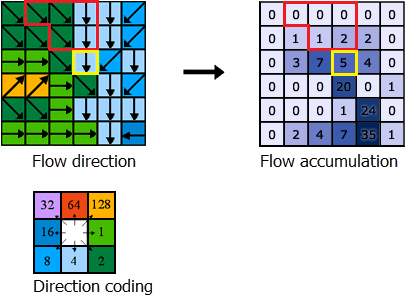

In [ ]:
# Ruta del archivo de salida para D8 Flow Accumulation
fac_file = folder_path + '/Fac.tif'

# Ejecutar la herramienta D8 Flow Accumulation
wbt.d8_flow_accumulation(fill_file, fac_file)

# Plotear el archivo que se acaba de generar
with rasterio.open(fac_file) as src:
    show(src)

## Definición de red hidrográfica

La función "Extract Streams" de WhiteboxTools se utiliza para identificar y extraer las líneas de corriente significativas de una red de drenaje representada en un modelo digital de elevación (DEM). Es esencial incluir un umbral en esta función porque permite ajustar la sensibilidad del proceso de identificación de corrientes. Este umbral actúa como un filtro que controla qué segmentos de la red de drenaje se consideran como líneas de corriente, según criterios como el tamaño del área de drenaje o el flujo de agua. De esta manera, el umbral ayuda a eliminar segmentos irrelevantes o ruido en los datos, asegurando que solo se extraigan las líneas de corriente que son realmente significativas para el análisis, mejorando así la precisión y utilidad de los resultados obtenidos.


In [ ]:
# Ruta del archivo de salida para la herramienta Extract Streams
str_file = folder_path + '/Str.tif'

# Definir los parámetros de la herramienta
threshold = 10000  # Puedes ajustar este umbral según tus necesidades

# Ejecutar la herramienta Extract Streams
wbt.extract_streams(fac_file, str_file, threshold)

# Plotear el archivo que se acaba de generar
with rasterio.open(str_file) as src:
    show(src)

## Vectorizar la red de drenaje

La función `raster_streams_to_vector` convierte líneas de flujo identificadas en un modelo digital de elevación (DEM) en formato raster en elementos vectoriales, lo que permite representarlas como líneas continuas en un sistema de coordenadas espaciales. Esta conversión es fundamental para análisis posteriores, como la evaluación de la red de drenaje, la planificación de cuencas hidrográficas y la gestión de recursos hídricos. Al transformar los datos raster en vectores, la función facilita la visualización detallada y la cuantificación precisa de los cursos de agua, permitiendo análisis más avanzados y la generación de mapas temáticos. Además, este proceso proporciona flexibilidad para realizar operaciones espaciales y geoespaciales adicionales sobre las líneas de corriente vectoriales, mejorando así la capacidad de modelado y la toma de decisiones en estudios ambientales y de ingeniería.

In [ ]:
# Vectorizar la red de drenaje
str_vec_file = folder_path + '/v_Str.shp'

# Ejecutar la herramienta RasterStreamsToVector
wbt.raster_streams_to_vector(str_file, fdr_file, str_vec_file)

# Cargar el Shapefile
gdf = gpd.read_file(str_vec_file)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear el Shapefile
gdf.plot(ax=ax, color='blue', linewidth=0.5)

# Añadir título y etiquetas de los ejes
ax.set_title('Líneas de corriente extraídas', fontsize=15)
ax.set_xlabel('Este (m)')
ax.set_ylabel('Norte (m)')


# Mostrar la gráfica
plt.show()

## Definir los puntos de cierre de las cuencas

In [ ]:
# Lista de puntos de cierre de cuenca
pour_points = [(583768.194823, 9618623.69772),
               (559212.144495, 9608909.11525),
               (530764.904775, 9589626.35497)]

# Crear una lista de objetos Point de Shapely
points = [Point(x, y) for x, y in pour_points]

# Definir el sistema de referencia espacial (CRS) - en este caso, PSAD56 / UTM zone 17S (EPSG:24877)
crs = CRS.from_epsg(24877)

# Crear un GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=points, crs=crs)

# Añadir una columna adicional con nombres para los puntos de cierre de cuenca
gdf['name'] = ['Point1', 'Point2', 'Point3']

# Ruta de salida en Google Drive
pour_points = "/content/drive/My Drive/WEAP/pour_points.shp"

# Guardar el GeoDataFrame como Shapefile
gdf.to_file(pour_points)


## Delimitación de las cuencas

La herramienta `watershed` de Whitebox Tools permite identificar las cuencas hidrográficas y las líneas divisorias de aguas en un modelo digital de elevación (DEM). Utilizando métodos avanzados de análisis hidrológico, la herramienta calcula las áreas de captación para cada celda del DEM, determinando hacia dónde fluye el agua desde cada punto y definiendo los límites de las cuencas hidrográficas que contribuyen a un punto de salida específico, como un arroyo o un embalse. Esto es esencial para la gestión del agua, la planificación de recursos hídricos y la evaluación de la calidad del agua, proporcionando información detallada sobre la distribución y el flujo del agua en un paisaje. Además, la herramienta "watershed" de Whitebox Tools es fundamental para la modelización hidrológica precisa y la delimitación de áreas vulnerables a la erosión y la contaminación, mejorando así la capacidad de tomar decisiones informadas en estudios ambientales y de ingeniería.

In [ ]:
# Definir los parámetros de la herramienta
r_output_watersheds = folder_path + '/r_output_watersheds.tif'

# Ejecutar la herramienta Watershed delineation
wbt.watershed(fdr_file, pour_points, r_output_watersheds)

# Plotear el archivo que se acaba de generar
with rasterio.open(r_output_watersheds) as src:
    show(src)


## Vectorización las cuencas hidrográficas

In [ ]:
# Definir la ruta del archivo vectorial de salida
v_output_watersheds = folder_path + '/v_output_watersheds.shp'

# Ejecutar RasterToVectorPolygon
wbt.raster_to_vector_polygons(r_output_watersheds, v_output_watersheds)

# Plotear el archivo que se acaba de generar
# Cargar el archivo Shapefile en GeoPandas
gdf = gpd.read_file(v_output_watersheds)

# Cargar el archivo Shapefile hecho en WEAP en GeoPandas
v_output_watersheds_weap = '/content/drive/My Drive/WEAP/WEAPCatchment_24877.shp'
gdf_weap = gpd.read_file(v_output_watersheds_weap)

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Trazar los polígonos, uno por uno con un color diferente
colors = ['red', 'green', 'blue']
for i, geom in enumerate(gdf['geometry']):
    gdf.iloc[[i]].plot(ax=ax, facecolor=colors[i], edgecolor='black', alpha=0.5)

# Trazar los polígonos de v_output_other
for geom in gdf_weap['geometry']:
    gdf_weap.plot(ax=ax, edgecolor='purple', facecolor='none')

# Añadir título y etiquetas de ejes
ax.set_title('Cuencas resultantes')
ax.set_xlabel('Este (m)')
ax.set_ylabel('Norte (m)')

# Ajustar los labels del eje y para que sean verticales
ax.yaxis.set_tick_params(labelrotation=90)  # Rotación de 90 grados

# Configurar el locator para los ejes x e y
ax.xaxis.set_major_locator(MultipleLocator(30000))  # Espaciado de 30,000 en el eje x
ax.yaxis.set_major_locator(MultipleLocator(30000))  # Espaciado de 30,000 en el eje y

# Mostrar la grilla
ax.grid(True)
#ax.set_aspect('equal', adjustable='datalim')
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=10)

# Mostrar la rosa de los vientos (north arrow)
arrow_props = dict(facecolor='black', arrowstyle='->')
ax.annotate('N', xy=(540000, 9620000), xytext=(540000, 9610000), arrowprops=arrow_props, fontsize=20)

# Mostrar la figura
plt.show()